# Initialise Spark context

In [1]:
#def init_spark():
    import pyspark
    from pyspark import SparkConf, SparkContext
    from pyspark.sql import SparkSession
    import pyspark.sql.functions as F

    # start the session
    conf = SparkConf().setAppName('*')
    conf.set('spark.driver.cores', '5')
    conf.set('spark.driver.memory', '40G')
    conf.set('spark.driver.maxResultSize', '40G')
    conf.set('spark.executor.cores', '10')
    conf.set('spark.executor.instances', '20')
    conf.set('spark.executor.memory', '40G')
    conf.set('spark.executor.memoryOverhead', '10G')
    conf.set('spark.kryoserializer.buffer.max', '2047')
    conf.set('spark.locality.wait', '0')
    conf.set('spark.port.maxRetries', '128')
    conf.set('spark.scheduler.minRegisteredResourcesRatio', '1')
    conf.set('spark.network.timeout', '500')
    conf.set('spark.dynamicAllocation.enabled', 'False')
    conf.set('spark.shuffle.service.enabled', 'False')
    conf.set('spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation', 'True')
    conf.set("spark.sql.broadcastTimeout", "1800")
    sc = SparkContext(conf = conf)
    spark = SparkSession(sc)


# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyspark.sql.functions import col
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count, approx_count_distinct
import re
from pyspark.sql.functions import to_date, col, regexp_replace

#Smote
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

# Statistics
from scipy.stats import chi2_contingency
#sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
# Import the split function from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#### Getting the data from bdp

In [3]:
hive_query = '''
SELECT
    *
FROM
    dev_sce_analysis.sm_psicle_price_increase_churn
'''

In [4]:
load_df = spark.sql(hive_query)

In [5]:
load_df.count()

351000

In [7]:
pandas_df = load_df.toPandas()

In [8]:
s = pandas_df

In [9]:
pandas_df.head()

vas_code  actual_premium  tenure one_yr_loss_ratio three_yr_loss_ratio  \
0    VIA01              60      24                 0                   0   
1     IC02              36      14                 0                   0   
2    VIC01              93      25       3,377746611         1,696512389   
3    VIC01              39      21                 0                   0   
4    VIC01             129      29                 0                   0   

  one_yr_lr_band three_yr_lr_band lr_increase         tp_2        psr_2  ...  \
0    a: 0 to 20%      a: 0 to 20%           0   50,1800201  1,195695017  ...   
1    a: 0 to 20%      a: 0 to 20%           0  66,01444146  0,545335221  ...   
2       f: 100%+         f: 100%+        0,07  159,7461985  0,582173478  ...   
3    a: 0 to 20%      a: 0 to 20%           0  21,87301947  1,783018575  ...   
4    a: 0 to 20%      a: 0 to 20%           0  101,8968919  1,265985622  ...   

  one_yr_claims three_yr_claims five_yr_claims net_th_lo net_ad_repair  \
0           0.0             0.0            0.0       0.0           0.0   
1           0.0             0.0            0.0       0.0           0.0   
2           0.0             0.0            0.0       0.0           0.0   
3           0.0             0.0            0.0       0.0           0.0   
4           0.0             0.0            0.0       0.0           0.0   

  net_ad_replace ad_loss_of_si   map_age insured_value  cancellation_check  
0            0.0             0  51 to 60   7543.281014                   0  
1            0.0             0  31 to 40   2187.820175                   0  
2            0.0             0  31 to 40   3882.335403                   0  
3            0.0             0  61 to 70   3833.837366                   0  
4            0.0             0  51 to 60   5823.499222                   0  

[5 rows x 44 columns]

In [10]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351000 entries, 0 to 350999
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   vas_code                        351000 non-null  object 
 1   actual_premium                  351000 non-null  int32  
 2   tenure                          351000 non-null  int32  
 3   one_yr_loss_ratio               351000 non-null  object 
 4   three_yr_loss_ratio             351000 non-null  object 
 5   one_yr_lr_band                  351000 non-null  object 
 6   three_yr_lr_band                351000 non-null  object 
 7   lr_increase                     351000 non-null  object 
 8   tp_2                            348437 non-null  object 
 9   psr_2                           348437 non-null  object 
 10  psr_2_increase_loading          348437 non-null  object 
 11  premium_increase                351000 non-null  object 
 12  new_premium_2   

In [ ]:
#converting to strings

# str_colums = ["msisdn", 'lsm']

# # Converting to int format
# for col_name in str_colums:
#     pandas_df[col_name] = pandas_df[str_colums].astype(object)

In [ ]:
# int_columns = [ "actual_premium", "tenure" , "cancellation_check"]
# # Converting to int format
# for col_name in int_columns:
#     pandas_df[col_name] = pandas_df[col_name].astype(int)

In [11]:
flt_columns = ["one_yr_loss_ratio", "three_yr_loss_ratio", "lr_increase", "tp_2", "psr_2", "psr_2_increase_loading", \
               "premium_increase", "new_premium_2", "new_premium_psr", "monetary_increase", "gross_ad_repair", \
               "gross_ad_replace", "gross_th_lo", "gross_ad", "ad_loss_of_si"]

# Converting to float format
for col_name in flt_columns:
    pandas_df[col_name] = pandas_df[col_name].str.replace(',', '.').astype(float)

In [ ]:
# Converting date columns to the specified date format
# date_columns = ["upgrade_date", "target_date_of_increase"]

# for col_name in date_columns:
#     pandas_df[col_name] = pd.to_datetime(pandas_df[col_name], format="%Y/%m/%d")

In [12]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351000 entries, 0 to 350999
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   vas_code                        351000 non-null  object 
 1   actual_premium                  351000 non-null  int32  
 2   tenure                          351000 non-null  int32  
 3   one_yr_loss_ratio               351000 non-null  float64
 4   three_yr_loss_ratio             351000 non-null  float64
 5   one_yr_lr_band                  351000 non-null  object 
 6   three_yr_lr_band                351000 non-null  object 
 7   lr_increase                     351000 non-null  float64
 8   tp_2                            348437 non-null  float64
 9   psr_2                           348437 non-null  float64
 10  psr_2_increase_loading          348437 non-null  float64
 11  premium_increase                351000 non-null  float64
 12  new_premium_2   

In [13]:
pandas_df.shape

(351000, 44)

In [14]:
pandas_df.count()

vas_code                          351000
actual_premium                    351000
tenure                            351000
one_yr_loss_ratio                 351000
three_yr_loss_ratio               351000
one_yr_lr_band                    351000
three_yr_lr_band                  351000
lr_increase                       351000
tp_2                              348437
psr_2                             348437
psr_2_increase_loading            348437
premium_increase                  351000
new_premium_2                     351000
segment                           351000
new_premium_psr                   351000
monetary_increase                 351000
lsm                               324768
policy_make_mapped                351000
si_band                           350994
count_th_lo                       351000
count_ad_repair                   351000
tenure_group                      351000
most_used_prov                    347473
dmuc_24h_distnct_cell_site_qty    349500
count_ad_replace

In [15]:
pandas_df.isnull().sum()

vas_code                              0
actual_premium                        0
tenure                                0
one_yr_loss_ratio                     0
three_yr_loss_ratio                   0
one_yr_lr_band                        0
three_yr_lr_band                      0
lr_increase                           0
tp_2                               2563
psr_2                              2563
psr_2_increase_loading             2563
premium_increase                      0
new_premium_2                         0
segment                               0
new_premium_psr                       0
monetary_increase                     0
lsm                               26232
policy_make_mapped                    0
si_band                               6
count_th_lo                           0
count_ad_repair                       0
tenure_group                          0
most_used_prov                     3527
dmuc_24h_distnct_cell_site_qty     1500
count_ad_replace                      0


In [16]:
pandas_df['cancellation_check'].value_counts()

0    335097
1     15903
Name: cancellation_check, dtype: int64

In [17]:
pandas_dfna = pandas_df.dropna()

In [18]:
pandas_dfna['cancellation_check'].value_counts()

0    307367
1     14067
Name: cancellation_check, dtype: int64

In [ ]:
#pandas_df = pandas_df.fillna(pandas_df.median())

In [ ]:
#pandas_df.isnull().sum()

In [ ]:
#pandas_df = pandas_df.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [ ]:
#pandas_df.isnull().sum()

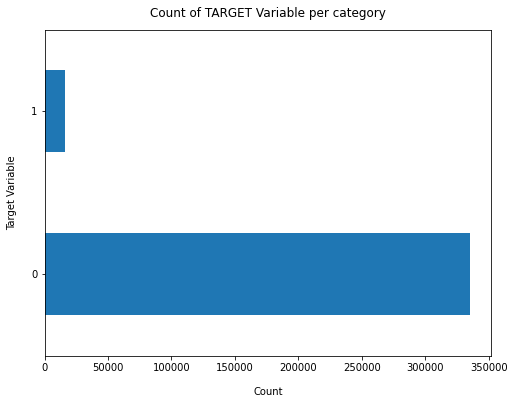

In [19]:
pandas_df['cancellation_check'].value_counts().plot(kind='barh', figsize=(8, 6))
plt.xlabel("Count", labelpad=14)
plt.ylabel("Target Variable", labelpad=14)
plt.title("Count of TARGET Variable per category", y=1.02);

In [20]:
pandas_df.describe()

actual_premium         tenure  one_yr_loss_ratio  three_yr_loss_ratio  \
count   351000.000000  351000.000000      351000.000000        351000.000000   
mean       122.718060      19.258678           0.482671             0.661342   
std         87.579953      13.519204           2.392993             3.371648   
min          1.000000       0.000000           0.000000             0.000000   
25%         60.000000       8.000000           0.000000             0.000000   
50%        100.000000      17.000000           0.000000             0.000000   
75%        167.000000      29.000000           0.000000             0.000000   
max        699.000000     244.000000         408.002728           811.822847   

         lr_increase          tp_2         psr_2  psr_2_increase_loading  \
count  351000.000000  3.484370e+05  3.484370e+05           348437.000000   
mean        0.009310  1.617353e+02  3.989062e+03                0.005549   
std         0.021073  1.691250e+02  4.120119e+05                0.005641   
min         0.000000  1.903740e-07  6.118765e-03                0.000000   
25%         0.000000  5.367032e+01  6.100125e-01                0.000000   
50%         0.000000  1.167906e+02  8.952433e-01                0.005000   
75%         0.000000  2.136377e+02  1.363658e+00                0.010000   
max         0.070000  3.611840e+04  2.416293e+08                0.020000   

       premium_increase  new_premium_2  ...   three_yr_all  one_yr_claims  \
count     351000.000000  351000.000000  ...  351000.000000  351000.000000   
mean           0.094818     134.603356  ...       0.040553      99.588422   
std            0.022347      96.406541  ...       0.434138    1330.633526   
min            0.080000       1.170000  ...       0.000000       0.000000   
25%            0.080000      66.600000  ...       0.000000       0.000000   
50%            0.085000     108.000000  ...       0.000000       0.000000   
75%            0.095000     181.440000  ...       0.000000       0.000000   
max            0.170000     768.900000  ...      18.000000  121475.104348   

       three_yr_claims  five_yr_claims      net_th_lo  net_ad_repair  \
count    351000.000000   351000.000000  351000.000000  351000.000000   
mean        115.234274      123.404121      48.446227      14.850625   
std        1592.108607     1715.389805     748.758395     307.464838   
min           0.000000        0.000000       0.000000       0.000000   
25%           0.000000        0.000000       0.000000       0.000000   
50%           0.000000        0.000000       0.000000       0.000000   
75%           0.000000        0.000000       0.000000       0.000000   
max      162521.739130   174657.965217   44972.904348   20402.608696   

       net_ad_replace  ad_loss_of_si  insured_value  cancellation_check  
count   351000.000000   3.510000e+05   3.509960e+05       351000.000000  
mean         7.797470   1.387009e+01   7.883375e+03            0.045308  
std        292.287423   5.224161e+03   6.631124e+03            0.207978  
min          0.000000   0.000000e+00   6.599987e-03            0.000000  
25%          0.000000   0.000000e+00   3.771644e+03            0.000000  
50%          0.000000   0.000000e+00   5.793972e+03            0.000000  
75%          0.000000   0.000000e+00   1.164699e+04            0.000000  
max      27043.591304   2.151880e+06   1.277814e+06            1.000000  

[8 rows x 31 columns]

## Feature Selection

In [40]:
c = pandas_df.corr().abs()
c = c[c>.93]
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [41]:
so.head(30)

new_premium_2      monetary_increase    0.939829
monetary_increase  new_premium_2        0.939829
one_yr_claims      five_yr_claims       0.955129
five_yr_claims     one_yr_claims        0.955129
three_yr_all       one_yr_all           0.958962
one_yr_all         three_yr_all         0.958962
lr_increase        premium_increase     0.967946
premium_increase   lr_increase          0.967946
one_yr_claims      three_yr_claims      0.969722
three_yr_claims    one_yr_claims        0.969722
                   five_yr_claims       0.989431
five_yr_claims     three_yr_claims      0.989431
gross_ad_replace   net_ad_replace       0.995822
net_ad_replace     gross_ad_replace     0.995822
gross_th_lo        net_th_lo            0.995895
net_th_lo          gross_th_lo          0.995895
net_ad_repair      gross_ad_repair      0.999025
gross_ad_repair    net_ad_repair        0.999025
actual_premium     new_premium_2        0.999320
new_premium_2      actual_premium       0.999320
new_premium_psr    p

In [43]:
# Create correlation matrix
corr_matrix = pandas_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.93)]



In [44]:
to_drop

['premium_increase',
 'new_premium_2',
 'new_premium_psr',
 'monetary_increase',
 'three_yr_all',
 'three_yr_claims',
 'five_yr_claims',
 'net_th_lo',
 'net_ad_repair',
 'net_ad_replace']

In [45]:
from dython.nominal import associations 

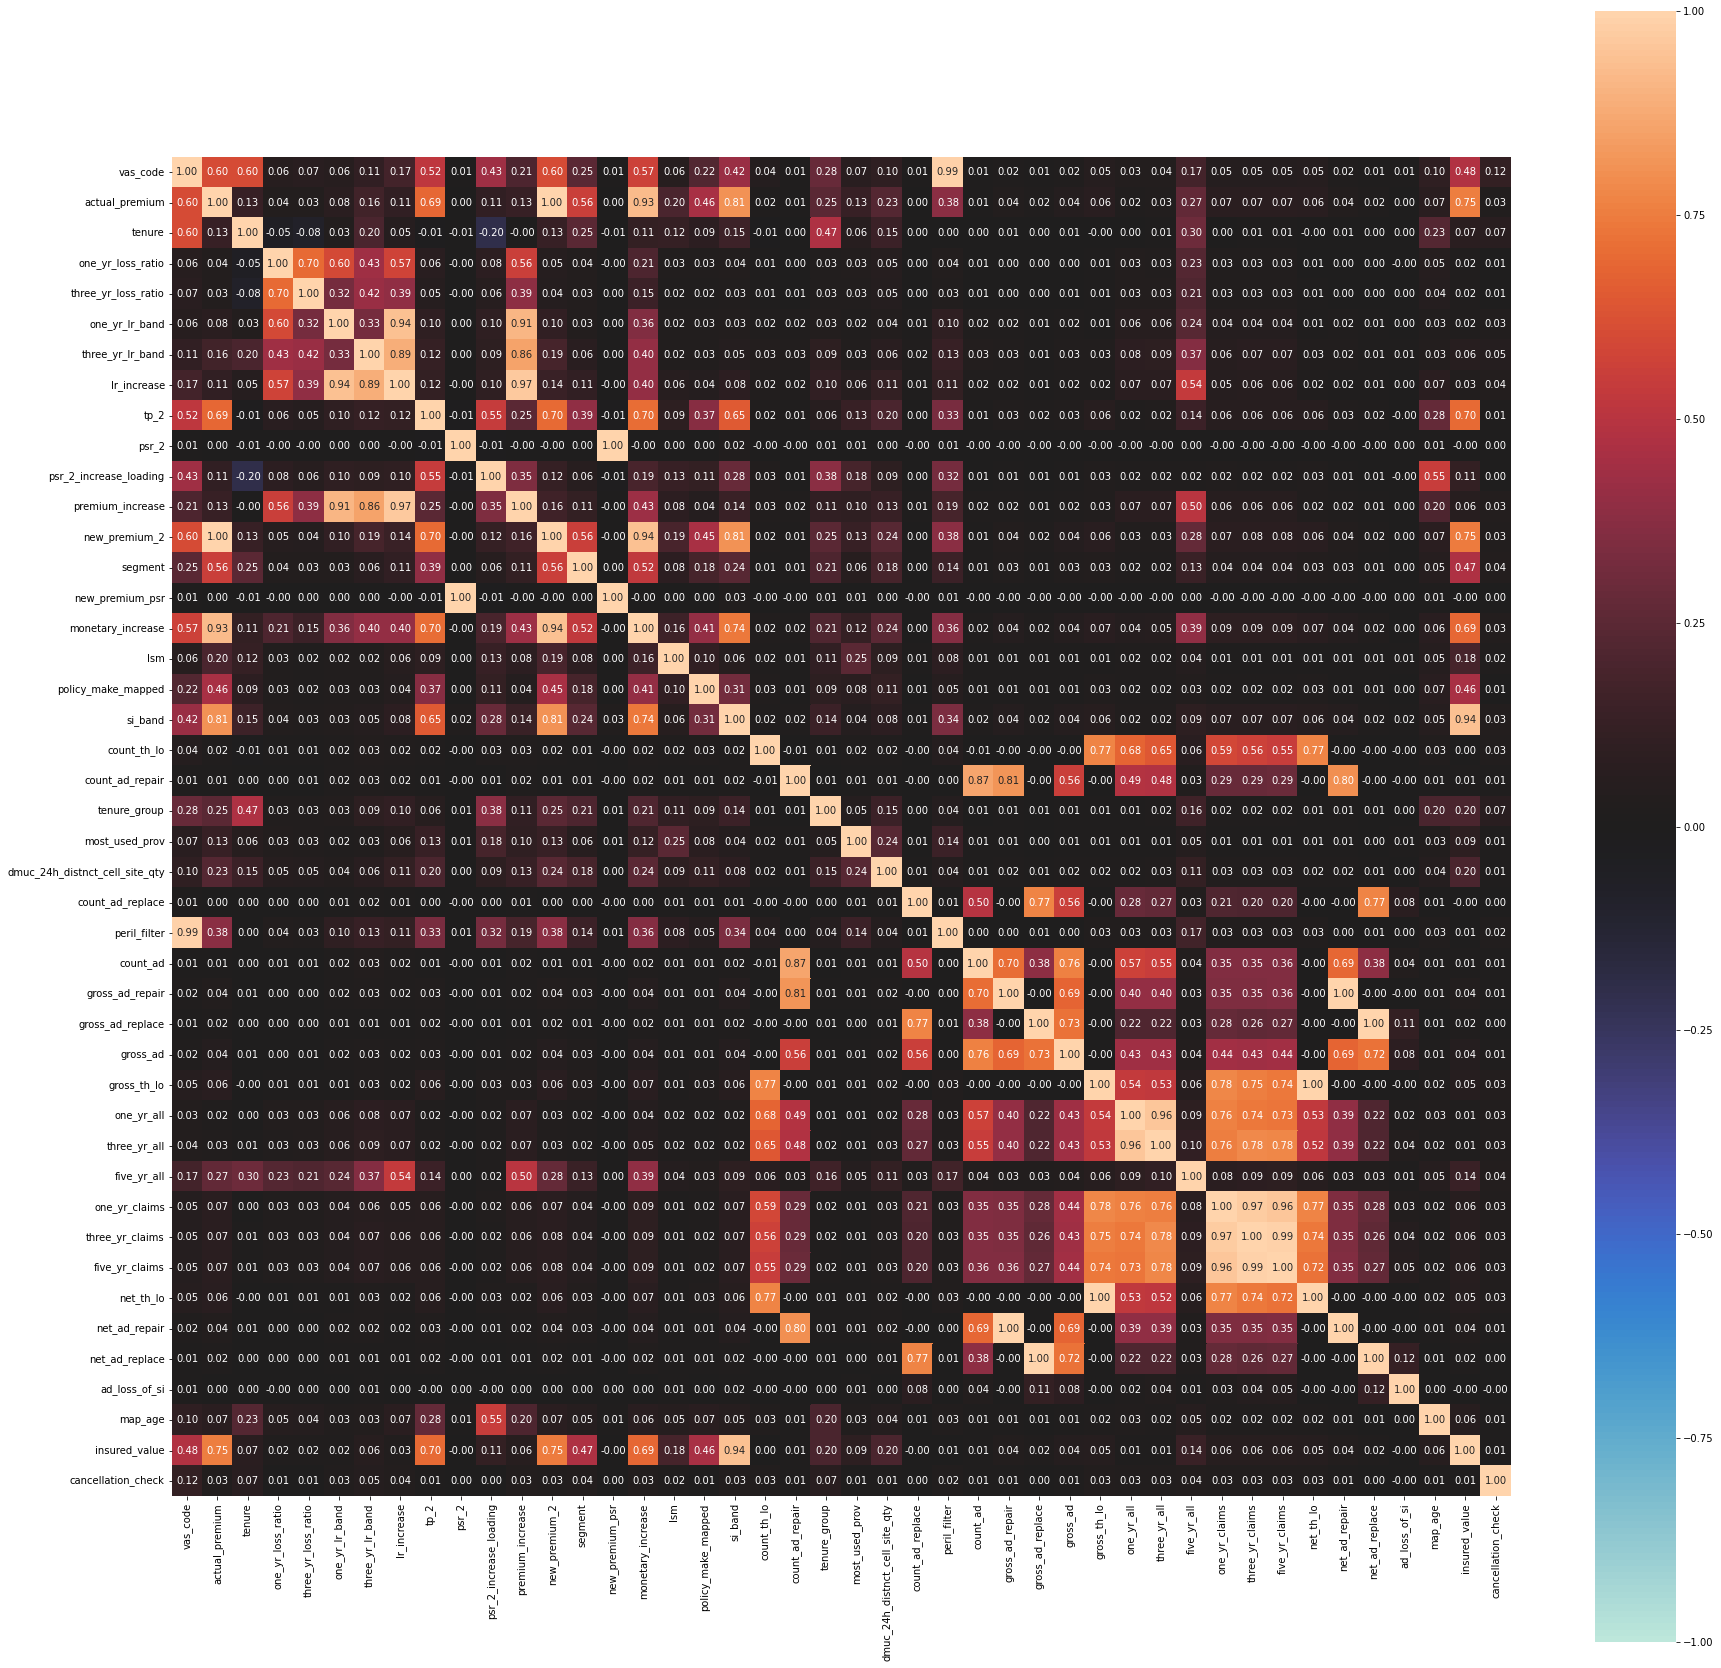

In [46]:
complete_correlation= associations(pandas_df, filename= 'complete_correlation.png', figsize=(30,30))

In [47]:
df_complete_corr=complete_correlation['corr']
df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

In [48]:
c = df_complete_corr
c = c[c>.93]
s = c.unstack()
so = s.sort_values(kind="quicksort")

In [49]:
so.head(30)

lr_increase        one_yr_lr_band       0.939800
one_yr_lr_band     lr_increase          0.939800
monetary_increase  new_premium_2        0.939829
new_premium_2      monetary_increase    0.939829
insured_value      si_band              0.941576
si_band            insured_value        0.941576
five_yr_claims     one_yr_claims        0.955129
one_yr_claims      five_yr_claims       0.955129
one_yr_all         three_yr_all         0.958962
three_yr_all       one_yr_all           0.958962
premium_increase   lr_increase          0.967946
lr_increase        premium_increase     0.967946
three_yr_claims    one_yr_claims        0.969722
one_yr_claims      three_yr_claims      0.969722
five_yr_claims     three_yr_claims      0.989431
three_yr_claims    five_yr_claims       0.989431
peril_filter       vas_code             0.989640
vas_code           peril_filter         0.989640
gross_ad_replace   net_ad_replace       0.995822
net_ad_replace     gross_ad_replace     0.995822
net_th_lo          g

In [50]:
# Create correlation matrix
corr_matrix = df_complete_corr.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.93)]



In [51]:
to_drop

['lr_increase',
 'premium_increase',
 'new_premium_2',
 'new_premium_psr',
 'monetary_increase',
 'peril_filter',
 'three_yr_all',
 'three_yr_claims',
 'five_yr_claims',
 'net_th_lo',
 'net_ad_repair',
 'net_ad_replace',
 'insured_value']

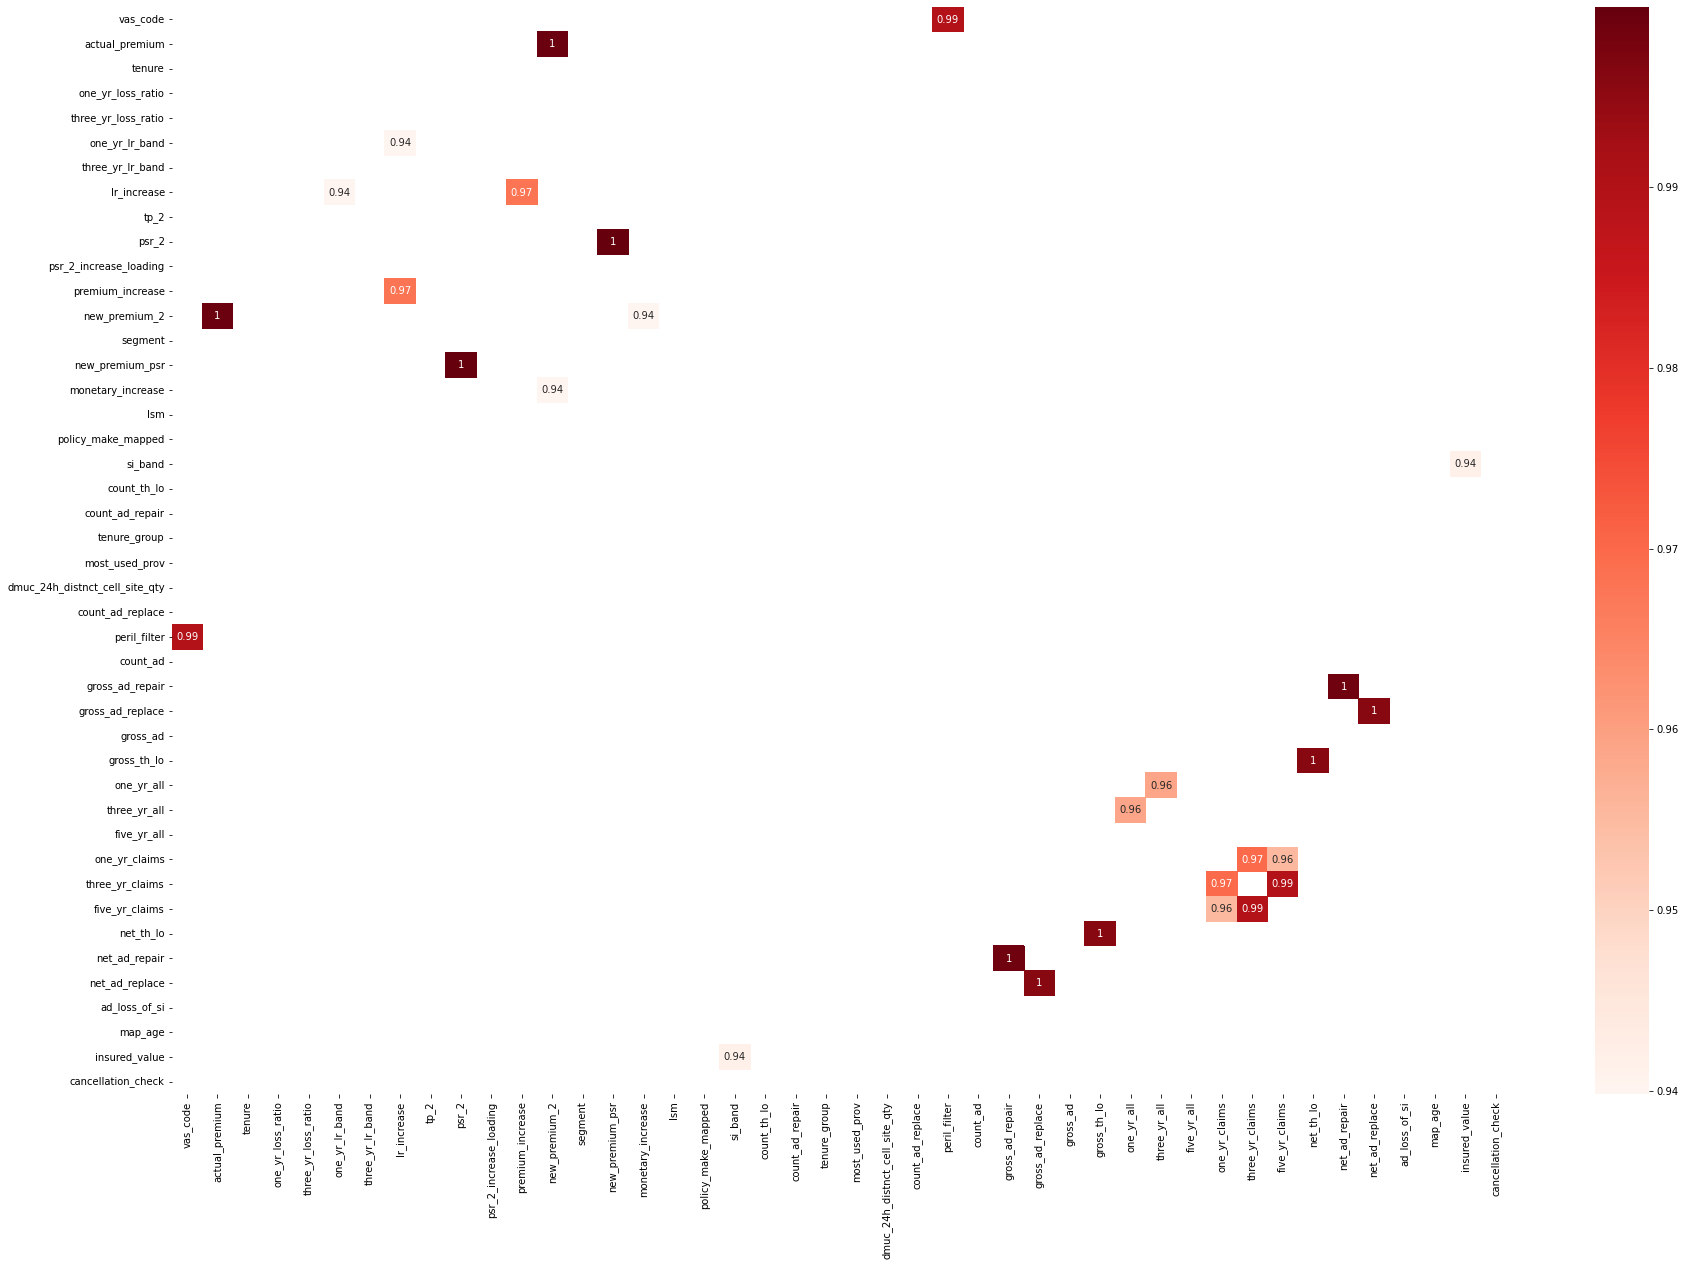

In [52]:
dfCorr = df_complete_corr
filteredDf = dfCorr[((dfCorr >= .93) | (dfCorr <= -.93)) & (dfCorr !=1.000)]
plt.figure(figsize=(30,20))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [53]:
categorical_columns = pandas_df.select_dtypes('object').columns 
categorical_columns

Index(['vas_code', 'one_yr_lr_band', 'three_yr_lr_band', 'segment', 'lsm',
       'policy_make_mapped', 'si_band', 'tenure_group', 'most_used_prov',
       'dmuc_24h_distnct_cell_site_qty', 'peril_filter', 'five_yr_all',
       'map_age'],
      dtype='object')

In [54]:
chi2_array, p_array = [], []
for column in categorical_columns:
    crosstab = pd.crosstab(pandas_df[column], pandas_df['cancellation_check'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)
 
df_chi = pd.DataFrame({
    'Variable': categorical_columns,
    'Chi-square': chi2_array,
    'p-value': p_array
})
df_chi.sort_values(by='Chi-square', ascending=False)

Variable   Chi-square        p-value
0                         vas_code  4731.983201   0.000000e+00
7                     tenure_group  1647.604610   0.000000e+00
2                 three_yr_lr_band   722.606316  6.353390e-154
11                     five_yr_all   512.725226  8.334101e-111
3                          segment   478.202871  4.041334e-101
6                          si_band   403.693111   1.540557e-80
1                   one_yr_lr_band   269.684520   3.270962e-56
10                    peril_filter   203.051204   4.508327e-46
8                   most_used_prov    60.532923   1.181420e-10
12                         map_age    45.591559   1.049658e-07
4                              lsm    36.038688   8.289711e-05
5               policy_make_mapped    16.863534   7.539130e-04
9   dmuc_24h_distnct_cell_site_qty     9.043592   1.711413e-01

In [55]:
#Based on the suggested columns to drop, I am choosing which ones to drop instead since they give the same information
actual_drop = ['one_yr_lr_band',
 'premium_increase',
 'actual_premium',
 'monetary_increase',
 'new_premium_psr',
 'vas_code',
 'one_yr_all',
 'one_yr_claims',
 'three_yr_claims',
 'net_th_lo',
 'net_ad_repair',
 'net_ad_replace',
 'si_band']

In [58]:
#Getting the approxiamte sum insured based on the palicy_make and si_band.
#pandas_df.groupby(['policy_make_mapped', 'si_band'])['insured_value'].mean()

In [74]:
# pandas_df['insured_value'] = pandas_df.groupby(['policy_make_mapped', 'si_band']).transform(lambda x: x.fillna(x.mean()))

#### drop fearures

In [56]:
pandas_df

vas_code  actual_premium  tenure  one_yr_loss_ratio  \
0         VIC01             346      29           0.000000   
1          IC08             221       5           0.000000   
2         VIC01             364      29           0.000000   
3         VIC01             107      18           4.335826   
4         VIC01              74      11           0.000000   
...         ...             ...     ...                ...   
350995    VIC01              39      23           0.000000   
350996     IC06             129       5           0.000000   
350997    VIA01              89      29           0.000000   
350998     IC05             100       6           0.000000   
350999    VIC01             181      29           0.000000   

        three_yr_loss_ratio one_yr_lr_band three_yr_lr_band  lr_increase  \
0                   0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
1                   0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
2                   0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
3                   2.89055       f: 100%+         f: 100%+         0.07   
4                   0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
...                     ...            ...              ...          ...   
350995              0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
350996              0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
350997              0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
350998              0.00000    a: 0 to 20%      a: 0 to 20%         0.00   
350999              0.00000    a: 0 to 20%      a: 0 to 20%         0.00   

              tp_2     psr_2  ...  one_yr_claims  three_yr_claims  \
0       131.698715  2.627209  ...            0.0              0.0   
1       318.307609  0.694297  ...            0.0              0.0   
2       147.218888  2.472509  ...            0.0              0.0   
3       184.781457  0.579062  ...            0.0              0.0   
4       233.775343  0.316543  ...            0.0              0.0   
...            ...       ...  ...            ...              ...   
350995   73.171005  0.532998  ...            0.0              0.0   
350996  308.588526  0.418032  ...            0.0              0.0   
350997  133.104290  0.668649  ...            0.0              0.0   
350998  158.030915  0.632788  ...            0.0              0.0   
350999   24.144603  7.496499  ...            0.0              0.0   

        five_yr_claims net_th_lo  net_ad_repair  net_ad_replace ad_loss_of_si  \
0                  0.0       0.0            0.0             0.0           0.0   
1                  0.0       0.0            0.0             0.0           0.0   
2                  0.0       0.0            0.0             0.0           0.0   
3                  0.0       0.0            0.0             0.0           0.0   
4                  0.0       0.0            0.0             0.0           0.0   
...                ...       ...            ...             ...           ...   
350995             0.0       0.0            0.0             0.0           0.0   
350996             0.0       0.0            0.0             0.0           0.0   
350997             0.0       0.0            0.0             0.0           0.0   
350998             0.0       0.0            0.0             0.0           0.0   
350999             0.0       0.0            0.0             0.0           0.0   

         map_age insured_value  cancellation_check  
0       81 to 90  23293.973595                   0  
1       41 to 50  15879.702051                   0  
2       51 to 60  12422.679742                   0  
3       41 to 50   5823.499222                   0  
4       41 to 50  15529.318318                   0  
...          ...           ...                 ...  
350995  31 to 40   1941.171584                   1  
350996  21 to 30   8026.006420                   0  
350997  41 to 50  15086.554484                   0  
350998  41 to 50 

In [57]:
# Drop features 
pandas_df.drop(actual_drop, axis=1, inplace=True)
pandas_drop =pandas_df

In [58]:
pandas_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351000 entries, 0 to 350999
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   tenure                          351000 non-null  int32  
 1   one_yr_loss_ratio               351000 non-null  float64
 2   three_yr_loss_ratio             351000 non-null  float64
 3   three_yr_lr_band                351000 non-null  object 
 4   lr_increase                     351000 non-null  float64
 5   tp_2                            348437 non-null  float64
 6   psr_2                           348437 non-null  float64
 7   psr_2_increase_loading          348437 non-null  float64
 8   new_premium_2                   351000 non-null  float64
 9   segment                         351000 non-null  object 
 10  lsm                             324768 non-null  object 
 11  policy_make_mapped              351000 non-null  object 
 12  count_th_lo     

In [59]:
pandas_drop.isnull().sum()

tenure                                0
one_yr_loss_ratio                     0
three_yr_loss_ratio                   0
three_yr_lr_band                      0
lr_increase                           0
tp_2                               2563
psr_2                              2563
psr_2_increase_loading             2563
new_premium_2                         0
segment                               0
lsm                               26232
policy_make_mapped                    0
count_th_lo                           0
count_ad_repair                       0
tenure_group                          0
most_used_prov                     3527
dmuc_24h_distnct_cell_site_qty     1500
count_ad_replace                      0
peril_filter                          0
count_ad                              0
gross_ad_repair                       0
gross_ad_replace                      0
gross_ad                              0
gross_th_lo                           0
three_yr_all                          0


In [60]:
pandas_drop = pandas_drop.fillna(-999)

### Feature Engeneering

In [61]:
# Finding all the categorical columns from the data
categorical_columns = pandas_drop.select_dtypes('object').columns 
categorical_columns

Index(['three_yr_lr_band', 'segment', 'lsm', 'policy_make_mapped',
       'tenure_group', 'most_used_prov', 'dmuc_24h_distnct_cell_site_qty',
       'peril_filter', 'five_yr_all', 'map_age'],
      dtype='object')

In [62]:
 # Finding all the numerical columns from the data
numerical_columns = pandas_drop.select_dtypes(include=['int64', 'int32','float64']).columns
numerical_columns

Index(['tenure', 'one_yr_loss_ratio', 'three_yr_loss_ratio', 'lr_increase',
       'tp_2', 'psr_2', 'psr_2_increase_loading', 'new_premium_2',
       'count_th_lo', 'count_ad_repair', 'count_ad_replace', 'count_ad',
       'gross_ad_repair', 'gross_ad_replace', 'gross_ad', 'gross_th_lo',
       'three_yr_all', 'five_yr_claims', 'ad_loss_of_si', 'insured_value',
       'cancellation_check'],
      dtype='object')

In [63]:
# Making a copy of the data to save the original data
original_df = pandas_drop

In [65]:
#pandas_drop = original_df

In [64]:
pandas_drop.isnull().sum()

tenure                            0
one_yr_loss_ratio                 0
three_yr_loss_ratio               0
three_yr_lr_band                  0
lr_increase                       0
tp_2                              0
psr_2                             0
psr_2_increase_loading            0
new_premium_2                     0
segment                           0
lsm                               0
policy_make_mapped                0
count_th_lo                       0
count_ad_repair                   0
tenure_group                      0
most_used_prov                    0
dmuc_24h_distnct_cell_site_qty    0
count_ad_replace                  0
peril_filter                      0
count_ad                          0
gross_ad_repair                   0
gross_ad_replace                  0
gross_ad                          0
gross_th_lo                       0
three_yr_all                      0
five_yr_all                       0
five_yr_claims                    0
ad_loss_of_si               

In [65]:
pandas_drop = pandas_drop.dropna()

In [66]:
# One hot encoding independent variable x
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res)

In [67]:
for feature in categorical_columns:
    pandas_drop = encode_and_bind(pandas_drop, feature)

pandas_drop.head()

tenure  one_yr_loss_ratio  three_yr_loss_ratio  lr_increase        tp_2  \
0      29           0.000000              0.00000         0.00  131.698715   
1       5           0.000000              0.00000         0.00  318.307609   
2      29           0.000000              0.00000         0.00  147.218888   
3      18           4.335826              2.89055         0.07  184.781457   
4      11           0.000000              0.00000         0.00  233.775343   

      psr_2  psr_2_increase_loading  new_premium_2  count_th_lo  \
0  2.627209                   0.000         373.68            0   
1  0.694297                   0.010         240.89            0   
2  2.472509                   0.000         393.12            0   
3  0.579062                   0.010         124.12            0   
4  0.316543                   0.015          81.03            0   

   count_ad_repair  ...  five_yr_all_2  five_yr_all_3plus  map_age_11 to 20  \
0                0  ...              0                  0                 0   
1                0  ...              0                  0                 0   
2                0  ...              0                  0                 0   
3                0  ...              0                  0                 0   
4                0  ...              0                  0                 0   

   map_age_21 to 30  map_age_31 to 40  map_age_41 to 50  map_age_51 to 60  \
0                 0                 0                 0                 0   
1                 0                 0                 1                 0   
2                 0                 0                 0                 1   
3                 0                 0                 1                 0   
4                 0                 0                 1                 0   

   map_age_61 to 70  map_age_71 to 80  map_age_81 to 90  
0                 0                 0                 1  
1                 0                 0                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0  

[5 rows x 85 columns]

In [68]:
pandas_drop.shape

(351000, 85)

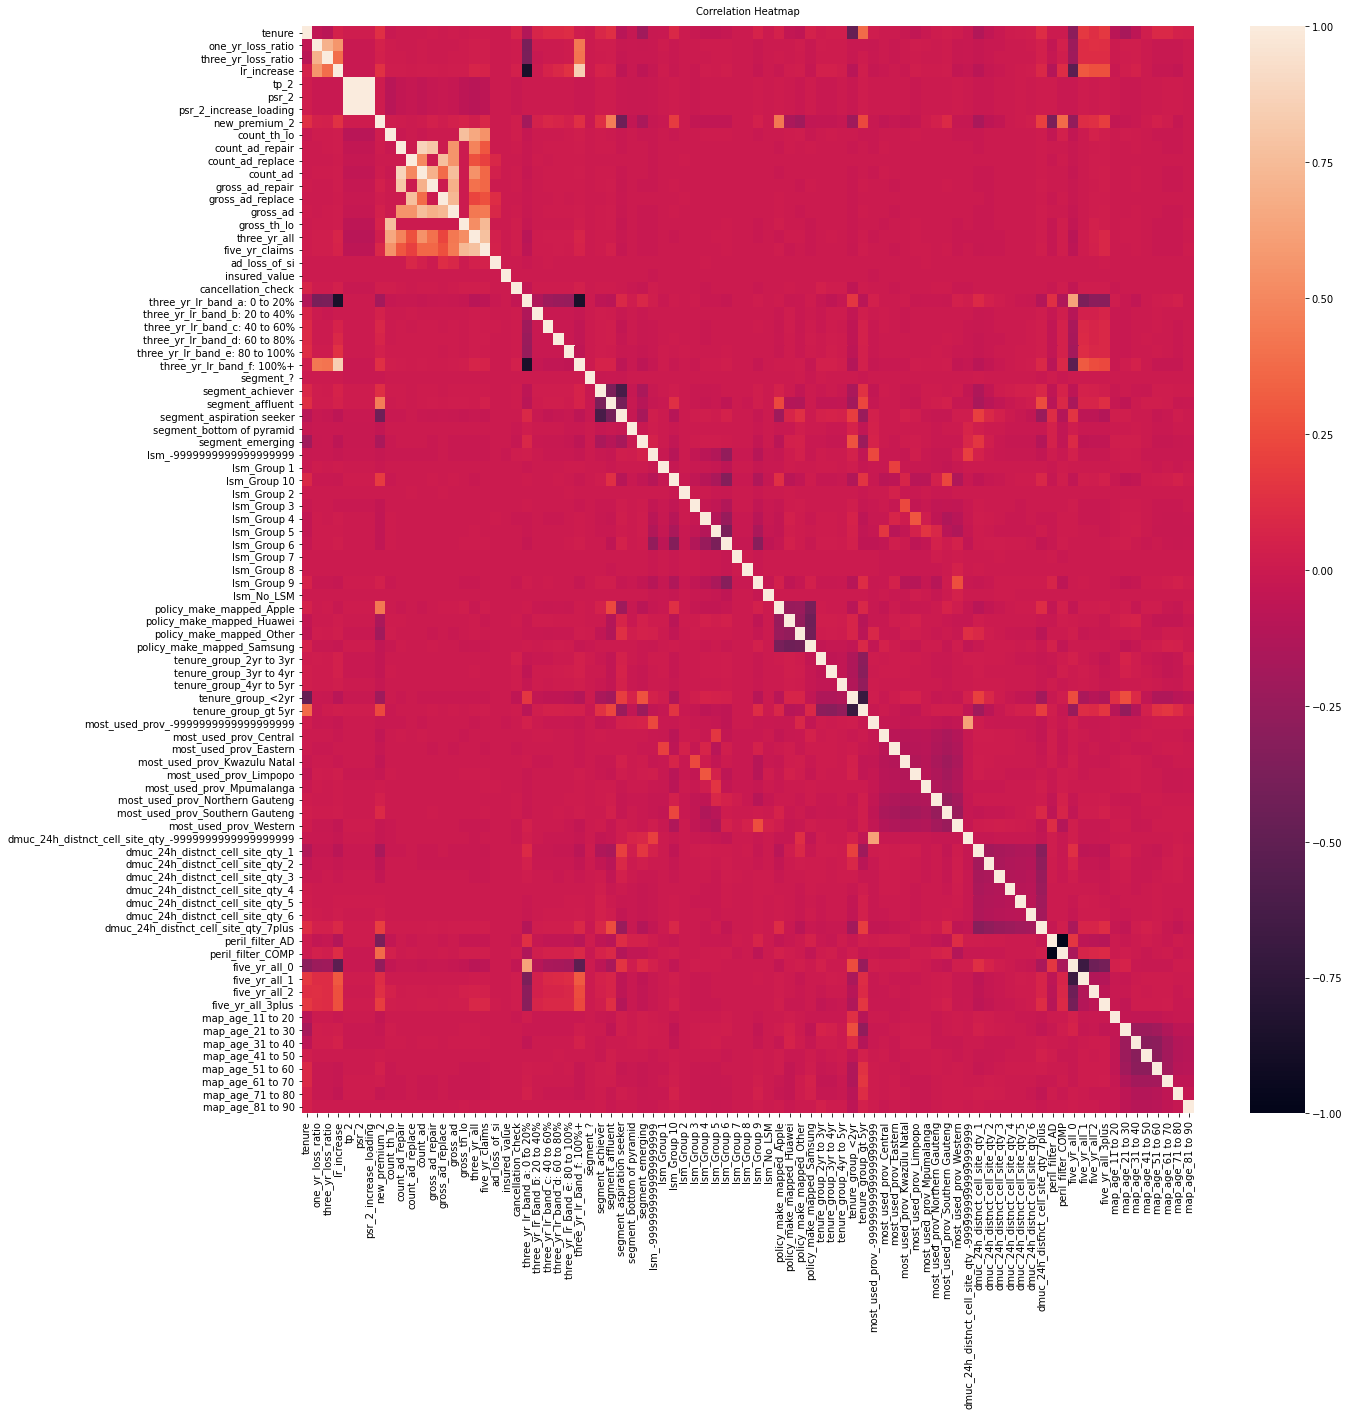

In [69]:
#Heatmap
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(round(pandas_drop.corr(),2), vmin=-1, vmax=1, annot=False)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=12);

<AxesSubplot:>

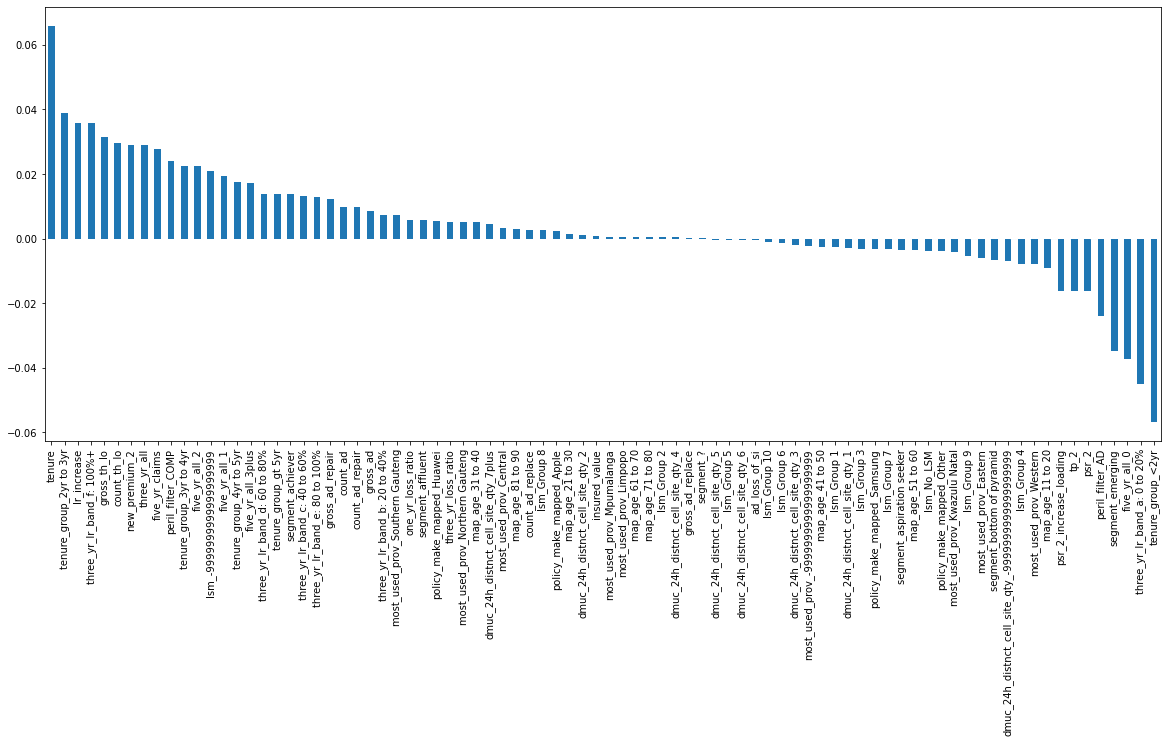

In [70]:
plt.figure(figsize=(20,8))
pandas_drop.corr()['cancellation_check'].sort_values(ascending = False)[1:].plot(kind='bar')

In [71]:
# Split the dataset into the response, y, and features, X
y = pandas_drop['cancellation_check']
X = pandas_drop.drop('cancellation_check', axis=1)

#### model a model with RAW data

In [72]:
#We can then call the train_test_split function:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify =  y,random_state=50)

#Stratify will make sure your train and validation data are split based on output label frequencies based on train data. 
#Like if the data was like 90 to class 'A' and 10 to class 'B'.
#After split both train and validation will have 90:10 ratio of classes

In [73]:
x_train.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [76]:
from xgboost import XGBClassifier

classifier_1 = XGBClassifier(random_state=1234)
classifier_1.fit(x_train,y_train)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[08:53:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [77]:
from sklearn import metrics

# Predicting the test set
y_pred_1 = classifier_1.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy_1 = metrics.accuracy_score(y_test, y_pred_1)
print(accuracy_1)

fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(y_test, y_pred_1)
auc_1 = metrics.auc(fpr_1, tpr_1)
print(auc_1)

0.9548005698005698
0.5038027521874775


In [78]:
xgbpred_1 = classifier_1.predict(x_test)
print(classification_report(y_test, xgbpred_1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     67019
           1       0.60      0.01      0.02      3181

    accuracy                           0.95     70200
   macro avg       0.78      0.50      0.50     70200
weighted avg       0.94      0.95      0.93     70200



In [79]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, xgbpred_1))
print('\nAccuracy:', accuracy_score(y_test, xgbpred_1))
print("Overall Precision:",precision_score(y_test, xgbpred_1))
print("Overall Recall:",recall_score(y_test, xgbpred_1))
print("Overall f1-score:", f1_score(y_test, xgbpred_1))
print("AUC:", roc_auc_score(y_test,xgbpred_1))
plt.show()

Confusion Matrix:
[[67002    17]
 [ 3156    25]]

Accuracy: 0.9548005698005698
Overall Precision: 0.5952380952380952
Overall Recall: 0.00785916378497328
Overall f1-score: 0.015513496742165686
AUC: 0.5038027521874775


#### Over-Sampling | SMOTE

In [76]:
# Transform the dataset (only training data)
oversample = SMOTE(sampling_strategy='auto', random_state=1234)
x_sm, y_sm = oversample.fit_resample(x_train, y_train)

In [77]:
print(Counter(y_train))
print(Counter(y_sm))

Counter({0: 268078, 1: 12722})
Counter({0: 268078, 1: 268078})


In [78]:
#plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [79]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=list(Counter(y_train).keys()), values=list(Counter(y_train).values()), name='Original data'),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=list(Counter(y_sm).keys()), values=list(Counter(y_sm).values()), name='SMOTE data'),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="value+percent+name")
fig.update_layout(
    title_text="Class distribution",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Original', x=0.16, y=0.5, font_size=12, showarrow=False),
                 dict(text='SMOTE', x=0.82, y=0.5, font_size=12, showarrow=False)])
fig.show()

In [81]:
over = BorderlineSMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.6)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [82]:
# transform the dataset
x_sm_us, y_sm_us = pipeline.fit_resample(x_train, y_train)

print(Counter(y_train))
print(Counter(y_sm_us))

Counter({0: 268078, 1: 12722})
Counter({0: 134038, 1: 80423})


In [83]:
list(Counter(y_train).keys())

[0, 1]

In [84]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(labels=list(Counter(y_train).keys()), values=list(Counter(y_train).values()), name='Original Data'),
    row=1, col=1
)

fig.add_trace(
    go.Pie(labels=list(Counter(y_sm_us).keys()), values=list(Counter(y_sm_us).values()), name='SMOTE and US data'),
    row=1, col=2
)

fig.update_traces(textposition='inside', hole=.4, hoverinfo="percent+name+value")
fig.update_layout(
    title_text="Class distribution",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Original', x=0.16, y=0.5, font_size=12, showarrow=False),
                 dict(text='SMOTE and UnderSample', x=0.9, y=0.5, font_size=12, showarrow=False)])
fig.show()

 ## Random Under-Sampling

In [85]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')


In [86]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(x_train, y_train)


In [87]:
# summarize class distribution
print(Counter(y_under))

Counter({0: 12722, 1: 12722})


total class of 1 and 0: 1    12722
0    12722
Name: cancellation_check, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

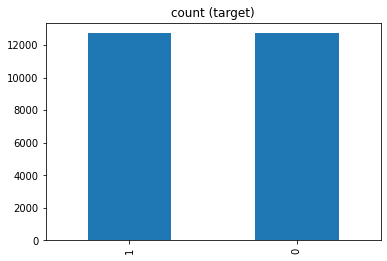

In [88]:
print("total class of 1 and 0:",y_under.value_counts())# plot the count after under-sampeling
y_under.value_counts().plot(kind='bar', title='count (target)')

## Random Over-Sampling

In [89]:
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [90]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# define oversampling strategy
# oversample = RandomOverSampler(sampling_strategy=0.5)

In [91]:
# fit and apply the transform
X_over, y_over = oversample.fit_resample(x_train, y_train)

In [92]:
# summarize class distribution
print(Counter(y_over))

Counter({0: 268078, 1: 268078})


total class of 1 and 0: 1    268078
0    268078
Name: cancellation_check, dtype: int64


<AxesSubplot:title={'center':'count (target)'}>

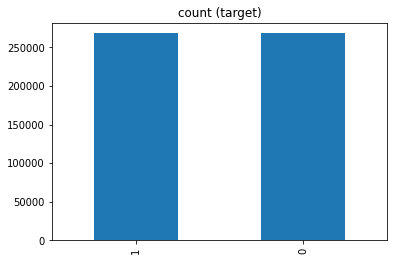

In [93]:
print("total class of 1 and 0:",y_over.value_counts())# plot the count after under-sampeling
y_over.value_counts().plot(kind='bar', title='count (target)')

## Random Over-Sampling + Under-Sampling

In [94]:
print(Counter(y_train))

Counter({0: 268078, 1: 12722})


In [95]:
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X_f, y_f = over.fit_resample(x_train, y_train)


In [96]:
# summarize class distribution
print(Counter(y_f))

Counter({0: 268078, 1: 26807})


In [97]:
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X_os_us, y_os_us = under.fit_resample(X_f, y_f)
# summarize class distribution
print(Counter(y_os_us))

Counter({0: 53614, 1: 26807})


### try model a model with SMOTE data

In [98]:
from xgboost import XGBClassifier

classifier_2 = XGBClassifier(random_state=1234)
classifier_2.fit(x_sm, y_sm)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:24:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [99]:
# Predicting the test set
y_pred_2 = classifier_2.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy_2 = metrics.accuracy_score(y_test, y_pred_2)
print(accuracy_2)

fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(y_test, y_pred_2)
auc_2 = metrics.auc(fpr_2, tpr_2)
print(auc_2)

0.9545014245014245
0.5022985758555879


In [100]:
xgbpred_2 = classifier_2.predict(x_test)
print(classification_report(y_test, xgbpred_2 ))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     67019
           1       0.36      0.01      0.01      3181

    accuracy                           0.95     70200
   macro avg       0.66      0.50      0.49     70200
weighted avg       0.93      0.95      0.93     70200



In [101]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, xgbpred_2))
print('\nAccuracy:', accuracy_score(y_test, xgbpred_2))
print("Overall Precision:",precision_score(y_test, xgbpred_2))
print("Overall Recall:",recall_score(y_test, xgbpred_2))
print("Overall f1-score:", f1_score(y_test, xgbpred_2))
print("AUC:", roc_auc_score(y_test,xgbpred_2))
plt.show()

Confusion Matrix:
[[66990    29]
 [ 3165    16]]

Accuracy: 0.9545014245014245
Overall Precision: 0.35555555555555557
Overall Recall: 0.005029864822382898
Overall f1-score: 0.009919404835709857
AUC: 0.5022985758555879


### try model a model with SMOTE and undersample data

In [104]:
classifier_3 = XGBClassifier(random_state=1234)
classifier_3.fit(x_sm_us, y_sm_us)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:07:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [105]:
# Predicting the test set
y_pred_3 = classifier_3.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy_3 = metrics.accuracy_score(y_test, y_pred_3)
print(accuracy_3)

fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(y_test, y_pred_3)
auc_3 = metrics.auc(fpr_3, tpr_3)
print(auc_3)

0.9541737891737891
0.5066186638697789


In [106]:
xgbpred_3 = classifier_3.predict(x_test)
print(classification_report(y_test, xgbpred_3 ))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     67019
           1       0.36      0.01      0.03      3181

    accuracy                           0.95     70200
   macro avg       0.66      0.51      0.50     70200
weighted avg       0.93      0.95      0.93     70200



In [107]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, xgbpred_3))
print('\nAccuracy:', accuracy_score(y_test, xgbpred_3))
print("Overall Precision:",precision_score(y_test, xgbpred_3))
print("Overall Recall:",recall_score(y_test, xgbpred_3))
print("Overall f1-score:", f1_score(y_test, xgbpred_3))
print("AUC:", roc_auc_score(y_test,xgbpred_3))


Confusion Matrix:
[[66937    82]
 [ 3135    46]]

Accuracy: 0.9541737891737891
Overall Precision: 0.359375
Overall Recall: 0.014460861364350833
Overall f1-score: 0.02780296161982472
AUC: 0.5066186638697789


### try model a model with undersample data

In [108]:
X_under.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [109]:
classifier_4 = XGBClassifier(random_state=1234)
classifier_4.fit(X_under, y_under)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:07:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [110]:
# Predicting the test set
xgbpred_4 = classifier_4.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy_4 = metrics.accuracy_score(y_test, xgbpred_4)
print(accuracy_4)

fpr_4, tpr_4, thresholds_4 = metrics.roc_curve(y_test, xgbpred_4)
auc_4 = metrics.auc(fpr_4, tpr_4)
print(auc_4)

0.5741452991452991
0.6408682947779114


In [111]:
xgbpred_4 = classifier_4.predict(x_test)
print(classification_report(y_test, xgbpred_4 ))

              precision    recall  f1-score   support

           0       0.98      0.57      0.72     67019
           1       0.07      0.71      0.13      3181

    accuracy                           0.57     70200
   macro avg       0.52      0.64      0.42     70200
weighted avg       0.94      0.57      0.69     70200



In [112]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, xgbpred_4))
print('\nAccuracy:', accuracy_score(y_test, xgbpred_4))
print("Overall Precision:",precision_score(y_test, xgbpred_4))
print("Overall Recall:",recall_score(y_test, xgbpred_4))
print("Overall f1-score:", f1_score(y_test, xgbpred_4))
print("AUC:", roc_auc_score(y_test,xgbpred_4))
plt.show()

Confusion Matrix:
[[38033 28986]
 [  909  2272]]

Accuracy: 0.5741452991452991
Overall Precision: 0.07268539253950988
Overall Recall: 0.7142408047783716
Overall f1-score: 0.1319434362205639
AUC: 0.6408682947779114


### try model a model with oversample data

In [113]:
X_over.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [114]:
classifier_5 = XGBClassifier(random_state=1234)
classifier_5.fit(X_over, y_over )

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:08:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [115]:
# Predicting the test set
xgbpred_5 = classifier_5.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy_5 = metrics.accuracy_score(y_test, xgbpred_5)
print(accuracy_5)

fpr_5, tpr_5, thresholds_5 = metrics.roc_curve(y_test, xgbpred_5)
auc_5 = metrics.auc(fpr_5, tpr_5)
print(auc_5)

0.6463247863247863
0.6389944906650902


In [116]:
xgbpred_5 = classifier_5.predict(x_test)
print(classification_report(y_test, xgbpred_5 ))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78     67019
           1       0.08      0.63      0.14      3181

    accuracy                           0.65     70200
   macro avg       0.53      0.64      0.46     70200
weighted avg       0.93      0.65      0.75     70200



In [117]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, xgbpred_5))
print('\nAccuracy:', accuracy_score(y_test, xgbpred_5))
print("Overall Precision:",precision_score(y_test, xgbpred_5))
print("Overall Recall:",recall_score(y_test, xgbpred_5))
print("Overall f1-score:", f1_score(y_test, xgbpred_5))
print("AUC:", roc_auc_score(y_test,xgbpred_5))
plt.show()

Confusion Matrix:
[[43365 23654]
 [ 1174  2007]]

Accuracy: 0.6463247863247863
Overall Precision: 0.07821207279529246
Overall Recall: 0.6309336686576549
Overall f1-score: 0.1391720407738714
AUC: 0.6389944906650902


### try model a model with oversample + undersample data

In [118]:
X_os_us.columns = X.columns.str.translate("".maketrans({"[":"{", "]":"}","<":"^"}))

In [119]:
classifier_6 = XGBClassifier(random_state=1234)
classifier_6.fit(X_os_us, y_os_us)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[09:08:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=40,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [120]:
# Predicting the test set
xgbpred_6 = classifier_6.predict(x_test)

# Making the confusion matrix and calculating accuracy score
accuracy_6 = metrics.accuracy_score(y_test, xgbpred_6)
print(accuracy_6)

fpr_6, tpr_6, thresholds_6 = metrics.roc_curve(y_test, xgbpred_6)
auc_6 = metrics.auc(fpr_6, tpr_6)
print(auc_6)

0.8825071225071225
0.5843710144667575


In [121]:
xgbpred_6 = classifier_6.predict(x_test)
print(classification_report(y_test, xgbpred_6 ))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94     67019
           1       0.12      0.26      0.17      3181

    accuracy                           0.88     70200
   macro avg       0.54      0.58      0.55     70200
weighted avg       0.92      0.88      0.90     70200



In [122]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, xgbpred_6))
print('\nAccuracy:', accuracy_score(y_test, xgbpred_6))
print("Overall Precision:",precision_score(y_test, xgbpred_6))
print("Overall Recall:",recall_score(y_test, xgbpred_6))
print("Overall f1-score:", f1_score(y_test, xgbpred_6))
print("AUC:", roc_auc_score(y_test,xgbpred_6))
plt.show()

Confusion Matrix:
[[61136  5883]
 [ 2365   816]]

Accuracy: 0.8825071225071225
Overall Precision: 0.12180922525750112
Overall Recall: 0.25652310594152783
Overall f1-score: 0.1651821862348178
AUC: 0.5843710144667575


In [123]:
print(accuracy_1,accuracy_2, accuracy_3, accuracy_4, accuracy_5, accuracy_6)

0.9548005698005698 0.9545014245014245 0.9541737891737891 0.5741452991452991 0.6463247863247863 0.8825071225071225


In [124]:
print(auc_1, auc_2 ,auc_3, auc_4, auc_5, auc_6)

0.5038027521874775 0.5022985758555879 0.5066186638697789 0.6408682947779114 0.6389944906650902 0.5843710144667575


### Generate new DataFrame with SMOTE and UnderSampling data

In [125]:
# Names of the independent variables
feature_names = list(pandas_drop.drop('cancellation_check', axis=1).columns)

In [129]:
# Concatenate train (with resampling) and test sets to build the new dataframe 
# sm_us_x = np.concatenate((x_sm_us, x_test))
# sm_us_y = np.concatenate((y_sm_us, y_test))

In [126]:
sm_us_df = pd.DataFrame(np.column_stack([y_sm_us,x_sm_us ]), columns=['cancellation_check'] + feature_names)
sm_us_df.head()

cancellation_check  tenure  one_yr_loss_ratio  three_yr_loss_ratio  \
0                 0.0     4.0                0.0                  0.0   
1                 0.0     9.0                0.0                  0.0   
2                 0.0    12.0                0.0                  0.0   
3                 0.0    26.0                0.0                  0.0   
4                 0.0     7.0                0.0                  0.0   

   lr_increase        tp_2     psr_2  psr_2_increase_loading  new_premium_2  \
0          0.0  179.196430  0.558047                   0.010         109.00   
1          0.0  177.544070  0.225296                   0.020          44.00   
2          0.0   67.672151  1.093507                   0.000          79.92   
3          0.0    9.332174  3.321841                   0.000          33.48   
4          0.0   65.286864  0.827119                   0.005          58.59   

   count_th_lo  ...  five_yr_all_2  five_yr_all_3plus  map_age_11 to 20  \
0          0.0  ...            0.0                1.0               0.0   
1          0.0  ...            0.0                0.0               0.0   
2          0.0  ...            0.0                0.0               0.0   
3          0.0  ...            0.0                0.0               0.0   
4          0.0  ...            0.0                0.0               0.0   

   map_age_21 to 30  map_age_31 to 40  map_age_41 to 50  map_age_51 to 60  \
0               0.0               1.0               0.0               0.0   
1               0.0               1.0               0.0               0.0   
2               0.0               0.0               1.0               0.0   
3               1.0               0.0               0.0               0.0   
4               0.0               0.0               1.0               0.0   

   map_age_61 to 70  map_age_71 to 80  map_age_81 to 90  
0               0.0               0.0               0.0  
1               0.0               0.0               0.0  
2               0.0               0.0               0.0  
3               0.0               0.0               0.0  
4               0.0               0.0               0.0  

[5 rows x 85 columns]

In [ ]:
# sm_us_df = pd.DataFrame(np.column_stack([sm_us_y, sm_us_x]), columns=['cancellation_check'] + feature_names)
# sm_us_df.head()

### Feature Selection

In [127]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=1234)
rf_clf.fit(x_sm_us, y_sm_us)

RandomForestClassifier(random_state=1234)

In [128]:
rf_clf.feature_importances_

array([7.59856275e-02, 8.66624258e-03, 2.31829506e-02, 2.30989871e-02,
       4.64045008e-02, 4.56748432e-02, 1.47814934e-02, 4.29905179e-02,
       1.21869547e-03, 2.14777685e-04, 8.50080609e-05, 2.51961837e-04,
       3.50349897e-04, 9.06213214e-05, 3.92818744e-04, 1.73864913e-03,
       1.27216297e-03, 2.09015506e-03, 1.09780605e-04, 4.10228612e-02,
       1.03551085e-02, 1.52111031e-03, 2.19175458e-03, 2.67510459e-03,
       3.14175124e-03, 1.67560639e-02, 8.98262741e-05, 1.76979191e-02,
       1.57279192e-02, 1.76679683e-02, 1.11302768e-04, 2.11269025e-03,
       1.10844599e-02, 8.58122036e-04, 1.62765907e-02, 3.34192898e-05,
       2.39166174e-03, 1.20194500e-02, 2.03478362e-02, 2.17769797e-02,
       1.24318494e-04, 1.32172666e-04, 1.70822379e-02, 8.15916728e-04,
       1.45182136e-02, 1.77196288e-02, 1.90872183e-02, 2.19600744e-02,
       5.94246123e-03, 6.89900094e-03, 5.85889983e-03, 1.47404682e-02,
       1.58155369e-02, 2.04345231e-03, 8.37065462e-03, 1.20642847e-02,
      

In [129]:
features_to_plot = 84

importances = rf_clf.feature_importances_
indices = np.argsort(importances)

best_vars = np.array(feature_names)[indices][-features_to_plot:]
values = importances[indices][-features_to_plot:]
best_vars

array(['lsm_Group 2', 'count_ad_replace', 'segment_?', 'gross_ad_replace',
       'ad_loss_of_si', 'segment_bottom of pyramid', 'lsm_Group 7',
       'lsm_Group 8', 'count_ad_repair', 'count_ad', 'map_age_11 to 20',
       'gross_ad_repair', 'gross_ad', 'lsm_No_LSM',
       'dmuc_24h_distnct_cell_site_qty_-9999999999999999999',
       'lsm_Group 1', 'count_th_lo', 'three_yr_all',
       'three_yr_lr_band_b: 20 to 40%', 'gross_th_lo',
       'most_used_prov_-9999999999999999999', 'five_yr_claims',
       'segment_emerging', 'three_yr_lr_band_c: 40 to 60%', 'lsm_Group 3',
       'three_yr_lr_band_d: 60 to 80%', 'three_yr_lr_band_e: 80 to 100%',
       'map_age_71 to 80', 'peril_filter_AD', 'peril_filter_COMP',
       'map_age_81 to 90', 'tenure_group_4yr to 5yr',
       'tenure_group_2yr to 3yr', 'map_age_21 to 30',
       'tenure_group_3yr to 4yr', 'most_used_prov_Central',
       'one_yr_loss_ratio', 'most_used_prov_Mpumalanga',
       'dmuc_24h_distnct_cell_site_qty_6', 'map_age_61 to

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



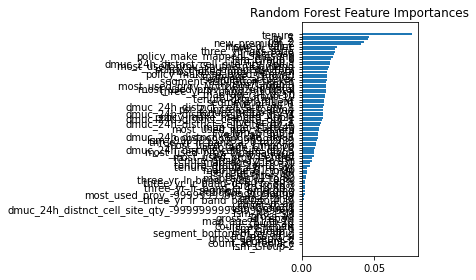

In [130]:
y_ticks = np.arange(0, features_to_plot)
fig, ax = plt.subplots()
ax.barh(y_ticks, values)
ax.set_yticklabels(best_vars)
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

In [131]:
y_pred = rf_clf.predict(x_test)

In [132]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     67019
           1       0.66      0.05      0.09      3181

    accuracy                           0.96     70200
   macro avg       0.81      0.52      0.53     70200
weighted avg       0.94      0.96      0.94     70200



In [133]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred ))
print('\nAccuracy:', accuracy_score(y_test, y_pred ))
print("Overall Precision:",precision_score(y_test, y_pred ))
print("Overall Recall:",recall_score(y_test, y_pred ))
print("Overall f1-score:", f1_score(y_test, y_pred ))
print("AUC:", roc_auc_score(y_test,y_pred ))
plt.show()

Confusion Matrix:
[[66938    81]
 [ 3025   156]]

Accuracy: 0.9557549857549857
Overall Precision: 0.6582278481012658
Overall Recall: 0.04904118201823326
Overall f1-score: 0.09128145114101814
AUC: 0.523916284767603


In [139]:
best_vars = best_vars[-60:]
best_vars

array(['three_yr_lr_band_c: 40 to 60%', 'map_age_71 to 80',
       'three_yr_lr_band_d: 60 to 80%', 'map_age_81 to 90',
       'peril_filter_COMP', 'three_yr_lr_band_e: 80 to 100%',
       'peril_filter_AD', 'tenure_group_2yr to 3yr',
       'tenure_group_4yr to 5yr', 'map_age_21 to 30',
       'tenure_group_3yr to 4yr', 'most_used_prov_Mpumalanga',
       'most_used_prov_Central', 'one_yr_loss_ratio', 'map_age_61 to 70',
       'lsm_-9999999999999999999', 'three_yr_lr_band_a: 0 to 20%',
       'lsm_Group 4', 'most_used_prov_Limpopo', 'five_yr_all_3plus',
       'dmuc_24h_distnct_cell_site_qty_6', 'map_age_31 to 40',
       'five_yr_all_2', 'dmuc_24h_distnct_cell_site_qty_5',
       'most_used_prov_Eastern', 'policy_make_mapped_Apple',
       'lsm_Group 9', 'lsm_Group 10', 'psr_2_increase_loading',
       'tenure_group_gt 5yr', 'tenure_group_<2yr', 'five_yr_all_0',
       'map_age_41 to 50', 'dmuc_24h_distnct_cell_site_qty_4',
       'segment_affluent', 'dmuc_24h_distnct_cell_site_qty_

### Machine Learning | H2O

In [134]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/h2o/backend/connection.py:371: UserWarning:

Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/h2o/backend/connection.py:371: UserWarning:

Proxy is defined in the environment: HTTP_PROXY. This may interfere with your H2O Connection.



--------------------------  ---------------------------------
H2O_cluster_uptime:         31 days 9 hours 20 mins
H2O_cluster_timezone:       Africa/Johannesburg
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.3
H2O_cluster_version_age:    1 year, 10 months and 25 days !!!
H2O_cluster_name:           H2O_from_python_nxums003_ydkshq
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    24.14 Gb
H2O_cluster_total_cores:    40
H2O_cluster_allowed_cores:  40
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.6.13 final
--------------------------  ---------------------------------

In [135]:
hf = h2o.H2OFrame(sm_us_df[['cancellation_check'] + list(best_vars)])
hf.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


cancellation_check lsm_Group 2 count_ad_replace segment_? gross_ad_replace ad_loss_of_si segment_bottom of pyramid lsm_Group 7 lsm_Group 8 count_ad_repair count_ad map_age_11 to 20 gross_ad_repair gross_ad lsm_No_LSM dmuc_24h_distnct_cell_site_qty_-9999999999999999999 lsm_Group 1 count_th_lo three_yr_all three_yr_lr_band_b: 20 to 40% gross_th_lo most_used_prov_-9999999999999999999 five_yr_claims segment_emerging three_yr_lr_band_c: 40 to 60% lsm_Group 3 three_yr_lr_band_d: 60 to 80% three_yr_lr_band_e: 80 to 100% map_age_71 to 80 peril_filter_AD peril_filter_COMP map_age_81 to 90 tenure_group_4yr to 5yr tenure_group_2yr to 3yr map_age_21 to 30 tenure_group_3yr to 4yr most_used_prov_Central one_yr_loss_ratio most_used_prov_Mpumalanga dmuc_24h_distnct_cell_site_qty_6 map_age_61 to 70 most_used_prov_Limpopo three_yr_lr_band_a: 0 to 20% lsm_-9999999999999999999 dmuc_24h_distnct_cell_site_qty_5 five_yr_all_3plus lsm_Group 4 most_used_prov_Eastern map_age_31 to 40 dmuc_24h_distnct_cell_site_qty_4 five_yr_all_2 dmuc_24h_distnct_cell_site_qty_2 policy_make_mapped_Apple dmuc_24h_distnct_cell_site_qty_3 tenure_group_<2yr psr_2_increase_loading dmuc_24h_distnct_cell_site_qty_1 five_yr_all_0 segment_affluent tenure_group_gt 5yr lsm_Group 10 map_age_41 to 50 three_yr_lr_band_f: 100%+ most_used_prov_Kwazulu Natal most_used_prov_Northern Gauteng lsm_Group 9 segment_aspiration seeker segment_achiever map_age_51 to 60 policy_make_mapped_Huawei most_used_prov_Western policy_make_mapped_Other most_used_prov_Southern Gauteng dmuc_24h_distnct_cell_site_qty_7plus lsm_Group 5 lsm_Group 6 policy_make_mapped_Samsung lr_increase three_yr_loss_ratio five_yr_all_1 insured_value new_premium_2 psr_2 tp_2 tenure 
 
 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0.01 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 5793.97 109 0.558047 179.196 4 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0.02 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 2937.42 44 0.225296 177.544 9 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 15086.6 79.92 1.09351 67.6722 12 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1426.84 33.48 3.32184 9.33217 26 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0.005 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 2938.02 58.59 0.827119 65.2869 7 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 3882.34 104.76 1.77743 54.5731 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0.01 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0.015 0.749381 1 2717.64 83.98 0.710905 106.906 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 3882.34 93.96 3.50381 24.8301 27 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0.005 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 2820.44 33.635 0.839081 36.9452 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0.005 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0.025 1.32702 0 11647 288.6 0.934196 278.314 29

In [136]:
x_y_test = pd.DataFrame(np.column_stack([y_test,x_test ]), columns=['cancellation_check'] + feature_names)
x_y_test.head()

cancellation_check  tenure  one_yr_loss_ratio  three_yr_loss_ratio  \
0                 0.0    12.0           0.000000             0.000000   
1                 0.0    29.0           0.000000             0.000000   
2                 0.0    20.0           0.000000             0.000000   
3                 1.0    17.0           4.622382             3.262858   
4                 0.0    21.0           3.632311             2.075606   

   lr_increase        tp_2     psr_2  psr_2_increase_loading  new_premium_2  \
0         0.00   65.974131  1.045864                   0.000         74.520   
1         0.00   72.594120  0.854064                   0.005         67.270   
2         0.00  400.802485  0.835823                   0.005        363.475   
3         0.07  306.235144  1.018825                   0.000        358.800   
4         0.07   67.129431  0.834209                   0.005         64.680   

   count_th_lo  ...  five_yr_all_2  five_yr_all_3plus  map_age_11 to 20  \
0          0.0  ...            0.0                0.0               0.0   
1          0.0  ...            0.0                0.0               0.0   
2          0.0  ...            0.0                0.0               0.0   
3          0.0  ...            0.0                0.0               0.0   
4          0.0  ...            0.0                0.0               0.0   

   map_age_21 to 30  map_age_31 to 40  map_age_41 to 50  map_age_51 to 60  \
0               0.0               0.0               1.0               0.0   
1               0.0               1.0               0.0               0.0   
2               0.0               0.0               0.0               1.0   
3               0.0               0.0               0.0               0.0   
4               0.0               1.0               0.0               0.0   

   map_age_61 to 70  map_age_71 to 80  map_age_81 to 90  
0               0.0               0.0               0.0  
1               0.0               0.0               0.0  
2               0.0               0.0               0.0  
3               1.0               0.0               0.0  
4               0.0               0.0               0.0  

[5 rows x 85 columns]

In [137]:
h20_x_test = h2o.H2OFrame(x_y_test)
h20_x_test['cancellation_check'] = h20_x_test['cancellation_check'].asfactor()
h20_x_test.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


cancellation_check tenure one_yr_loss_ratio three_yr_loss_ratio lr_increase tp_2 psr_2 psr_2_increase_loading new_premium_2 count_th_lo count_ad_repair count_ad_replace count_ad gross_ad_repair gross_ad_replace gross_ad gross_th_lo three_yr_all five_yr_claims ad_loss_of_si insured_value three_yr_lr_band_a: 0 to 20% three_yr_lr_band_b: 20 to 40% three_yr_lr_band_c: 40 to 60% three_yr_lr_band_d: 60 to 80% three_yr_lr_band_e: 80 to 100% three_yr_lr_band_f: 100%+ segment_? segment_achiever segment_affluent segment_aspiration seeker segment_bottom of pyramid segment_emerging lsm_-9999999999999999999 lsm_Group 1 lsm_Group 10 lsm_Group 2 lsm_Group 3 lsm_Group 4 lsm_Group 5 lsm_Group 6 lsm_Group 7 lsm_Group 8 lsm_Group 9 lsm_No_LSM policy_make_mapped_Apple policy_make_mapped_Huawei policy_make_mapped_Other policy_make_mapped_Samsung tenure_group_2yr to 3yr tenure_group_3yr to 4yr tenure_group_4yr to 5yr tenure_group_<2yr tenure_group_gt 5yr most_used_prov_-9999999999999999999 most_used_prov_Central most_used_prov_Eastern most_used_prov_Kwazulu Natal most_used_prov_Limpopo most_used_prov_Mpumalanga most_used_prov_Northern Gauteng most_used_prov_Southern Gauteng most_used_prov_Western dmuc_24h_distnct_cell_site_qty_-9999999999999999999 dmuc_24h_distnct_cell_site_qty_1 dmuc_24h_distnct_cell_site_qty_2 dmuc_24h_distnct_cell_site_qty_3 dmuc_24h_distnct_cell_site_qty_4 dmuc_24h_distnct_cell_site_qty_5 dmuc_24h_distnct_cell_site_qty_6 dmuc_24h_distnct_cell_site_qty_7plus peril_filter_AD peril_filter_COMP five_yr_all_0 five_yr_all_1 five_yr_all_2 five_yr_all_3plus map_age_11 to 20 map_age_21 to 30 map_age_31 to 40 map_age_41 to 50 map_age_51 to 60 map_age_61 to 70 map_age_71 to 80 map_age_81 to 90 
 
 
 0 12 0 0 0 65.9741 1.04586 0 74.52 0 0 0 0 0 0 0 0 0 0 0 13313.7 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 
 0 29 0 0 0 72.5941 0.854064 0.005 67.27 0 0 0 0 0 0 0 0 0 0 0 7543.28 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 
 0 20 0 0 0 400.802 0.835823 0.005 363.475 0 0 0 0 0 0 0 0 0 0 0 20827.6 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 
 1 17 4.62238 3.26286 0.07 306.235 1.01882 0 358.8 0 0 0 0 0 0 0 0 0 0 0 19411.6 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 
 0 21 3.63231 2.07561 0.07 67.1294 0.834209 0.005 64.68 0 0 0 0 0 0 0 0 0 0 0 7543.28 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 
 0 3 0 0 0 93.6172 0.779772 0.005 79.205 0 0 0 0 0 0 0 0 0 0 0 4175.48 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 
 0 29 0 0 0 199.18 1.12963 0 243 0 0 0 0 0 0 0 0 0 0 0 11647 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 
 0 29 0 0 0 451.054 0.629636 0.01 309.56 0 0 0 0 0 0 0 0 0 0 0 19411.6 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 
 0 14 0 0 0 16.9881 1.64821 0 30.24 0 0 0 0 0 0 0 0 0 0 0 3771.64 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 
 0 4 0 0 0 11.7274 2.21703 0 28.08 0 0 0 0 0 0 0 0 0 0 0 3940.52 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0

In [138]:
hf['cancellation_check'] = hf['cancellation_check'].asfactor()
predictors = hf.drop('cancellation_check').columns
response = 'cancellation_check'

In [139]:
# Split into train and test
train, valid = hf.split_frame(ratios=[.8], seed=1234)

In [140]:
# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1234,
    exclude_algos = ["DeepLearning", "StackedEnsemble"]
)

In [141]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid
)

AutoML progress: |
09:18:25.647: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_14_20240111_91825


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              125.0                     125.0             688888.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       15.0       15.0       14.88         1.0       833.0      430.784



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.04067805311807988
RMSE: 0.20168800935623288
LogLoss: 0.14487523878271172
Mean Per-Class Error: 0.05510638133996284
AUC: 0.9864166614732441
AUCPR: 0.9834097603992881
Gini: 0.9728333229464883

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2603501332035795: 


0        1   Error                Rate
0      0  105256.0   1988.0  0.0185   (1988.0/107244.0)
1      1    5904.0  58497.0  0.0917    (5904.0/64401.0)
2  Total  111160.0  60485.0   0.046   (7892.0/171645.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.260350       0.936806  191.0
1                        max f2   0.161239       0.934817  247.0
2                  max f0point5   0.384570       0.967024  146.0
3                  max accuracy   0.266589       0.954126  188.0
4                 max precision   0.999568       1.000000    0.0
5                    max recall   0.013711       1.000000  382.0
6               max specificity   0.999568       1.000000    0.0
7              max absolute_mcc   0.289580       0.902492  179.0
8    max min_per_class_accuracy   0.190987       0.940500  228.0
9   max mean_per_class_accuracy   0.231625       0.945907  204.0
10                      max tns   0.999568  107244.000000    0.0
11                      max fns   0.999568   53922.000000    0.0
12                      max fps   0.002088  107244.000000  399.0
13                      max tps   0.013711   64401.000000  382.0
14                      max tnr   0.999568       1.000000    0.0
15                      max fnr   0.999568       0.837285    0.0
16                      max fpr   0.002088       1.000000  399.0
17                      max tpr   0.013711       1.000000  382.0


Gains/Lift Table: Avg response rate: 37.52 %, avg score: 37.53 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010003         0.999659  2.665254   
1       2                  0.020001         0.999633  2.665254   
2       3                  0.030004         0.999600  2.665254   
3       4                  0.040024         0.999548  2.665254   
4       5                  0.050004         0.999494  2.665254   
5       6                  0.100003         0.999164  2.665254   
6       7                  0.150001         0.998596  2.665254   
7       8                  0.200012         0.997273  2.665254   
8       9                  0.300003         0.953887  2.665254   
9      10                  0.400000         0.179903  1.469119   
10     11                  0.500003         0.116847  0.338184   
11     12                  0.600000         0.083533  0.116461   
12     13                  0.699997         0.059201  0.048293   
13     14                  0.800000         0.037400  0.022359   
14     15                  0.899997         0.015657  0.009006   
15     16                  1.000000         0.000802  0.000776   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.665254       1.000000  0.999686                  1.000000   
1          2.665254       1.000000  0.999646                  1.000000   
2          2.665254       1.000000  0.999617                  1.000000   
3          2.665254       1.000000  0.999576                  1.000000   
4          2.665254       1.000000  0.999521                  1.000000   
5          2.665254       1.000000  0.999341                  1.000000   
6          2.665254       1.000000  0.998909                  1.000000   
7          2.665254       1.000000  0.998056                  1.000000   
8          2.665254       1.000000  0.989326                  1.000000   
9          2.366229       0.551212  0.369144                  0.887806   
10         1.960610       0.126886  0.143624                  0.735619   
11         1.653261       0.043696  0.098911                  0.620302   
12         1.423986       0.018119  0.070997                  0.534278   
13         1.248777       0.008389  0.048318                  0.468540   
14         1.111028       0.003379  0.026280                  0.416857   
15         1.000000       0.000291  0.008330                  0.375199   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999686      0.026661                 0.026661  166.525365   
1           0.999666      0.026646                 0.053307  166.525365   
2           0.999650      0.026661                 0.079968  166.525365   
3           0.999631      0.026708                 0.106675  166.525365   
4           0.999609      0.026599                 0.133274  166.525365   
5           0.999475      0.133259                 0.266533  166.525365   
6           0.999286      0.133259                 0.399792  166.525365   
7           0.998979      0.133290                 0.533082  166.525365   
8           0.995762      0.266502                 0.799584  166.525365   
9           0.839112      0.146908                 0.946492   46.911936   
10          0.700011      0.033819                 0.980311  -66.181634   
11          0.599830      0.011646                 0.991957  -88.353879   
12          0.524285      0.004829                 0.996786  -95.170742   
13          0.464787      0.002236                 0.999022  -97.764075   
14          0.416065      0.000901                 0.999922  -99.099367   
15          0.375291      0.000078                 1.000000  -99.922364   

    cumulative_gain  kolmogorov_smirnov  
0        166.525365            0.026661  
1        166.525365            0.053307  
2        166.525365            0.079968  
3        166.525365            0.106675  
4        166.525365            0.133274  
5        166.525365            0.266533  
6        166.525365            0.399792  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.05083285027074498
RMSE: 0.22546141636817812
LogLoss: 0.1856835422416581
Mean Per-Class Error: 0.075171544422381
AUC: 0.9552633968798239
AUCPR: 0.9550532136099125
Gini: 0.9105267937596477

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.439106443769246: 


0        1   Error               Rate
0      0  26694.0    100.0  0.0037    (100.0/26794.0)
1      1   2349.0  13673.0  0.1466   (2349.0/16022.0)
2  Total  29043.0  13773.0  0.0572   (2449.0/42816.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.439106      0.917805  128.0
1                        max f2   0.249562      0.882483  189.0
2                  max f0point5   0.585927      0.964216  103.0
3                  max accuracy   0.439106      0.942802  128.0
4                 max precision   0.999544      1.000000    0.0
5                    max recall   0.005305      1.000000  395.0
6               max specificity   0.999544      1.000000    0.0
7              max absolute_mcc   0.529073      0.880519  112.0
8    max min_per_class_accuracy   0.178895      0.891399  226.0
9   max mean_per_class_accuracy   0.439106      0.924828  128.0
10                      max tns   0.999544  26794.000000    0.0
11                      max fns   0.999544  12768.000000    0.0
12                      max fps   0.001881  26794.000000  399.0
13                      max tps   0.005305  16022.000000  395.0
14                      max tnr   0.999544      1.000000    0.0
15                      max fnr   0.999544      0.796904    0.0
16                      max fpr   0.001881      1.000000  399.0
17                      max tpr   0.005305      1.000000  395.0


Gains/Lift Table: Avg response rate: 37.42 %, avg score: 37.59 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010020         0.999659  2.672326   
1       2                  0.020016         0.999634  2.672326   
2       3                  0.030012         0.999602  2.672326   
3       4                  0.040008         0.999550  2.672326   
4       5                  0.050005         0.999494  2.672326   
5       6                  0.100033         0.999165  2.672326   
6       7                  0.150014         0.998609  2.672326   
7       8                  0.200042         0.997323  2.672326   
8       9                  0.300005         0.959282  2.672326   
9      10                  0.400014         0.178698  0.893688   
10     11                  0.500000         0.120139  0.328345   
11     12                  0.600009         0.086933  0.255250   
12     13                  0.699995         0.061921  0.225347   
13     14                  0.800005         0.038719  0.170999   
14     15                  0.899991         0.016050  0.093634   
15     16                  1.000000         0.000708  0.015602   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.672326       1.000000  0.999685                  1.000000   
1          2.672326       1.000000  0.999646                  1.000000   
2          2.672326       1.000000  0.999620                  1.000000   
3          2.672326       1.000000  0.999578                  1.000000   
4          2.672326       1.000000  0.999522                  1.000000   
5          2.672326       1.000000  0.999343                  1.000000   
6          2.672326       1.000000  0.998912                  1.000000   
7          2.672326       1.000000  0.998080                  1.000000   
8          2.672326       1.000000  0.989980                  1.000000   
9          2.227640       0.334423  0.363275                  0.833596   
10         1.847834       0.122868  0.145282                  0.691470   
11         1.582383       0.095516  0.102550                  0.592137   
12         1.388546       0.084326  0.074282                  0.519602   
13         1.236340       0.063989  0.050379                  0.462646   
14         1.109389       0.035039  0.027130                  0.415140   
15         1.000000       0.005838  0.008548                  0.374206   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999685      0.026776                 0.026776  167.232555   
1           0.999666      0.026713                 0.053489  167.232555   
2           0.999650      0.026713                 0.080202  167.232555   
3           0.999632      0.026713                 0.106915  167.232555   
4           0.999610      0.026713                 0.133629  167.232555   
5           0.999477      0.133691                 0.267320  167.232555   
6           0.999289      0.133566                 0.400886  167.232555   
7           0.998987      0.133691                 0.534577  167.232555   
8           0.995986      0.267133                 0.801710  167.232555   
9           0.837799      0.089377                 0.891087  -10.631243   
10          0.699315      0.032830                 0.923917  -67.165540   
11          0.599846      0.025527                 0.949445  -74.474985   
12          0.524776      0.022532                 0.971976  -77.465323   
13          0.465471      0.017101                 0.989078  -82.900112   
14          0.416773      0.009362                 0.998440  -90.636561   
15          0.375946      0.001560                 1.000000  -98.439791   

    cumulative_gain  kolmogorov_smirnov  
0        167.232555            0.026776  
1        167.232555            0.053489  
2        167.232555            0.080202  
3        167.232555            0.106915  
4        167.232555            0.133629  
5        167.232555            0.267320  
6        167.232555            0.400886  
7        1



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.053495678293478614
RMSE: 0.2312913277524227
LogLoss: 0.19436620963004042
Mean Per-Class Error: 0.07966787593067416
AUC: 0.9519838345711279
AUCPR: 0.9520789697206133
Gini: 0.9039676691422558

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46689101491674695: 


0        1   Error                 Rate
0      0  106887.0    357.0  0.0033     (357.0/107244.0)
1      1   10047.0  54354.0   0.156    (10047.0/64401.0)
2  Total  116934.0  54711.0  0.0606   (10404.0/171645.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.466891       0.912654  128.0
1                        max f2   0.243307       0.875648  197.0
2                  max f0point5   0.618872       0.961834  103.0
3                  max accuracy   0.498761       0.939491  123.0
4                 max precision   0.999587       1.000000    0.0
5                    max recall   0.002735       1.000000  398.0
6               max specificity   0.999587       1.000000    0.0
7              max absolute_mcc   0.533137       0.873978  117.0
8    max min_per_class_accuracy   0.179015       0.886663  232.0
9   max mean_per_class_accuracy   0.422634       0.920564  137.0
10                      max tns   0.999587  107244.000000    0.0
11                      max fns   0.999587   55734.000000    0.0
12                      max fps   0.002014  107244.000000  399.0
13                      max tps   0.002735   64401.000000  398.0
14                      max tnr   0.999587       1.000000    0.0
15                      max fnr   0.999587       0.865421    0.0
16                      max fpr   0.002014       1.000000  399.0
17                      max tpr   0.002735       1.000000  398.0


Gains/Lift Table: Avg response rate: 37.52 %, avg score: 37.42 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010009         0.999666  2.665254   
1       2                  0.020001         0.999614  2.665254   
2       3                  0.030004         0.999568  2.665254   
3       4                  0.040001         0.999520  2.665254   
4       5                  0.050016         0.999469  2.665254   
5       6                  0.100003         0.999126  2.665254   
6       7                  0.150001         0.998486  2.665254   
7       8                  0.200000         0.997046  2.665254   
8       9                  0.300003         0.942435  2.665254   
9      10                  0.400000         0.181485  0.857620   
10     11                  0.500003         0.119976  0.333060   
11     12                  0.600000         0.086251  0.282147   
12     13                  0.699997         0.060856  0.224382   
13     14                  0.800000         0.038067  0.183532   
14     15                  0.899997         0.015791  0.098293   
15     16                  1.000000         0.000764  0.025154   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.665254       1.000000  0.999700                  1.000000   
1          2.665254       1.000000  0.999639                  1.000000   
2          2.665254       1.000000  0.999590                  1.000000   
3          2.665254       1.000000  0.999545                  1.000000   
4          2.665254       1.000000  0.999495                  1.000000   
5          2.665254       1.000000  0.999316                  1.000000   
6          2.665254       1.000000  0.998841                  1.000000   
7          2.665254       1.000000  0.997883                  1.000000   
8          2.665254       1.000000  0.987654                  1.000000   
9          2.213358       0.321778  0.350260                  0.830449   
10         1.837290       0.124964  0.146393                  0.689349   
11         1.578107       0.105861  0.101955                  0.592104   
12         1.384723       0.084188  0.073219                  0.519546   
13         1.234569       0.068861  0.049458                  0.463209   
14         1.108320       0.036880  0.026701                  0.415840   
15         1.000000       0.009438  0.008318                  0.375199   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999700      0.026677                 0.026677  166.525365   
1           0.999670      0.026630                 0.053307  166.525365   
2           0.999643      0.026661                 0.079968  166.525365   
3           0.999619      0.026646                 0.106613  166.525365   
4           0.999594      0.026692                 0.133305  166.525365   
5           0.999455      0.133228                 0.266533  166.525365   
6           0.999250      0.133259                 0.399792  166.525365   
7           0.998909      0.133259                 0.533051  166.525365   
8           0.995157      0.266533                 0.799584  166.525365   
9           0.833938      0.085760                 0.885343  -14.237964   
10          0.696426      0.033307                 0.918650  -66.694034   
11          0.597350      0.028214                 0.946864  -71.785330   
12          0.522476      0.022438                 0.969302  -77.561807   
13          0.463347      0.018354                 0.987655  -81.646782   
14          0.414832      0.009829                 0.997485  -90.170674   
15          0.374179      0.002515                 1.000000  -97.484584   

    cumulative_gain  kolmogorov_smirnov  
0        166.525365            0.026677  
1        166.525365            0.053307  
2        166.525365            0.079968  
3        166.525365            0.106613  
4        166.525365            0.133305  
5        166.525365            0.266533  
6        166.525365            0.399792  
7        1



Cross-Validation Metrics Summary: 


mean        sd   cv_1_valid   cv_2_valid  \
0                  accuracy     0.939602  0.000229     0.939410     0.939876   
1                       auc     0.951893  0.000397     0.952146     0.952024   
2                       err     0.060398  0.000229     0.060590     0.060124   
3                 err_count  2073.400000  7.861298  2080.000000  2064.000000   
4                  f0point5     0.959802  0.001164     0.960707     0.961035   
5                        f1     0.912966  0.000319     0.912502     0.913234   
6                        f2     0.870490  0.001063     0.868903     0.869962   
7            lift_top_group     2.665254  0.000093     2.665295     2.665295   
8                   logloss     0.194438  0.000508     0.194482     0.194084   
9       max_per_class_error     0.155696  0.001594     0.157919     0.156677   
10                      mcc     0.873947  0.000610     0.873782     0.874730   
11  mean_per_class_accuracy     0.920567  0.000347     0.919968     0.920589   
12     mean_per_class_error     0.079433  0.000347     0.080032     0.079411   
13                      mse     0.053491  0.000099     0.053473     0.053398   
14                   pr_auc     0.952029  0.000274     0.952255     0.952060   
15                precision     0.993792  0.002066     0.995777     0.995783   
16                       r2     0.771818  0.000421     0.771894     0.772215   
17                   recall     0.844304  0.001594     0.842081     0.843323   
18                     rmse     0.231282  0.000214     0.231243     0.231080   
19              specificity     0.996830  0.001067     0.997855     0.997855   

     cv_3_valid   cv_4_valid   cv_5_valid  
0      0.939352     0.939789     0.939585  
1      0.951428     0.952342     0.951528  
2      0.060648     0.060211     0.060415  
3   2082.000000  2067.000000  2074.000000  
4      0.958117     0.959836     0.959318  
5      0.912807     0.913272     0.913018  
6      0.871589     0.871016     0.870981  
7      2.665295     2.665295     2.665088  
8      0.194991     0.193784     0.194852  
9      0.153882     0.155047     0.154957  
10     0.873111     0.874303     0.873810  
11     0.920728     0.920845     0.920703  
12     0.079272     0.079155     0.079297  
13     0.053626     0.053403     0.053556  
14     0.951759     0.952332     0.951738  
15     0.990907     0.993609     0.992885  
16     0.771241     0.772192     0.771550  
17     0.846118     0.844953     0.845043  
18     0.231574     0.231092     0.231421  
19     0.995338     0.996736     0.996363


Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2024-01-11 09:21:30   1 min  6.709 sec              0.0       0.484174   
1     2024-01-11 09:21:31   1 min  7.451 sec              5.0       0.365127   
2     2024-01-11 09:21:31   1 min  8.237 sec             10.0       0.307554   
3     2024-01-11 09:21:32   1 min  8.979 sec             15.0       0.272124   
4     2024-01-11 09:21:33   1 min  9.728 sec             20.0       0.253727   
5     2024-01-11 09:21:34   1 min 10.439 sec             25.0       0.242026   
6     2024-01-11 09:21:34   1 min 11.140 sec             30.0       0.235099   
7     2024-01-11 09:21:35   1 min 11.813 sec             35.0       0.230296   
8     2024-01-11 09:21:36   1 min 12.489 sec             40.0       0.226692   
9     2024-01-11 09:21:36   1 min 13.112 sec             45.0       0.224071   
10    2024-01-11 09:21:37   1 min 13.806 sec             50.0       0.221632   
11    2024-01-11 09:21:38   1 min 14.421 sec             55.0       0.219691   
12    2024-01-11 09:21:38   1 min 15.092 sec             60.0       0.217775   
13    2024-01-11 09:21:39   1 min 15.780 sec             65.0       0.216131   
14    2024-01-11 09:21:40   1 min 16.392 sec             70.0       0.214564   
15    2024-01-11 09:21:40   1 min 17.016 sec             75.0       0.213122   
16    2024-01-11 09:21:41   1 min 17.665 sec             80.0       0.211778   
17    2024-01-11 09:21:41   1 min 18.243 sec             85.0       0.210714   
18    2024-01-11 09:21:42   1 min 18.824 sec             90.0       0.209594   
19    2024-01-11 09:21:43   1 min 19.405 sec             95.0       0.208440   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.661665      0.500000         0.375199       1.000000   
1           0.446374      0.951951         0.949748       2.665254   
2           0.350699      0.956487         0.954217       2.665254   
3           0.288988      0.960540         0.957945       2.665254   
4           0.252978      0.963497         0.960668       2.665254   
5           0.228079      0.966220         0.963232       2.665254   
6           0.211722      0.968456         0.965366       2.665254   
7           0.200070      0.970552         0.967318       2.665254   
8           0.191406      0.972318         0.969009       2.665254   
9           0.185637      0.973866         0.970511       2.665254   
10          0.180260      0.975309         0.971875       2.665254   
11          0.176047      0.976463         0.973047       2.665254   
12          0.171900      0.977498         0.974090       2.665254   
13          0.168514      0.978400         0.975016       2.665254   
14          0.165750      0.979372         0.975985       2.665254   
15          0.162987      0.980193         0.976829       2.665254   
16          0.160523      0.980953         0.977610       2.665254   
17          0.158770      0.981566         0.978242       2.665254   
18          0.156849      0.982243         0.978950       2.665254   
19          0.154982      0.982857         0.979608       2.665254   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.624801         0.483918            0.661158   
1                        0.070745         0.364903            0.446235   
2                        0.067739         0.308234            0.352223   
3                        0.065397         0.273420            0.291746   
4                        0.064354         0.255781            0.257273   
5                        0.062466         0.245151            0.234511   
6                        0.061021         0.239317            0.220217   
7                        0.060357         0.235705            0.210824   
8                        0.059256         0.233145            0.204196   
9                        0.058289         0.231643            0.200337   
10                       0.057281         0.230400


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0                             tenure         13598.335938           1.000000   
1                  five_yr_all_3plus          6739.897461           0.495641   
2           policy_make_mapped_Apple          5693.814453           0.418714   
3                      five_yr_all_1          5489.215820           0.403668   
4                      five_yr_all_0          4741.747070           0.348701   
5                      insured_value          4180.203613           0.307406   
6                      five_yr_all_2          3980.084717           0.292689   
7   dmuc_24h_distnct_cell_site_qty_4          3541.820557           0.260460   
8          three_yr_lr_band_f: 100%+          3390.882324           0.249360   
9                      new_premium_2          3256.942139           0.239510   
10          lsm_-9999999999999999999          3177.700928           0.233683   
11                  segment_affluent          3141.373779           0.231012   
12               tenure_group_gt 5yr          2982.700684           0.219343   
13      three_yr_lr_band_a: 0 to 20%          2979.958252           0.219141   
14         segment_aspiration seeker          2790.041748           0.205175   
15         policy_make_mapped_Huawei          2760.596924           0.203010   
16  dmuc_24h_distnct_cell_site_qty_6          2625.159668           0.193050   
17        policy_make_mapped_Samsung          2608.657715           0.191837   
18  dmuc_24h_distnct_cell_site_qty_1          2590.694580           0.190516   
19          policy_make_mapped_Other          2558.136475           0.188121   

    percentage  
0     0.095847  
1     0.047506  
2     0.040133  
3     0.038690  
4     0.033422  
5     0.029464  
6     0.028053  
7     0.024964  
8     0.023900  
9     0.022956  
10    0.022398  
11    0.022142  
12    0.021023  
13    0.021004  
14    0.019665  
15    0.019458  
16    0.018503  
17    0.018387  
18    0.018260  
19    0.018031


See the whole table with table.as_data_frame()


In [142]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=10)  # Print the first 5 rows

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 GBM_1_AutoML_14_20240111_91825 0.951984 0.194366 0.952079 0.0796679 0.231291 0.0534957 
 XGBoost_1_AutoML_14_20240111_91825 0.950036 0.201234 0.950656 0.0807785 0.234966 0.0552091 
 XGBoost_2_AutoML_14_20240111_91825 0.946472 0.219402 0.947583 0.0856664 0.245045 0.0600471 
 GBM_3_AutoML_14_20240111_91825 0.944362 0.272784 0.944822 0.0886216 0.267573 0.0715951 
 GBM_2_AutoML_14_20240111_91825 0.944296 0.261405 0.944638 0.0888065 0.262223 0.0687608 
 DRF_1_AutoML_14_20240111_91825 0.942191 0.334009 0.945569 0.0854445 0.25379 0.0644091 
 GLM_1_AutoML_14_20240111_91825 0.93757 0.208816 0.940582 0.0868094 0.240426 0.0578048

In [143]:
lb = lb.as_data_frame()
lb['model_type'] = lb['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb, 
    x='model_id',
    y='auc',
    color='model_type'
)
# fig.update_yaxes(range=[0.999, 1])
fig.show()

In [144]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_14_20240111_91825


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              125.0                     125.0             688888.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       15.0       15.0       14.88         1.0       833.0      430.784



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.04067805311807988
RMSE: 0.20168800935623288
LogLoss: 0.14487523878271172
Mean Per-Class Error: 0.05510638133996284
AUC: 0.9864166614732441
AUCPR: 0.9834097603992881
Gini: 0.9728333229464883

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2603501332035795: 


0        1   Error                Rate
0      0  105256.0   1988.0  0.0185   (1988.0/107244.0)
1      1    5904.0  58497.0  0.0917    (5904.0/64401.0)
2  Total  111160.0  60485.0   0.046   (7892.0/171645.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.260350       0.936806  191.0
1                        max f2   0.161239       0.934817  247.0
2                  max f0point5   0.384570       0.967024  146.0
3                  max accuracy   0.266589       0.954126  188.0
4                 max precision   0.999568       1.000000    0.0
5                    max recall   0.013711       1.000000  382.0
6               max specificity   0.999568       1.000000    0.0
7              max absolute_mcc   0.289580       0.902492  179.0
8    max min_per_class_accuracy   0.190987       0.940500  228.0
9   max mean_per_class_accuracy   0.231625       0.945907  204.0
10                      max tns   0.999568  107244.000000    0.0
11                      max fns   0.999568   53922.000000    0.0
12                      max fps   0.002088  107244.000000  399.0
13                      max tps   0.013711   64401.000000  382.0
14                      max tnr   0.999568       1.000000    0.0
15                      max fnr   0.999568       0.837285    0.0
16                      max fpr   0.002088       1.000000  399.0
17                      max tpr   0.013711       1.000000  382.0


Gains/Lift Table: Avg response rate: 37.52 %, avg score: 37.53 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010003         0.999659  2.665254   
1       2                  0.020001         0.999633  2.665254   
2       3                  0.030004         0.999600  2.665254   
3       4                  0.040024         0.999548  2.665254   
4       5                  0.050004         0.999494  2.665254   
5       6                  0.100003         0.999164  2.665254   
6       7                  0.150001         0.998596  2.665254   
7       8                  0.200012         0.997273  2.665254   
8       9                  0.300003         0.953887  2.665254   
9      10                  0.400000         0.179903  1.469119   
10     11                  0.500003         0.116847  0.338184   
11     12                  0.600000         0.083533  0.116461   
12     13                  0.699997         0.059201  0.048293   
13     14                  0.800000         0.037400  0.022359   
14     15                  0.899997         0.015657  0.009006   
15     16                  1.000000         0.000802  0.000776   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.665254       1.000000  0.999686                  1.000000   
1          2.665254       1.000000  0.999646                  1.000000   
2          2.665254       1.000000  0.999617                  1.000000   
3          2.665254       1.000000  0.999576                  1.000000   
4          2.665254       1.000000  0.999521                  1.000000   
5          2.665254       1.000000  0.999341                  1.000000   
6          2.665254       1.000000  0.998909                  1.000000   
7          2.665254       1.000000  0.998056                  1.000000   
8          2.665254       1.000000  0.989326                  1.000000   
9          2.366229       0.551212  0.369144                  0.887806   
10         1.960610       0.126886  0.143624                  0.735619   
11         1.653261       0.043696  0.098911                  0.620302   
12         1.423986       0.018119  0.070997                  0.534278   
13         1.248777       0.008389  0.048318                  0.468540   
14         1.111028       0.003379  0.026280                  0.416857   
15         1.000000       0.000291  0.008330                  0.375199   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999686      0.026661                 0.026661  166.525365   
1           0.999666      0.026646                 0.053307  166.525365   
2           0.999650      0.026661                 0.079968  166.525365   
3           0.999631      0.026708                 0.106675  166.525365   
4           0.999609      0.026599                 0.133274  166.525365   
5           0.999475      0.133259                 0.266533  166.525365   
6           0.999286      0.133259                 0.399792  166.525365   
7           0.998979      0.133290                 0.533082  166.525365   
8           0.995762      0.266502                 0.799584  166.525365   
9           0.839112      0.146908                 0.946492   46.911936   
10          0.700011      0.033819                 0.980311  -66.181634   
11          0.599830      0.011646                 0.991957  -88.353879   
12          0.524285      0.004829                 0.996786  -95.170742   
13          0.464787      0.002236                 0.999022  -97.764075   
14          0.416065      0.000901                 0.999922  -99.099367   
15          0.375291      0.000078                 1.000000  -99.922364   

    cumulative_gain  kolmogorov_smirnov  
0        166.525365            0.026661  
1        166.525365            0.053307  
2        166.525365            0.079968  
3        166.525365            0.106675  
4        166.525365            0.133274  
5        166.525365            0.266533  
6        166.525365            0.399792  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.05083285027074498
RMSE: 0.22546141636817812
LogLoss: 0.1856835422416581
Mean Per-Class Error: 0.075171544422381
AUC: 0.9552633968798239
AUCPR: 0.9550532136099125
Gini: 0.9105267937596477

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.439106443769246: 


0        1   Error               Rate
0      0  26694.0    100.0  0.0037    (100.0/26794.0)
1      1   2349.0  13673.0  0.1466   (2349.0/16022.0)
2  Total  29043.0  13773.0  0.0572   (2449.0/42816.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.439106      0.917805  128.0
1                        max f2   0.249562      0.882483  189.0
2                  max f0point5   0.585927      0.964216  103.0
3                  max accuracy   0.439106      0.942802  128.0
4                 max precision   0.999544      1.000000    0.0
5                    max recall   0.005305      1.000000  395.0
6               max specificity   0.999544      1.000000    0.0
7              max absolute_mcc   0.529073      0.880519  112.0
8    max min_per_class_accuracy   0.178895      0.891399  226.0
9   max mean_per_class_accuracy   0.439106      0.924828  128.0
10                      max tns   0.999544  26794.000000    0.0
11                      max fns   0.999544  12768.000000    0.0
12                      max fps   0.001881  26794.000000  399.0
13                      max tps   0.005305  16022.000000  395.0
14                      max tnr   0.999544      1.000000    0.0
15                      max fnr   0.999544      0.796904    0.0
16                      max fpr   0.001881      1.000000  399.0
17                      max tpr   0.005305      1.000000  395.0


Gains/Lift Table: Avg response rate: 37.42 %, avg score: 37.59 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010020         0.999659  2.672326   
1       2                  0.020016         0.999634  2.672326   
2       3                  0.030012         0.999602  2.672326   
3       4                  0.040008         0.999550  2.672326   
4       5                  0.050005         0.999494  2.672326   
5       6                  0.100033         0.999165  2.672326   
6       7                  0.150014         0.998609  2.672326   
7       8                  0.200042         0.997323  2.672326   
8       9                  0.300005         0.959282  2.672326   
9      10                  0.400014         0.178698  0.893688   
10     11                  0.500000         0.120139  0.328345   
11     12                  0.600009         0.086933  0.255250   
12     13                  0.699995         0.061921  0.225347   
13     14                  0.800005         0.038719  0.170999   
14     15                  0.899991         0.016050  0.093634   
15     16                  1.000000         0.000708  0.015602   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.672326       1.000000  0.999685                  1.000000   
1          2.672326       1.000000  0.999646                  1.000000   
2          2.672326       1.000000  0.999620                  1.000000   
3          2.672326       1.000000  0.999578                  1.000000   
4          2.672326       1.000000  0.999522                  1.000000   
5          2.672326       1.000000  0.999343                  1.000000   
6          2.672326       1.000000  0.998912                  1.000000   
7          2.672326       1.000000  0.998080                  1.000000   
8          2.672326       1.000000  0.989980                  1.000000   
9          2.227640       0.334423  0.363275                  0.833596   
10         1.847834       0.122868  0.145282                  0.691470   
11         1.582383       0.095516  0.102550                  0.592137   
12         1.388546       0.084326  0.074282                  0.519602   
13         1.236340       0.063989  0.050379                  0.462646   
14         1.109389       0.035039  0.027130                  0.415140   
15         1.000000       0.005838  0.008548                  0.374206   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999685      0.026776                 0.026776  167.232555   
1           0.999666      0.026713                 0.053489  167.232555   
2           0.999650      0.026713                 0.080202  167.232555   
3           0.999632      0.026713                 0.106915  167.232555   
4           0.999610      0.026713                 0.133629  167.232555   
5           0.999477      0.133691                 0.267320  167.232555   
6           0.999289      0.133566                 0.400886  167.232555   
7           0.998987      0.133691                 0.534577  167.232555   
8           0.995986      0.267133                 0.801710  167.232555   
9           0.837799      0.089377                 0.891087  -10.631243   
10          0.699315      0.032830                 0.923917  -67.165540   
11          0.599846      0.025527                 0.949445  -74.474985   
12          0.524776      0.022532                 0.971976  -77.465323   
13          0.465471      0.017101                 0.989078  -82.900112   
14          0.416773      0.009362                 0.998440  -90.636561   
15          0.375946      0.001560                 1.000000  -98.439791   

    cumulative_gain  kolmogorov_smirnov  
0        167.232555            0.026776  
1        167.232555            0.053489  
2        167.232555            0.080202  
3        167.232555            0.106915  
4        167.232555            0.133629  
5        167.232555            0.267320  
6        167.232555            0.400886  
7        1



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.053495678293478614
RMSE: 0.2312913277524227
LogLoss: 0.19436620963004042
Mean Per-Class Error: 0.07966787593067416
AUC: 0.9519838345711279
AUCPR: 0.9520789697206133
Gini: 0.9039676691422558

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46689101491674695: 


0        1   Error                 Rate
0      0  106887.0    357.0  0.0033     (357.0/107244.0)
1      1   10047.0  54354.0   0.156    (10047.0/64401.0)
2  Total  116934.0  54711.0  0.0606   (10404.0/171645.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.466891       0.912654  128.0
1                        max f2   0.243307       0.875648  197.0
2                  max f0point5   0.618872       0.961834  103.0
3                  max accuracy   0.498761       0.939491  123.0
4                 max precision   0.999587       1.000000    0.0
5                    max recall   0.002735       1.000000  398.0
6               max specificity   0.999587       1.000000    0.0
7              max absolute_mcc   0.533137       0.873978  117.0
8    max min_per_class_accuracy   0.179015       0.886663  232.0
9   max mean_per_class_accuracy   0.422634       0.920564  137.0
10                      max tns   0.999587  107244.000000    0.0
11                      max fns   0.999587   55734.000000    0.0
12                      max fps   0.002014  107244.000000  399.0
13                      max tps   0.002735   64401.000000  398.0
14                      max tnr   0.999587       1.000000    0.0
15                      max fnr   0.999587       0.865421    0.0
16                      max fpr   0.002014       1.000000  399.0
17                      max tpr   0.002735       1.000000  398.0


Gains/Lift Table: Avg response rate: 37.52 %, avg score: 37.42 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010009         0.999666  2.665254   
1       2                  0.020001         0.999614  2.665254   
2       3                  0.030004         0.999568  2.665254   
3       4                  0.040001         0.999520  2.665254   
4       5                  0.050016         0.999469  2.665254   
5       6                  0.100003         0.999126  2.665254   
6       7                  0.150001         0.998486  2.665254   
7       8                  0.200000         0.997046  2.665254   
8       9                  0.300003         0.942435  2.665254   
9      10                  0.400000         0.181485  0.857620   
10     11                  0.500003         0.119976  0.333060   
11     12                  0.600000         0.086251  0.282147   
12     13                  0.699997         0.060856  0.224382   
13     14                  0.800000         0.038067  0.183532   
14     15                  0.899997         0.015791  0.098293   
15     16                  1.000000         0.000764  0.025154   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.665254       1.000000  0.999700                  1.000000   
1          2.665254       1.000000  0.999639                  1.000000   
2          2.665254       1.000000  0.999590                  1.000000   
3          2.665254       1.000000  0.999545                  1.000000   
4          2.665254       1.000000  0.999495                  1.000000   
5          2.665254       1.000000  0.999316                  1.000000   
6          2.665254       1.000000  0.998841                  1.000000   
7          2.665254       1.000000  0.997883                  1.000000   
8          2.665254       1.000000  0.987654                  1.000000   
9          2.213358       0.321778  0.350260                  0.830449   
10         1.837290       0.124964  0.146393                  0.689349   
11         1.578107       0.105861  0.101955                  0.592104   
12         1.384723       0.084188  0.073219                  0.519546   
13         1.234569       0.068861  0.049458                  0.463209   
14         1.108320       0.036880  0.026701                  0.415840   
15         1.000000       0.009438  0.008318                  0.375199   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.999700      0.026677                 0.026677  166.525365   
1           0.999670      0.026630                 0.053307  166.525365   
2           0.999643      0.026661                 0.079968  166.525365   
3           0.999619      0.026646                 0.106613  166.525365   
4           0.999594      0.026692                 0.133305  166.525365   
5           0.999455      0.133228                 0.266533  166.525365   
6           0.999250      0.133259                 0.399792  166.525365   
7           0.998909      0.133259                 0.533051  166.525365   
8           0.995157      0.266533                 0.799584  166.525365   
9           0.833938      0.085760                 0.885343  -14.237964   
10          0.696426      0.033307                 0.918650  -66.694034   
11          0.597350      0.028214                 0.946864  -71.785330   
12          0.522476      0.022438                 0.969302  -77.561807   
13          0.463347      0.018354                 0.987655  -81.646782   
14          0.414832      0.009829                 0.997485  -90.170674   
15          0.374179      0.002515                 1.000000  -97.484584   

    cumulative_gain  kolmogorov_smirnov  
0        166.525365            0.026677  
1        166.525365            0.053307  
2        166.525365            0.079968  
3        166.525365            0.106613  
4        166.525365            0.133305  
5        166.525365            0.266533  
6        166.525365            0.399792  
7        1



Cross-Validation Metrics Summary: 


mean        sd   cv_1_valid   cv_2_valid  \
0                  accuracy     0.939602  0.000229     0.939410     0.939876   
1                       auc     0.951893  0.000397     0.952146     0.952024   
2                       err     0.060398  0.000229     0.060590     0.060124   
3                 err_count  2073.400000  7.861298  2080.000000  2064.000000   
4                  f0point5     0.959802  0.001164     0.960707     0.961035   
5                        f1     0.912966  0.000319     0.912502     0.913234   
6                        f2     0.870490  0.001063     0.868903     0.869962   
7            lift_top_group     2.665254  0.000093     2.665295     2.665295   
8                   logloss     0.194438  0.000508     0.194482     0.194084   
9       max_per_class_error     0.155696  0.001594     0.157919     0.156677   
10                      mcc     0.873947  0.000610     0.873782     0.874730   
11  mean_per_class_accuracy     0.920567  0.000347     0.919968     0.920589   
12     mean_per_class_error     0.079433  0.000347     0.080032     0.079411   
13                      mse     0.053491  0.000099     0.053473     0.053398   
14                   pr_auc     0.952029  0.000274     0.952255     0.952060   
15                precision     0.993792  0.002066     0.995777     0.995783   
16                       r2     0.771818  0.000421     0.771894     0.772215   
17                   recall     0.844304  0.001594     0.842081     0.843323   
18                     rmse     0.231282  0.000214     0.231243     0.231080   
19              specificity     0.996830  0.001067     0.997855     0.997855   

     cv_3_valid   cv_4_valid   cv_5_valid  
0      0.939352     0.939789     0.939585  
1      0.951428     0.952342     0.951528  
2      0.060648     0.060211     0.060415  
3   2082.000000  2067.000000  2074.000000  
4      0.958117     0.959836     0.959318  
5      0.912807     0.913272     0.913018  
6      0.871589     0.871016     0.870981  
7      2.665295     2.665295     2.665088  
8      0.194991     0.193784     0.194852  
9      0.153882     0.155047     0.154957  
10     0.873111     0.874303     0.873810  
11     0.920728     0.920845     0.920703  
12     0.079272     0.079155     0.079297  
13     0.053626     0.053403     0.053556  
14     0.951759     0.952332     0.951738  
15     0.990907     0.993609     0.992885  
16     0.771241     0.772192     0.771550  
17     0.846118     0.844953     0.845043  
18     0.231574     0.231092     0.231421  
19     0.995338     0.996736     0.996363


Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2024-01-11 09:21:30   1 min  6.709 sec              0.0       0.484174   
1     2024-01-11 09:21:31   1 min  7.451 sec              5.0       0.365127   
2     2024-01-11 09:21:31   1 min  8.237 sec             10.0       0.307554   
3     2024-01-11 09:21:32   1 min  8.979 sec             15.0       0.272124   
4     2024-01-11 09:21:33   1 min  9.728 sec             20.0       0.253727   
5     2024-01-11 09:21:34   1 min 10.439 sec             25.0       0.242026   
6     2024-01-11 09:21:34   1 min 11.140 sec             30.0       0.235099   
7     2024-01-11 09:21:35   1 min 11.813 sec             35.0       0.230296   
8     2024-01-11 09:21:36   1 min 12.489 sec             40.0       0.226692   
9     2024-01-11 09:21:36   1 min 13.112 sec             45.0       0.224071   
10    2024-01-11 09:21:37   1 min 13.806 sec             50.0       0.221632   
11    2024-01-11 09:21:38   1 min 14.421 sec             55.0       0.219691   
12    2024-01-11 09:21:38   1 min 15.092 sec             60.0       0.217775   
13    2024-01-11 09:21:39   1 min 15.780 sec             65.0       0.216131   
14    2024-01-11 09:21:40   1 min 16.392 sec             70.0       0.214564   
15    2024-01-11 09:21:40   1 min 17.016 sec             75.0       0.213122   
16    2024-01-11 09:21:41   1 min 17.665 sec             80.0       0.211778   
17    2024-01-11 09:21:41   1 min 18.243 sec             85.0       0.210714   
18    2024-01-11 09:21:42   1 min 18.824 sec             90.0       0.209594   
19    2024-01-11 09:21:43   1 min 19.405 sec             95.0       0.208440   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.661665      0.500000         0.375199       1.000000   
1           0.446374      0.951951         0.949748       2.665254   
2           0.350699      0.956487         0.954217       2.665254   
3           0.288988      0.960540         0.957945       2.665254   
4           0.252978      0.963497         0.960668       2.665254   
5           0.228079      0.966220         0.963232       2.665254   
6           0.211722      0.968456         0.965366       2.665254   
7           0.200070      0.970552         0.967318       2.665254   
8           0.191406      0.972318         0.969009       2.665254   
9           0.185637      0.973866         0.970511       2.665254   
10          0.180260      0.975309         0.971875       2.665254   
11          0.176047      0.976463         0.973047       2.665254   
12          0.171900      0.977498         0.974090       2.665254   
13          0.168514      0.978400         0.975016       2.665254   
14          0.165750      0.979372         0.975985       2.665254   
15          0.162987      0.980193         0.976829       2.665254   
16          0.160523      0.980953         0.977610       2.665254   
17          0.158770      0.981566         0.978242       2.665254   
18          0.156849      0.982243         0.978950       2.665254   
19          0.154982      0.982857         0.979608       2.665254   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.624801         0.483918            0.661158   
1                        0.070745         0.364903            0.446235   
2                        0.067739         0.308234            0.352223   
3                        0.065397         0.273420            0.291746   
4                        0.064354         0.255781            0.257273   
5                        0.062466         0.245151            0.234511   
6                        0.061021         0.239317            0.220217   
7                        0.060357         0.235705            0.210824   
8                        0.059256         0.233145            0.204196   
9                        0.058289         0.231643            0.200337   
10                       0.057281         0.230400


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0                             tenure         13598.335938           1.000000   
1                  five_yr_all_3plus          6739.897461           0.495641   
2           policy_make_mapped_Apple          5693.814453           0.418714   
3                      five_yr_all_1          5489.215820           0.403668   
4                      five_yr_all_0          4741.747070           0.348701   
5                      insured_value          4180.203613           0.307406   
6                      five_yr_all_2          3980.084717           0.292689   
7   dmuc_24h_distnct_cell_site_qty_4          3541.820557           0.260460   
8          three_yr_lr_band_f: 100%+          3390.882324           0.249360   
9                      new_premium_2          3256.942139           0.239510   
10          lsm_-9999999999999999999          3177.700928           0.233683   
11                  segment_affluent          3141.373779           0.231012   
12               tenure_group_gt 5yr          2982.700684           0.219343   
13      three_yr_lr_band_a: 0 to 20%          2979.958252           0.219141   
14         segment_aspiration seeker          2790.041748           0.205175   
15         policy_make_mapped_Huawei          2760.596924           0.203010   
16  dmuc_24h_distnct_cell_site_qty_6          2625.159668           0.193050   
17        policy_make_mapped_Samsung          2608.657715           0.191837   
18  dmuc_24h_distnct_cell_site_qty_1          2590.694580           0.190516   
19          policy_make_mapped_Other          2558.136475           0.188121   

    percentage  
0     0.095847  
1     0.047506  
2     0.040133  
3     0.038690  
4     0.033422  
5     0.029464  
6     0.028053  
7     0.024964  
8     0.023900  
9     0.022956  
10    0.022398  
11    0.022142  
12    0.021023  
13    0.021004  
14    0.019665  
15    0.019458  
16    0.018503  
17    0.018387  
18    0.018260  
19    0.018031


See the whole table with table.as_data_frame()



In [145]:
best_model.model_performance(h20_x_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.046422524658180524
RMSE: 0.2154588699918862
LogLoss: 0.18899659315455528
Mean Per-Class Error: 0.41487891085365497
AUC: 0.6930730520197299
AUCPR: 0.0989620165392669
Gini: 0.3861461040394598

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16989757702663913: 


0       1   Error                Rate
0      0  58919.0  8100.0  0.1209    (8100.0/67019.0)
1      1   2255.0   926.0  0.7089     (2255.0/3181.0)
2  Total  61174.0  9026.0  0.1475   (10355.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.169898      0.151716  179.0
1                        max f2   0.083989      0.253175  276.0
2                  max f0point5   0.263088      0.133645  114.0
3                  max accuracy   0.662169      0.954744   13.0
4                 max precision   0.662169      0.562500   13.0
5                    max recall   0.002322      1.000000  398.0
6               max specificity   0.907893      0.999985    0.0
7              max absolute_mcc   0.053212      0.112564  320.0
8    max min_per_class_accuracy   0.090379      0.625589  267.0
9   max mean_per_class_accuracy   0.060130      0.633344  310.0
10                      max tns   0.907893  67018.000000    0.0
11                      max fns   0.907893   3181.000000    0.0
12                      max fps   0.001614  67019.000000  399.0
13                      max tps   0.002322   3181.000000  398.0
14                      max tnr   0.907893      0.999985    0.0
15                      max fnr   0.907893      1.000000    0.0
16                      max fpr   0.001614      1.000000  399.0
17                      max tpr   0.002322      1.000000  398.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score:  8.82 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.375668  4.432568   
1       2                      0.02         0.313625  2.672116   
2       3                      0.03         0.279277  2.263439   
3       4                      0.04         0.257443  2.703552   
4       5                      0.05         0.239972  1.854763   
5       6                      0.10         0.187539  1.930211   
6       7                      0.15         0.158107  1.760453   
7       8                      0.20         0.137426  1.420937   
8       9                      0.30         0.108350  1.392644   
9      10                      0.40         0.086827  1.122289   
10     11                      0.50         0.069037  1.049984   
11     12                      0.60         0.053369  0.999686   
12     13                      0.70         0.038124  0.757623   
13     14                      0.80         0.022577  0.484124   
14     15                      0.90         0.010335  0.204338   
15     16                      1.00         0.000820  0.040868   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.432568       0.200855  0.460517                  0.200855   
1          3.552342       0.121083  0.339218                  0.160969   
2          3.122708       0.102564  0.295506                  0.141500   
3          3.017919       0.122507  0.267559                  0.136752   
4          2.785288       0.084046  0.248483                  0.126211   
5          2.357749       0.087464  0.210273                  0.106838   
6          2.158650       0.079772  0.171839                  0.097816   
7          1.974222       0.064387  0.147283                  0.089459   
8          1.780363       0.063105  0.121874                  0.080674   
9          1.615844       0.050855  0.097067                  0.073219   
10         1.502672       0.047578  0.077759                  0.068091   
11         1.418841       0.045299  0.061144                  0.064292   
12         1.324381       0.034330  0.045705                  0.060012   
13         1.219349       0.021937  0.030325                  0.055253   
14         1.106570       0.009259  0.015973                  0.050142   
15         1.000000       0.001852  0.006183                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.460517      0.044326                 0.044326  343.256837   
1           0.399867      0.026721                 0.071047  167.211569   
2           0.365080      0.022634                 0.093681  126.343917   
3           0.340700      0.027036                 0.120717  170.355234   
4           0.322257      0.018548                 0.139264   85.476265   
5           0.266265      0.096511                 0.235775   93.021063   
6           0.234790      0.088023                 0.323798   76.045269   
7           0.212913      0.071047                 0.394844   42.093681   
8           0.182567      0.139264                 0.534109   39.264382   
9           0.161192      0.112229                 0.646338   12.228859   
10          0.144505      0.104998                 0.751336    4.998428   
11          0.130612      0.099969                 0.851305   -0.031437   
12          0.118482      0.075762                 0.927067  -24.237661   
13          0.107462      0.048412                 0.975479  -51.587551   
14          0.097297      0.020434                 0.995913  -79.566174   
15          0.088186      0.004087                 1.000000  -95.913235   

    cumulative_gain  kolmogorov_smirnov  
0        343.256837            0.035955  
1        255.234203            0.053470  
2        212.270774            0.066704  
3        201.791889            0.084548  
4        178.528765            0.093501  
5        135.774914            0.142219  
6        115.865032            0.182047  
7         

In [146]:
# Get a specific model by model ID
m = h2o.get_model("XGBoost_1_AutoML_2_20231211_00816")
m2 = h2o.get_model("GBM_1_AutoML_2_20231211_00816")


In [147]:
m.model_performance(h20_x_test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.058090215275710635
RMSE: 0.2410191180709751
LogLoss: 0.21795477788006323
Mean Per-Class Error: 0.4006123362643331
AUC: 0.6768099034202479
AUCPR: 0.08270691752699566
Gini: 0.3536198068404959

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13651628661573978: 


0        1   Error                Rate
0      0  51835.0  15184.0  0.2266   (15184.0/67019.0)
1      1   1828.0   1353.0  0.5747     (1828.0/3181.0)
2  Total  53663.0  16537.0  0.2423   (17012.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.136516      0.137235  252.0
1                        max f2   0.077644      0.249681  301.0
2                  max f0point5   0.473444      0.113589   99.0
3                  max accuracy   0.985856      0.954658    0.0
4                 max precision   0.946022      0.240000    3.0
5                    max recall   0.000651      1.000000  399.0
6               max specificity   0.985856      0.999970    0.0
7              max absolute_mcc   0.088479      0.107106  291.0
8    max min_per_class_accuracy   0.078589      0.623075  300.0
9   max mean_per_class_accuracy   0.047663      0.628434  334.0
10                      max tns   0.985856  67017.000000    0.0
11                      max fns   0.985856   3181.000000    0.0
12                      max fps   0.000651  67019.000000  399.0
13                      max tps   0.000651   3181.000000  399.0
14                      max tnr   0.985856      0.999970    0.0
15                      max fnr   0.985856      1.000000    0.0
16                      max fpr   0.000651      1.000000  399.0
17                      max tpr   0.000651      1.000000  399.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score: 10.19 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.664476  3.300849   
1       2                      0.02         0.551161  2.546369   
2       3                      0.03         0.481135  2.263439   
3       4                      0.04         0.426828  1.854763   
4       5                      0.05         0.386424  2.011946   
5       6                      0.10         0.265141  1.754165   
6       7                      0.15         0.199201  1.659855   
7       8                      0.20         0.157375  1.483810   
8       9                      0.30         0.105769  1.543540   
9      10                      0.40         0.074170  1.194593   
10     11                      0.50         0.051882  1.024835   
11     12                      0.60         0.035397  0.933669   
12     13                      0.70         0.022653  0.757623   
13     14                      0.80         0.012807  0.471550   
14     15                      0.90         0.005698  0.304936   
15     16                      1.00         0.000126  0.122603   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.300849       0.149573  0.770632                  0.149573   
1          2.923609       0.115385  0.602168                  0.132479   
2          2.703552       0.102564  0.514362                  0.122507   
3          2.491355       0.084046  0.452695                  0.112892   
4          2.395473       0.091168  0.406129                  0.108547   
5          2.074819       0.079487  0.318068                  0.094017   
6          1.936498       0.075214  0.229416                  0.087749   
7          1.823326       0.067236  0.177266                  0.082621   
8          1.730064       0.069943  0.129288                  0.078395   
9          1.596196       0.054131  0.088920                  0.072329   
10         1.481924       0.046439  0.062463                  0.067151   
11         1.390548       0.042308  0.043257                  0.063010   
12         1.300130       0.034330  0.028860                  0.058913   
13         1.196558       0.021368  0.017527                  0.054220   
14         1.097489       0.013818  0.009014                  0.049731   
15         1.000000       0.005556  0.003020                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.770632      0.033008                 0.033008  230.084879   
1           0.686400      0.025464                 0.058472  154.636907   
2           0.629054      0.022634                 0.081107  126.343917   
3           0.584964      0.018548                 0.099654   85.476265   
4           0.549197      0.020119                 0.119774  101.194593   
5           0.433633      0.087708                 0.207482   75.416536   
6           0.365561      0.082993                 0.290475   65.985539   
7           0.318487      0.074191                 0.364665   48.381012   
8           0.255421      0.154354                 0.519019   54.353977   
9           0.213796      0.119459                 0.638478   19.459290   
10          0.183529      0.102483                 0.740962    2.483496   
11          0.160150      0.093367                 0.834329   -6.633134   
12          0.141395      0.075762                 0.910091  -24.237661   
13          0.125911      0.047155                 0.957246  -52.845017   
14          0.112923      0.030494                 0.987740  -69.506445   
15          0.101932      0.012260                 1.000000  -87.739704   

    cumulative_gain  kolmogorov_smirnov  
0        230.084879            0.024101  
1        192.360893            0.040298  
2        170.355234            0.053532  
3        149.135492            0.062486  
4        139.547312            0.073085  
5        107.481924            0.112583  
6         93.649796            0.147142  
7         

In [148]:
m2.model_performance(h20_x_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.05615935934962356
RMSE: 0.23697966020235484
LogLoss: 0.21491805946073209
Mean Per-Class Error: 0.4183614424862996
AUC: 0.6820296434068989
AUCPR: 0.07987220119239223
Gini: 0.36405928681379773

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.193914408648151: 


0        1   Error                Rate
0      0  56851.0  10168.0  0.1517   (10168.0/67019.0)
1      1   2179.0   1002.0   0.685     (2179.0/3181.0)
2  Total  59030.0  11170.0  0.1759   (12347.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.193914      0.139642  205.0
1                        max f2   0.072252      0.250595  313.0
2                  max f0point5   0.295541      0.110182  147.0
3                  max accuracy   0.979936      0.954644    0.0
4                 max precision   0.801799      0.113333   19.0
5                    max recall   0.004084      1.000000  398.0
6               max specificity   0.979936      0.999955    0.0
7              max absolute_mcc   0.062990      0.112098  323.0
8    max min_per_class_accuracy   0.100558      0.624018  282.0
9   max mean_per_class_accuracy   0.070380      0.634247  315.0
10                      max tns   0.979936  67016.000000    0.0
11                      max fns   0.979936   3181.000000    0.0
12                      max fps   0.003039  67019.000000  399.0
13                      max tps   0.004084   3181.000000  398.0
14                      max tnr   0.979936      0.999955    0.0
15                      max fnr   0.979936      1.000000    0.0
16                      max fpr   0.003039      1.000000  399.0
17                      max tpr   0.004084      1.000000  398.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score: 11.10 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.609257  2.263439   
1       2                      0.02         0.492474  2.514932   
2       3                      0.03         0.426149  2.389186   
3       4                      0.04         0.380728  1.917636   
4       5                      0.05         0.345574  2.452059   
5       6                      0.10         0.248520  1.892487   
6       7                      0.15         0.199789  1.791889   
7       8                      0.20         0.167423  1.427224   
8       9                      0.30         0.124353  1.373782   
9      10                      0.40         0.096666  1.298334   
10     11                      0.50         0.075505  1.138007   
11     12                      0.60         0.057311  0.927381   
12     13                      0.70         0.040453  0.779629   
13     14                      0.80         0.024731  0.480981   
14     15                      0.90         0.012583  0.216913   
15     16                      1.00         0.001396  0.075448   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.263439       0.102564  0.725247                  0.102564   
1          2.389186       0.113960  0.545446                  0.108262   
2          2.389186       0.108262  0.456523                  0.108262   
3          2.271298       0.086895  0.402741                  0.102920   
4          2.307450       0.111111  0.362403                  0.104558   
5          2.099969       0.085755  0.290462                  0.095157   
6          1.997275       0.081197  0.221874                  0.090503   
7          1.854763       0.064672  0.182609                  0.084046   
8          1.694436       0.062251  0.144014                  0.076781   
9          1.595410       0.058832  0.109721                  0.072293   
10         1.503930       0.051567  0.085661                  0.068148   
11         1.407838       0.042023  0.066275                  0.063794   
12         1.318094       0.035328  0.048761                  0.059727   
13         1.213455       0.021795  0.032445                  0.054986   
14         1.102728       0.009829  0.018234                  0.049968   
15         1.000000       0.003419  0.007987                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.725247      0.022634                 0.022634  126.343917   
1           0.635347      0.025149                 0.047784  151.493241   
2           0.575739      0.023892                 0.071676  138.918579   
3           0.532489      0.019176                 0.090852   91.763596   
4           0.498472      0.024521                 0.115373  145.205910   
5           0.394467      0.094624                 0.209997   89.248664   
6           0.336936      0.089594                 0.299591   79.188934   
7           0.298354      0.071361                 0.370953   42.722414   
8           0.246907      0.137378                 0.508331   37.378183   
9           0.212611      0.129833                 0.638164   29.833386   
10          0.187221      0.113801                 0.751965   13.800692   
11          0.167063      0.092738                 0.844703   -7.261867   
12          0.150163      0.077963                 0.922666  -22.037095   
13          0.135448      0.048098                 0.970764  -51.901918   
14          0.122424      0.021691                 0.992455  -78.308708   
15          0.110981      0.007545                 1.000000  -92.455203   

    cumulative_gain  kolmogorov_smirnov  
0        126.343917            0.013234  
1        138.918579            0.029102  
2        138.918579            0.043654  
3        127.129833            0.053266  
4        130.745049            0.068475  
5        109.996856            0.115218  
6         99.727549            0.156692  
7         

In [149]:
print('The model performance in Accuracy: {}'.format(aml.leader.accuracy(valid=True)))
print('The model performance in AUC: {}'.format(aml.leader.auc(valid=True)))

The model performance in Accuracy: [[0.439106443769246, 0.9428017563527653]]
The model performance in AUC: 0.9552633968798239


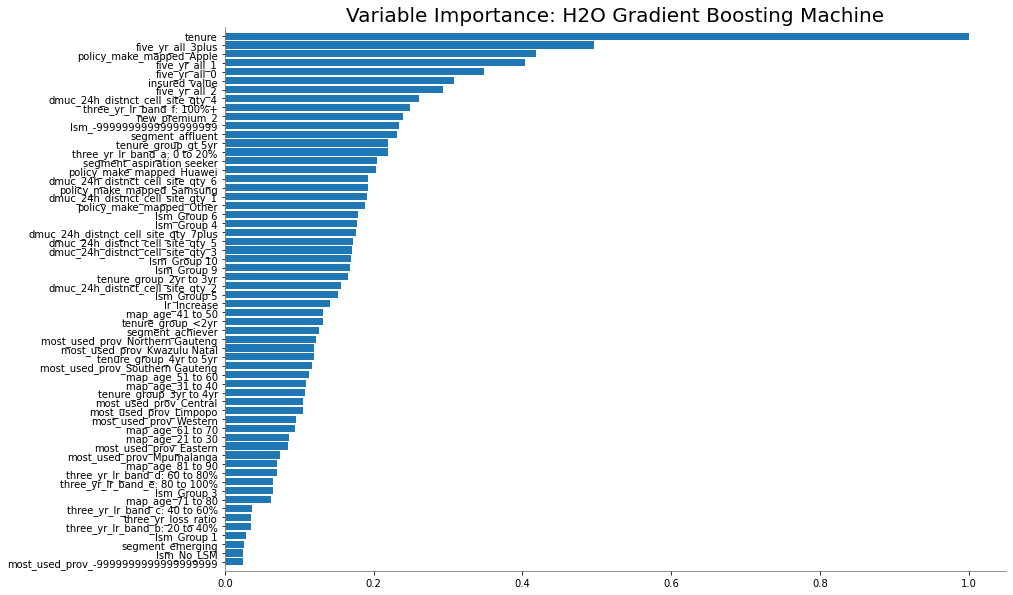

<Figure size 432x288 with 0 Axes>

In [150]:
best_model.varimp_plot(num_of_features=60)

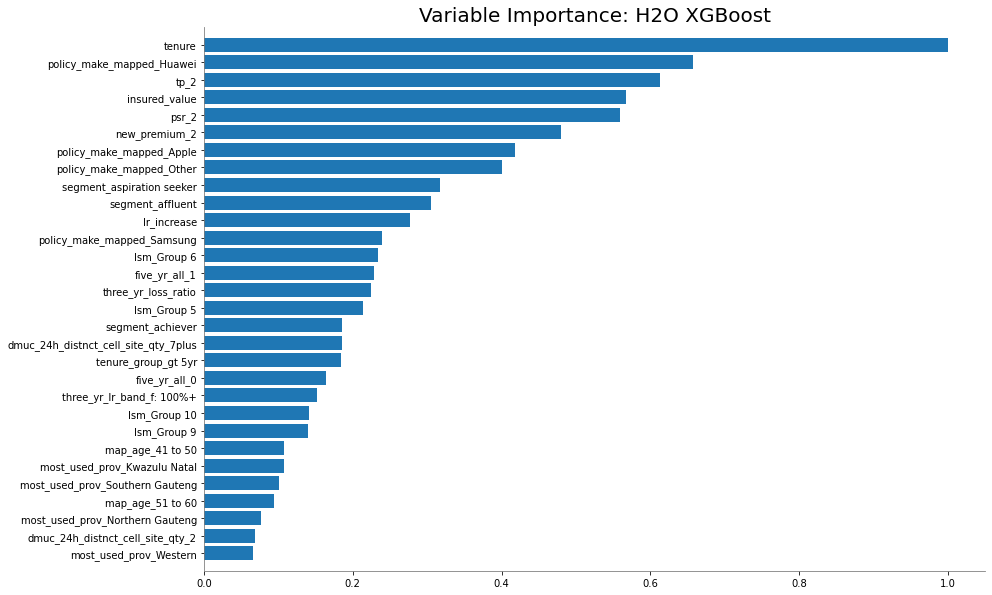

<Figure size 432x288 with 0 Axes>

In [151]:
m.varimp_plot(num_of_features=60)

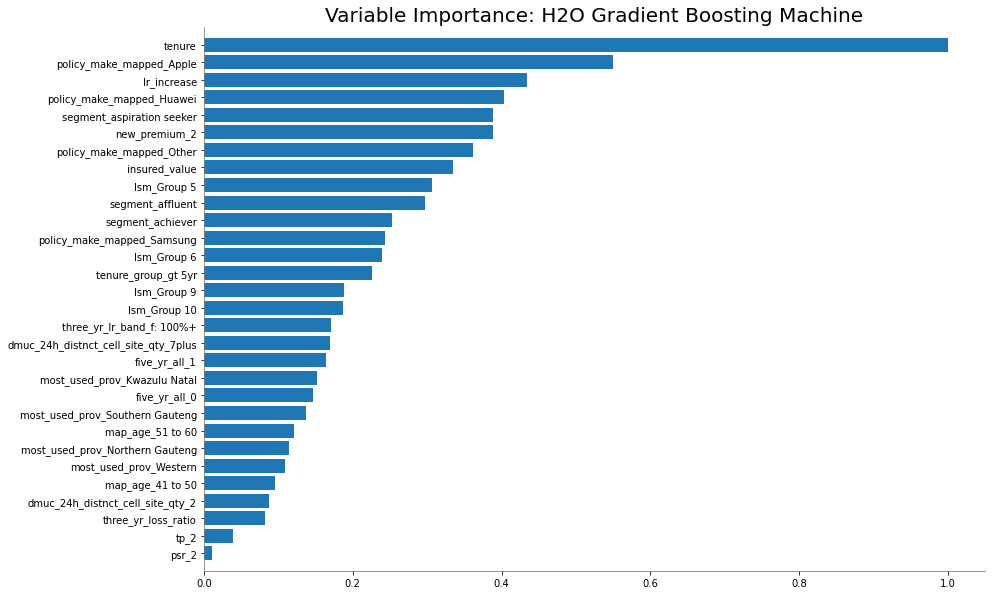

<Figure size 432x288 with 0 Axes>

In [152]:
m2.varimp_plot(num_of_features=60)

#### Generate new DataFrame with SMOTE and UnderSampling data

In [153]:
us_df = pd.DataFrame(np.column_stack([y_under,  X_under]), columns=['cancellation_check'] + feature_names)
us_df.head()

cancellation_check  tenure  one_yr_loss_ratio  three_yr_loss_ratio  \
0                 0.0    31.0                0.0                  0.0   
1                 0.0     7.0                0.0                  0.0   
2                 0.0    29.0                0.0                  0.0   
3                 0.0    12.0                0.0                  0.0   
4                 0.0    15.0                0.0                  0.0   

   lr_increase        tp_2     psr_2  psr_2_increase_loading  new_premium_2  \
0          0.0   48.977180  0.816707                   0.005          43.40   
1          0.0  325.412759  0.679137                   0.010         240.89   
2          0.0   16.967727  2.357416                   0.000          43.20   
3          0.0   28.412934  0.844686                   0.005          26.04   
4          0.0   80.969534  0.988026                   0.005          93.31   

   count_th_lo  ...  five_yr_all_2  five_yr_all_3plus  map_age_11 to 20  \
0          0.0  ...            0.0                0.0               0.0   
1          0.0  ...            0.0                0.0               0.0   
2          0.0  ...            0.0                0.0               0.0   
3          0.0  ...            0.0                0.0               0.0   
4          0.0  ...            0.0                0.0               0.0   

   map_age_21 to 30  map_age_31 to 40  map_age_41 to 50  map_age_51 to 60  \
0               0.0               0.0               0.0               0.0   
1               0.0               1.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               1.0               0.0   
4               0.0               0.0               0.0               1.0   

   map_age_61 to 70  map_age_71 to 80  map_age_81 to 90  
0               1.0               0.0               0.0  
1               0.0               0.0               0.0  
2               1.0               0.0               0.0  
3               0.0               0.0               0.0  
4               0.0               0.0               0.0  

[5 rows x 85 columns]

In [154]:
hf_under = h2o.H2OFrame(us_df[['cancellation_check'] + list(best_vars)])
hf_under.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


cancellation_check lsm_Group 2 count_ad_replace segment_? gross_ad_replace ad_loss_of_si segment_bottom of pyramid lsm_Group 7 lsm_Group 8 count_ad_repair count_ad map_age_11 to 20 gross_ad_repair gross_ad lsm_No_LSM dmuc_24h_distnct_cell_site_qty_-9999999999999999999 lsm_Group 1 count_th_lo three_yr_all three_yr_lr_band_b: 20 to 40% gross_th_lo most_used_prov_-9999999999999999999 five_yr_claims segment_emerging three_yr_lr_band_c: 40 to 60% lsm_Group 3 three_yr_lr_band_d: 60 to 80% three_yr_lr_band_e: 80 to 100% map_age_71 to 80 peril_filter_AD peril_filter_COMP map_age_81 to 90 tenure_group_4yr to 5yr tenure_group_2yr to 3yr map_age_21 to 30 tenure_group_3yr to 4yr most_used_prov_Central one_yr_loss_ratio most_used_prov_Mpumalanga dmuc_24h_distnct_cell_site_qty_6 map_age_61 to 70 most_used_prov_Limpopo three_yr_lr_band_a: 0 to 20% lsm_-9999999999999999999 dmuc_24h_distnct_cell_site_qty_5 five_yr_all_3plus lsm_Group 4 most_used_prov_Eastern map_age_31 to 40 dmuc_24h_distnct_cell_site_qty_4 five_yr_all_2 dmuc_24h_distnct_cell_site_qty_2 policy_make_mapped_Apple dmuc_24h_distnct_cell_site_qty_3 tenure_group_<2yr psr_2_increase_loading dmuc_24h_distnct_cell_site_qty_1 five_yr_all_0 segment_affluent tenure_group_gt 5yr lsm_Group 10 map_age_41 to 50 three_yr_lr_band_f: 100%+ most_used_prov_Kwazulu Natal most_used_prov_Northern Gauteng lsm_Group 9 segment_aspiration seeker segment_achiever map_age_51 to 60 policy_make_mapped_Huawei most_used_prov_Western policy_make_mapped_Other most_used_prov_Southern Gauteng dmuc_24h_distnct_cell_site_qty_7plus lsm_Group 5 lsm_Group 6 policy_make_mapped_Samsung lr_increase three_yr_loss_ratio five_yr_all_1 insured_value new_premium_2 psr_2 tp_2 tenure 
 
 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0.005 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1941.17 43.4 0.816707 48.9772 31 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0.01 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 14828.4 240.89 0.679137 325.413 7 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1941.17 43.2 2.35742 16.9677 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0.005 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 3771.64 26.04 0.844686 28.4129 12 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0.005 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 3153.5 93.31 0.988026 80.9695 15 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 5.6455 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0.01 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0.07 4.5164 1 3629.44 59.16 0.530733 96.0936 15 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1941.17 50.76 1.19589 39.3014 80 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 3.69064 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0.005 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0.07 2.8274 0 5823.5 108.57 0.750252 125.291 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0.005 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 7764.66 150.815 0.970939 143.16 11 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0.025 3.34402 0 3658.34 33.15 1.48734 20.1702 24

In [155]:
hf_under['cancellation_check'] = hf_under['cancellation_check'].asfactor()
predictors = hf_under.drop('cancellation_check').columns
response = 'cancellation_check'

In [156]:
# Split into train and test
train_us, valid_us = hf_under.split_frame(ratios=[.8], seed=1234)

In [157]:
# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1234,
    exclude_algos = ["DeepLearning", "StackedEnsemble"]
)

In [158]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train_us,
        validation_frame=valid_us
)

AutoML progress: |
09:23:37.6: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_15_20240111_92337_model_2


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               45.0                      45.0              36486.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        7.0        7.0         7.0        20.0        91.0     59.68889



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.19683218898143398
RMSE: 0.44365773855691276
LogLoss: 0.5752996202582452
Mean Per-Class Error: 0.3195706377254375
AUC: 0.7777980693187886
AUCPR: 0.767953693092904
Gini: 0.5555961386375772

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46771912944509364: 


0        1   Error               Rate
0      0  4876.0   5344.0  0.5229   (5344.0/10220.0)
1      1  1190.0   9047.0  0.1162   (1190.0/10237.0)
2  Total  6066.0  14391.0  0.3194   (6534.0/20457.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.467719      0.734692  223.0
1                        max f2   0.220756      0.854313  325.0
2                  max f0point5   0.564282      0.702846  156.0
3                  max accuracy   0.531584      0.700543  181.0
4                 max precision   0.910512      1.000000    0.0
5                    max recall   0.075549      1.000000  387.0
6               max specificity   0.910512      1.000000    0.0
7              max absolute_mcc   0.516068      0.404103  193.0
8    max min_per_class_accuracy   0.543428      0.698838  172.0
9   max mean_per_class_accuracy   0.531584      0.700507  181.0
10                      max tns   0.910512  10220.000000    0.0
11                      max fns   0.910512  10235.000000    0.0
12                      max fps   0.048404  10220.000000  399.0
13                      max tps   0.075549  10237.000000  387.0
14                      max tnr   0.910512      1.000000    0.0
15                      max fnr   0.910512      0.999805    0.0
16                      max fpr   0.048404      1.000000  399.0
17                      max tpr   0.075549      1.000000  387.0


Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.05 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010021         0.811697  1.920355   
1       2                  0.020042         0.782710  1.910607   
2       3                  0.030014         0.761680  1.792628   
3       4                  0.040035         0.745809  1.793631   
4       5                  0.050007         0.732782  1.792628   
5       6                  0.100015         0.689309  1.693607   
6       7                  0.150022         0.660088  1.611564   
7       8                  0.200029         0.637375  1.461151   
8       9                  0.299995         0.601080  1.351444   
9      10                  0.400010         0.570831  1.216975   
10     11                  0.500024         0.542794  1.109537   
11     12                  0.599990         0.513719  0.987932   
12     13                  0.700005         0.469104  0.837037   
13     14                  0.799971         0.372697  0.650804   
14     15                  0.899985         0.184832  0.424867   
15     16                  1.000000         0.044763  0.117205   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.920355       0.960976  0.843491                  0.960976   
1          1.915481       0.956098  0.795897                  0.958537   
2          1.874664       0.897059  0.771568                  0.938111   
3          1.854381       0.897561  0.753830                  0.927961   
4          1.842066       0.897059  0.738852                  0.921799   
5          1.767837       0.847507  0.709076                  0.884653   
6          1.715746       0.806452  0.673829                  0.858586   
7          1.652097       0.731183  0.648401                  0.826735   
8          1.551912       0.676284  0.618253                  0.776601   
9          1.468168       0.608993  0.585589                  0.734694   
10         1.396435       0.555230  0.556847                  0.698798   
11         1.328373       0.494377  0.528814                  0.664738   
12         1.258172       0.418866  0.493527                  0.629609   
13         1.182274       0.325672  0.428398                  0.591628   
14         1.098104       0.212610  0.275846                  0.549508   
15         1.000000       0.058651  0.111648                  0.500416   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.843491      0.019244                 0.019244  92.035538   
1           0.819694      0.019146                 0.038390  91.060739   
2           0.803704      0.017876                 0.056266  79.262795   
3           0.791220      0.017974                 0.074241  79.363142   
4           0.780778      0.017876                 0.092117  79.262795   
5           0.744927      0.084693                 0.176810  69.360726   
6           0.721228      0.080590                 0.257400  61.156400   
7           0.703021      0.073068                 0.330468  46.115136   
8           0.674774      0.135098                 0.465566  35.144417   
9           0.652475      0.121715                 0.587281  21.697499   
10          0.633348      0.110970                 0.698251  10.953739   
11          0.615931      0.098759                 0.797011  -1.206793   
12          0.598442      0.083716                 0.880727 -16.296343   
13          0.577193      0.065058                 0.945785 -34.919608   
14          0.543705      0.042493                 0.988278 -57.513313   
15          0.500493      0.011722                 1.000000 -88.279535   

    cumulative_gain  kolmogorov_smirnov  
0         92.035538            0.018461  
1         91.548138            0.036727  
2         87.466363            0.052548  
3         85.438084            0.068468  
4         84.206648            0.084289  
5         76.783687            0.153718  
6         71.574591            0.214934  
7         65.209727        



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.21916769610940412
RMSE: 0.4681534963122716
LogLoss: 0.6241991760534583
Mean Per-Class Error: 0.39006581455157807
AUC: 0.6873109158548413
AUCPR: 0.6663326287838907
Gini: 0.37462183170968255

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31575570349426785: 


0       1   Error              Rate
0      0  681.0  1821.0  0.7278   (1821.0/2502.0)
1      1  130.0  2355.0  0.0523    (130.0/2485.0)
2  Total  811.0  4176.0  0.3912   (1951.0/4987.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.315756     0.707101  293.0
1                        max f2   0.174114     0.846164  348.0
2                  max f0point5   0.515789     0.627504  193.0
3                  max accuracy   0.515789     0.629236  193.0
4                 max precision   0.930318     1.000000    0.0
5                    max recall   0.063851     1.000000  394.0
6               max specificity   0.930318     1.000000    0.0
7              max absolute_mcc   0.347732     0.297982  281.0
8    max min_per_class_accuracy   0.544276     0.624700  170.0
9   max mean_per_class_accuracy   0.515789     0.629625  193.0
10                      max tns   0.930318  2502.000000    0.0
11                      max fns   0.930318  2484.000000    0.0
12                      max fps   0.052735  2502.000000  399.0
13                      max tps   0.063851  2485.000000  394.0
14                      max tnr   0.930318     1.000000    0.0
15                      max fnr   0.930318     0.999598    0.0
16                      max fpr   0.052735     1.000000  399.0
17                      max tpr   0.063851     1.000000  394.0


Gains/Lift Table: Avg response rate: 49.83 %, avg score: 50.26 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010026         0.805196  1.725883   
1       2                  0.020052         0.776038  1.485062   
2       3                  0.030078         0.751736  1.766020   
3       4                  0.040104         0.738137  1.485062   
4       5                  0.050130         0.725969  1.605473   
5       6                  0.100060         0.682482  1.515205   
6       7                  0.149990         0.653918  1.337894   
7       8                  0.200120         0.631941  1.204105   
8       9                  0.299980         0.598341  1.180732   
9      10                  0.400040         0.570677  1.109996   
10     11                  0.500100         0.543980  1.138148   
11     12                  0.599960         0.518855  1.019540   
12     13                  0.700020         0.478046  0.920975   
13     14                  0.799880         0.392317  0.971182   
14     15                  0.899940         0.192365  0.615324   
15     16                  1.000000         0.050574  0.209130   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.725883       0.860000  0.838902                  0.860000   
1          1.605473       0.740000  0.789467                  0.800000   
2          1.658989       0.880000  0.764515                  0.826667   
3          1.615507       0.740000  0.745452                  0.805000   
4          1.613500       0.800000  0.730968                  0.804000   
5          1.564451       0.755020  0.702534                  0.779559   
6          1.489033       0.666667  0.666403                  0.741979   
7          1.417658       0.600000  0.642697                  0.706413   
8          1.338788       0.588353  0.614489                  0.667112   
9          1.281562       0.553106  0.584190                  0.638596   
10         1.252867       0.567134  0.557410                  0.624298   
11         1.214032       0.508032  0.531589                  0.604947   
12         1.172142       0.458918  0.501367                  0.584073   
13         1.147054       0.483936  0.439374                  0.571572   
14         1.087933       0.306613  0.290719                  0.542112   
15         1.000000       0.104208  0.114361                  0.498296   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.838902      0.017304                 0.017304  72.588330   
1           0.814184      0.014889                 0.032193  48.506237   
2           0.797628      0.017706                 0.049899  76.602012   
3           0.784584      0.014889                 0.064789  48.506237   
4           0.773861      0.016097                 0.080885  60.547284   
5           0.738269      0.075654                 0.156539  51.520529   
6           0.714346      0.066801                 0.223340  33.789403   
7           0.696397      0.060362                 0.283702  20.410463   
8           0.669131      0.117907                 0.401610  18.073178   
9           0.647885      0.111066                 0.512676  10.999625   
10          0.629783      0.113883                 0.626559  13.814833   
11          0.613439      0.101811                 0.728370   1.953973   
12          0.597419      0.092153                 0.820523  -7.902485   
13          0.577688      0.096982                 0.917505  -2.881789   
14          0.545782      0.061569                 0.979074 -38.467599   
15          0.502614      0.020926                 1.000000 -79.087027   

    cumulative_gain  kolmogorov_smirnov  
0         72.588330            0.014506  
1         60.547284            0.024200  
2         65.898860            0.039508  
3         61.550704            0.049201  
4         61.350020            0.061301  
5         56.445124            0.112574  
6         48.903313            0.146202  
7         41.765825        



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.21503639526158594
RMSE: 0.4637201691339141
LogLoss: 0.6156720383492776
Mean Per-Class Error: 0.3729924373559937
AUC: 0.7001599374663909
AUCPR: 0.6648662942056959
Gini: 0.40031987493278187

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35771343840080294: 


0        1   Error               Rate
0      0  3218.0   7002.0  0.6851   (7002.0/10220.0)
1      1   623.0   9614.0  0.0609    (623.0/10237.0)
2  Total  3841.0  16616.0  0.3727   (7625.0/20457.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.357713      0.716047  278.0
1                        max f2   0.181742      0.848119  342.0
2                  max f0point5   0.509491      0.641958  198.0
3                  max accuracy   0.506522      0.644572  200.0
4                 max precision   0.929765      1.000000    0.0
5                    max recall   0.045784      1.000000  399.0
6               max specificity   0.929765      1.000000    0.0
7              max absolute_mcc   0.357713      0.325227  278.0
8    max min_per_class_accuracy   0.543048      0.633562  173.0
9   max mean_per_class_accuracy   0.506522      0.644477  200.0
10                      max tns   0.929765  10220.000000    0.0
11                      max fns   0.929765  10236.000000    0.0
12                      max fps   0.045784  10220.000000  399.0
13                      max tps   0.045784  10237.000000  399.0
14                      max tnr   0.929765      1.000000    0.0
15                      max fnr   0.929765      0.999902    0.0
16                      max fpr   0.045784      1.000000  399.0
17                      max tpr   0.045784      1.000000  399.0


Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.07 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010021         0.808715  1.618167   
1       2                  0.020042         0.779768  1.559679   
2       3                  0.030014         0.760740  1.537938   
3       4                  0.040035         0.744884  1.481696   
4       5                  0.050007         0.731956  1.430184   
5       6                  0.100015         0.688885  1.425990   
6       7                  0.150022         0.659848  1.338086   
7       8                  0.200029         0.637352  1.318552   
8       9                  0.299995         0.602290  1.231251   
9      10                  0.400010         0.571468  1.183767   
10     11                  0.500024         0.542701  1.128095   
11     12                  0.599990         0.511009  1.087605   
12     13                  0.700005         0.464945  1.003077   
13     14                  0.799971         0.374978  0.848195   
14     15                  0.899985         0.187173  0.542072   
15     16                  1.000000         0.042503  0.171900   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.618167       0.809756  0.840370                  0.809756   
1          1.588923       0.780488  0.793151                  0.795122   
2          1.571984       0.769608  0.769466                  0.786645   
3          1.549384       0.741463  0.752447                  0.775336   
4          1.525614       0.715686  0.738222                  0.763441   
5          1.475802       0.713587  0.708407                  0.738514   
6          1.429897       0.669599  0.673465                  0.715543   
7          1.402061       0.659824  0.648543                  0.701613   
8          1.345143       0.616137  0.619041                  0.673130   
9          1.304794       0.592375  0.586147                  0.652939   
10         1.269450       0.564516  0.557089                  0.635253   
11         1.239153       0.544254  0.527253                  0.620091   
12         1.205423       0.501955  0.489680                  0.603212   
13         1.160783       0.424450  0.427628                  0.580874   
14         1.092026       0.271261  0.281375                  0.546467   
15         1.000000       0.086022  0.114261                  0.500416   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.840370      0.016216                 0.016216  61.816748   
1           0.816761      0.015630                 0.031845  55.967950   
2           0.801047      0.015337                 0.047182  53.793764   
3           0.788882      0.014848                 0.062030  48.169552   
4           0.778780      0.014262                 0.076292  43.018405   
5           0.743593      0.071310                 0.147602  42.598996   
6           0.720217      0.066914                 0.214516  33.808647   
7           0.702299      0.065937                 0.280453  31.855236   
8           0.674555      0.123083                 0.403536  23.125066   
9           0.652451      0.118394                 0.521930  18.376701   
10          0.633376      0.112826                 0.634756  12.809480   
11          0.615695      0.108723                 0.743480   8.760475   
12          0.597690      0.100322                 0.843802   0.307650   
13          0.576439      0.084790                 0.928592 -15.180510   
14          0.543649      0.054215                 0.982807 -45.792847   
15          0.500704      0.017193                 1.000000 -82.809984   

    cumulative_gain  kolmogorov_smirnov  
0         61.816748            0.012400  
1         58.892349            0.023626  
2         57.198357            0.034364  
3         54.938399            0.044026  
4         52.561392            0.052613  
5         47.580194            0.095253  
6         42.989678            0.129095  
7         40.206068        



Cross-Validation Metrics Summary: 


mean         sd   cv_1_valid   cv_2_valid  \
0                  accuracy     0.627072   0.002638     0.623167     0.626833   
1                       auc     0.700276   0.009660     0.685663     0.702709   
2                       err     0.372928   0.002638     0.376833     0.373167   
3                 err_count  1525.800000  10.940749  1542.000000  1527.000000   
4                  f0point5     0.626580   0.001721     0.624031     0.626451   
5                        f1     0.717156   0.002355     0.714656     0.717901   
6                        f2     0.838354   0.004410     0.836075     0.840616   
7            lift_top_group     1.608427   0.142186     1.705650     1.364520   
8                   logloss     0.615694   0.005164     0.623840     0.615580   
9       max_per_class_error     0.691194   0.007382     0.697162     0.695695   
10                      mcc     0.328832   0.008033     0.319872     0.331000   
11  mean_per_class_accuracy     0.626807   0.002669     0.622854     0.626518   
12     mean_per_class_error     0.373193   0.002669     0.377146     0.373482   
13                      mse     0.215048   0.002388     0.218807     0.214711   
14                   pr_auc     0.665165   0.009103     0.653012     0.664783   
15                precision     0.577921   0.001749     0.575387     0.577415   
16                       r2     0.139809   0.009553     0.124771     0.141155   
17                   recall     0.944808   0.006953     0.942871     0.948730   
18                     rmse     0.463727   0.002571     0.467768     0.463369   
19              specificity     0.308806   0.007382     0.302838     0.304305   

     cv_3_valid   cv_4_valid   cv_5_valid  
0      0.628208     0.626742     0.630408  
1      0.702426     0.698261     0.712323  
2      0.371792     0.373258     0.369592  
3   1521.000000  1527.000000  1512.000000  
4      0.627336     0.626336     0.628746  
5      0.715541     0.716960     0.720724  
6      0.832608     0.838245     0.844223  
7      1.657321     1.706066     1.608577  
8      0.613788     0.615622     0.609638  
9      0.678571     0.691781     0.692759  
10     0.324069     0.328141     0.341078  
11     0.627983     0.626508     0.630171  
12     0.372017     0.373492     0.369829  
13     0.214437     0.215097     0.212186  
14     0.667892     0.662066     0.678072  
15     0.579697     0.577658     0.579448  
16     0.142251     0.139611     0.151257  
17     0.934538     0.944797     0.953102  
18     0.463074     0.463786     0.460636  
19     0.321429     0.308219     0.307241


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2024-01-11 09:27:51  11.498 sec              0.0       0.500000   
1    2024-01-11 09:27:51  11.600 sec              5.0       0.478209   
2    2024-01-11 09:27:51  11.715 sec             10.0       0.467740   
3    2024-01-11 09:27:51  11.821 sec             15.0       0.460387   
4    2024-01-11 09:27:52  11.927 sec             20.0       0.455647   
5    2024-01-11 09:27:52  12.033 sec             25.0       0.452531   
6    2024-01-11 09:27:52  12.139 sec             30.0       0.449429   
7    2024-01-11 09:27:52  12.253 sec             35.0       0.446969   
8    2024-01-11 09:27:52  12.350 sec             40.0       0.444947   
9    2024-01-11 09:27:52  12.449 sec             45.0       0.443658   

   training_logloss  training_auc  training_pr_auc  training_lift  \
0          0.693147      0.500000         0.500416       1.000000   
1          0.649664      0.717576         0.693563       1.803379   
2          0.627966      0.734111         0.714533       1.891111   
3          0.612123      0.746937         0.729924       1.939851   
4          0.601502      0.753568         0.737539       1.900859   
5          0.594455      0.758602         0.744254       1.900859   
6          0.587667      0.765677         0.752646       1.910607   
7          0.582389      0.770949         0.759446       1.920355   
8          0.578114      0.775567         0.765203       1.930103   
9          0.575300      0.777798         0.767954       1.920355   

   training_classification_error  validation_rmse  validation_logloss  \
0                       0.499584         0.500002            0.693150   
1                       0.358313         0.482878            0.658732   
2                       0.354109         0.475803            0.643555   
3                       0.352838         0.471904            0.634469   
4                       0.344039         0.469994            0.629517   
5                       0.334507         0.469094            0.627097   
6                       0.335044         0.468485            0.625347   
7                       0.321259         0.468450            0.625038   
8                       0.324094         0.468334            0.624677   
9                       0.319402         0.468153            0.624199   

   validation_auc  validation_pr_auc  validation_lift  \
0        0.500000           0.498296         1.000000   
1        0.668847           0.646627         1.806157   
2        0.679169           0.655819         1.725883   
3        0.683685           0.659791         1.645610   
4        0.684970           0.661446         1.685746   
5        0.686066           0.662878         1.806157   
6        0.686709           0.664948         1.645610   
7        0.686346           0.664196         1.725883   
8        0.686479           0.665376         1.725883   
9        0.687311           0.666333         1.725883   

   validation_classification_error  
0                         0.501704  
1                         0.391819  
2                         0.398636  
3                         0.389412  
4                         0.390415  
5                         0.388209  
6                         0.393423  
7                         0.390816  
8                         0.390014  
9                         0.391217


Variable Importances: 


variable  relative_importance  \
0                                 tenure          1541.772583   
1                          new_premium_2           902.266418   
2                          insured_value           838.953064   
3                      tenure_group_<2yr           248.630219   
4                    three_yr_loss_ratio           230.683014   
5                    tenure_group_gt 5yr           119.983513   
6                      one_yr_loss_ratio            73.408913   
7                            lr_increase            72.804909   
8               lsm_-9999999999999999999            64.384804   
9                                   tp_2            57.678558   
10                      map_age_21 to 30            55.546307   
11             segment_aspiration seeker            48.341892   
12  dmuc_24h_distnct_cell_site_qty_7plus            47.702095   
13                most_used_prov_Western            47.440300   
14            policy_make_mapped_Samsung            47.007660   
15                      map_age_31 to 40            41.298149   
16                       peril_filter_AD            40.255600   
17             policy_make_mapped_Huawei            39.007713   
18                      map_age_51 to 60            38.630333   
19                      map_age_41 to 50            36.455662   

    scaled_importance  percentage  
0            1.000000    0.282946  
1            0.585214    0.165584  
2            0.544148    0.153965  
3            0.161263    0.045629  
4            0.149622    0.042335  
5            0.077822    0.022019  
6            0.047613    0.013472  
7            0.047222    0.013361  
8            0.041760    0.011816  
9            0.037411    0.010585  
10           0.036028    0.010194  
11           0.031355    0.008872  
12           0.030940    0.008754  
13           0.030770    0.008706  
14           0.030489    0.008627  
15           0.026786    0.007579  
16           0.026110    0.007388  
17           0.025301    0.007159  
18           0.025056    0.007089  
19           0.023645    0.006690


See the whole table with table.as_data_frame()


In [159]:
# View the AutoML Leaderboard
lb_2 = aml.leaderboard
lb_2.head(rows=10)  # Print the first 10 rows

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 GBM_grid_1_AutoML_15_20240111_92337_model_2 0.70016 0.615672 0.664866 0.372992 0.46372 0.215036 
 GBM_3_AutoML_15_20240111_92337 0.700076 0.615978 0.664971 0.376468 0.463955 0.215254 
 GBM_5_AutoML_15_20240111_92337 0.699063 0.616729 0.664651 0.374215 0.464218 0.215498 
 GBM_2_AutoML_15_20240111_92337 0.697511 0.617331 0.665642 0.373672 0.464628 0.215879 
 GBM_1_AutoML_15_20240111_92337 0.69663 0.618389 0.662351 0.378526 0.465068 0.216288 
 GBM_4_AutoML_15_20240111_92337 0.695158 0.618211 0.660953 0.375929 0.465126 0.216342 
 GBM_grid_1_AutoML_15_20240111_92337_model_1 0.693787 0.619438 0.660248 0.377494 0.465754 0.216927 
 GBM_grid_1_AutoML_15_20240111_92337_model_3 0.69315 0.621998 0.659241 0.380825 0.466533 0.217653 
 XGBoost_3_AutoML_15_20240111_92337 0.692472 0.621613 0.657584 0.38303 0.466558 0.217676 
 XGBoost_grid_1_AutoML_15_20240111_92337_model_3 0.690429 0.626943 0.653558 0.380432 0.46882 0.219793

In [160]:
lb_2 = lb_2.as_data_frame()
lb_2['model_type'] = lb_2['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb_2, 
    x='model_id',
    y='auc',
    color='model_type'
)
# fig.update_yaxes(range=[0.999, 1])
fig.show()

In [161]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_grid_1_AutoML_15_20240111_92337_model_2


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               45.0                      45.0              36486.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        7.0        7.0         7.0        20.0        91.0     59.68889



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.19683218898143398
RMSE: 0.44365773855691276
LogLoss: 0.5752996202582452
Mean Per-Class Error: 0.3195706377254375
AUC: 0.7777980693187886
AUCPR: 0.767953693092904
Gini: 0.5555961386375772

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46771912944509364: 


0        1   Error               Rate
0      0  4876.0   5344.0  0.5229   (5344.0/10220.0)
1      1  1190.0   9047.0  0.1162   (1190.0/10237.0)
2  Total  6066.0  14391.0  0.3194   (6534.0/20457.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.467719      0.734692  223.0
1                        max f2   0.220756      0.854313  325.0
2                  max f0point5   0.564282      0.702846  156.0
3                  max accuracy   0.531584      0.700543  181.0
4                 max precision   0.910512      1.000000    0.0
5                    max recall   0.075549      1.000000  387.0
6               max specificity   0.910512      1.000000    0.0
7              max absolute_mcc   0.516068      0.404103  193.0
8    max min_per_class_accuracy   0.543428      0.698838  172.0
9   max mean_per_class_accuracy   0.531584      0.700507  181.0
10                      max tns   0.910512  10220.000000    0.0
11                      max fns   0.910512  10235.000000    0.0
12                      max fps   0.048404  10220.000000  399.0
13                      max tps   0.075549  10237.000000  387.0
14                      max tnr   0.910512      1.000000    0.0
15                      max fnr   0.910512      0.999805    0.0
16                      max fpr   0.048404      1.000000  399.0
17                      max tpr   0.075549      1.000000  387.0


Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.05 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010021         0.811697  1.920355   
1       2                  0.020042         0.782710  1.910607   
2       3                  0.030014         0.761680  1.792628   
3       4                  0.040035         0.745809  1.793631   
4       5                  0.050007         0.732782  1.792628   
5       6                  0.100015         0.689309  1.693607   
6       7                  0.150022         0.660088  1.611564   
7       8                  0.200029         0.637375  1.461151   
8       9                  0.299995         0.601080  1.351444   
9      10                  0.400010         0.570831  1.216975   
10     11                  0.500024         0.542794  1.109537   
11     12                  0.599990         0.513719  0.987932   
12     13                  0.700005         0.469104  0.837037   
13     14                  0.799971         0.372697  0.650804   
14     15                  0.899985         0.184832  0.424867   
15     16                  1.000000         0.044763  0.117205   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.920355       0.960976  0.843491                  0.960976   
1          1.915481       0.956098  0.795897                  0.958537   
2          1.874664       0.897059  0.771568                  0.938111   
3          1.854381       0.897561  0.753830                  0.927961   
4          1.842066       0.897059  0.738852                  0.921799   
5          1.767837       0.847507  0.709076                  0.884653   
6          1.715746       0.806452  0.673829                  0.858586   
7          1.652097       0.731183  0.648401                  0.826735   
8          1.551912       0.676284  0.618253                  0.776601   
9          1.468168       0.608993  0.585589                  0.734694   
10         1.396435       0.555230  0.556847                  0.698798   
11         1.328373       0.494377  0.528814                  0.664738   
12         1.258172       0.418866  0.493527                  0.629609   
13         1.182274       0.325672  0.428398                  0.591628   
14         1.098104       0.212610  0.275846                  0.549508   
15         1.000000       0.058651  0.111648                  0.500416   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.843491      0.019244                 0.019244  92.035538   
1           0.819694      0.019146                 0.038390  91.060739   
2           0.803704      0.017876                 0.056266  79.262795   
3           0.791220      0.017974                 0.074241  79.363142   
4           0.780778      0.017876                 0.092117  79.262795   
5           0.744927      0.084693                 0.176810  69.360726   
6           0.721228      0.080590                 0.257400  61.156400   
7           0.703021      0.073068                 0.330468  46.115136   
8           0.674774      0.135098                 0.465566  35.144417   
9           0.652475      0.121715                 0.587281  21.697499   
10          0.633348      0.110970                 0.698251  10.953739   
11          0.615931      0.098759                 0.797011  -1.206793   
12          0.598442      0.083716                 0.880727 -16.296343   
13          0.577193      0.065058                 0.945785 -34.919608   
14          0.543705      0.042493                 0.988278 -57.513313   
15          0.500493      0.011722                 1.000000 -88.279535   

    cumulative_gain  kolmogorov_smirnov  
0         92.035538            0.018461  
1         91.548138            0.036727  
2         87.466363            0.052548  
3         85.438084            0.068468  
4         84.206648            0.084289  
5         76.783687            0.153718  
6         71.574591            0.214934  
7         65.209727        



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.21916769610940412
RMSE: 0.4681534963122716
LogLoss: 0.6241991760534583
Mean Per-Class Error: 0.39006581455157807
AUC: 0.6873109158548413
AUCPR: 0.6663326287838907
Gini: 0.37462183170968255

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31575570349426785: 


0       1   Error              Rate
0      0  681.0  1821.0  0.7278   (1821.0/2502.0)
1      1  130.0  2355.0  0.0523    (130.0/2485.0)
2  Total  811.0  4176.0  0.3912   (1951.0/4987.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.315756     0.707101  293.0
1                        max f2   0.174114     0.846164  348.0
2                  max f0point5   0.515789     0.627504  193.0
3                  max accuracy   0.515789     0.629236  193.0
4                 max precision   0.930318     1.000000    0.0
5                    max recall   0.063851     1.000000  394.0
6               max specificity   0.930318     1.000000    0.0
7              max absolute_mcc   0.347732     0.297982  281.0
8    max min_per_class_accuracy   0.544276     0.624700  170.0
9   max mean_per_class_accuracy   0.515789     0.629625  193.0
10                      max tns   0.930318  2502.000000    0.0
11                      max fns   0.930318  2484.000000    0.0
12                      max fps   0.052735  2502.000000  399.0
13                      max tps   0.063851  2485.000000  394.0
14                      max tnr   0.930318     1.000000    0.0
15                      max fnr   0.930318     0.999598    0.0
16                      max fpr   0.052735     1.000000  399.0
17                      max tpr   0.063851     1.000000  394.0


Gains/Lift Table: Avg response rate: 49.83 %, avg score: 50.26 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010026         0.805196  1.725883   
1       2                  0.020052         0.776038  1.485062   
2       3                  0.030078         0.751736  1.766020   
3       4                  0.040104         0.738137  1.485062   
4       5                  0.050130         0.725969  1.605473   
5       6                  0.100060         0.682482  1.515205   
6       7                  0.149990         0.653918  1.337894   
7       8                  0.200120         0.631941  1.204105   
8       9                  0.299980         0.598341  1.180732   
9      10                  0.400040         0.570677  1.109996   
10     11                  0.500100         0.543980  1.138148   
11     12                  0.599960         0.518855  1.019540   
12     13                  0.700020         0.478046  0.920975   
13     14                  0.799880         0.392317  0.971182   
14     15                  0.899940         0.192365  0.615324   
15     16                  1.000000         0.050574  0.209130   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.725883       0.860000  0.838902                  0.860000   
1          1.605473       0.740000  0.789467                  0.800000   
2          1.658989       0.880000  0.764515                  0.826667   
3          1.615507       0.740000  0.745452                  0.805000   
4          1.613500       0.800000  0.730968                  0.804000   
5          1.564451       0.755020  0.702534                  0.779559   
6          1.489033       0.666667  0.666403                  0.741979   
7          1.417658       0.600000  0.642697                  0.706413   
8          1.338788       0.588353  0.614489                  0.667112   
9          1.281562       0.553106  0.584190                  0.638596   
10         1.252867       0.567134  0.557410                  0.624298   
11         1.214032       0.508032  0.531589                  0.604947   
12         1.172142       0.458918  0.501367                  0.584073   
13         1.147054       0.483936  0.439374                  0.571572   
14         1.087933       0.306613  0.290719                  0.542112   
15         1.000000       0.104208  0.114361                  0.498296   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.838902      0.017304                 0.017304  72.588330   
1           0.814184      0.014889                 0.032193  48.506237   
2           0.797628      0.017706                 0.049899  76.602012   
3           0.784584      0.014889                 0.064789  48.506237   
4           0.773861      0.016097                 0.080885  60.547284   
5           0.738269      0.075654                 0.156539  51.520529   
6           0.714346      0.066801                 0.223340  33.789403   
7           0.696397      0.060362                 0.283702  20.410463   
8           0.669131      0.117907                 0.401610  18.073178   
9           0.647885      0.111066                 0.512676  10.999625   
10          0.629783      0.113883                 0.626559  13.814833   
11          0.613439      0.101811                 0.728370   1.953973   
12          0.597419      0.092153                 0.820523  -7.902485   
13          0.577688      0.096982                 0.917505  -2.881789   
14          0.545782      0.061569                 0.979074 -38.467599   
15          0.502614      0.020926                 1.000000 -79.087027   

    cumulative_gain  kolmogorov_smirnov  
0         72.588330            0.014506  
1         60.547284            0.024200  
2         65.898860            0.039508  
3         61.550704            0.049201  
4         61.350020            0.061301  
5         56.445124            0.112574  
6         48.903313            0.146202  
7         41.765825        



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.21503639526158594
RMSE: 0.4637201691339141
LogLoss: 0.6156720383492776
Mean Per-Class Error: 0.3729924373559937
AUC: 0.7001599374663909
AUCPR: 0.6648662942056959
Gini: 0.40031987493278187

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35771343840080294: 


0        1   Error               Rate
0      0  3218.0   7002.0  0.6851   (7002.0/10220.0)
1      1   623.0   9614.0  0.0609    (623.0/10237.0)
2  Total  3841.0  16616.0  0.3727   (7625.0/20457.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.357713      0.716047  278.0
1                        max f2   0.181742      0.848119  342.0
2                  max f0point5   0.509491      0.641958  198.0
3                  max accuracy   0.506522      0.644572  200.0
4                 max precision   0.929765      1.000000    0.0
5                    max recall   0.045784      1.000000  399.0
6               max specificity   0.929765      1.000000    0.0
7              max absolute_mcc   0.357713      0.325227  278.0
8    max min_per_class_accuracy   0.543048      0.633562  173.0
9   max mean_per_class_accuracy   0.506522      0.644477  200.0
10                      max tns   0.929765  10220.000000    0.0
11                      max fns   0.929765  10236.000000    0.0
12                      max fps   0.045784  10220.000000  399.0
13                      max tps   0.045784  10237.000000  399.0
14                      max tnr   0.929765      1.000000    0.0
15                      max fnr   0.929765      0.999902    0.0
16                      max fpr   0.045784      1.000000  399.0
17                      max tpr   0.045784      1.000000  399.0


Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.07 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010021         0.808715  1.618167   
1       2                  0.020042         0.779768  1.559679   
2       3                  0.030014         0.760740  1.537938   
3       4                  0.040035         0.744884  1.481696   
4       5                  0.050007         0.731956  1.430184   
5       6                  0.100015         0.688885  1.425990   
6       7                  0.150022         0.659848  1.338086   
7       8                  0.200029         0.637352  1.318552   
8       9                  0.299995         0.602290  1.231251   
9      10                  0.400010         0.571468  1.183767   
10     11                  0.500024         0.542701  1.128095   
11     12                  0.599990         0.511009  1.087605   
12     13                  0.700005         0.464945  1.003077   
13     14                  0.799971         0.374978  0.848195   
14     15                  0.899985         0.187173  0.542072   
15     16                  1.000000         0.042503  0.171900   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.618167       0.809756  0.840370                  0.809756   
1          1.588923       0.780488  0.793151                  0.795122   
2          1.571984       0.769608  0.769466                  0.786645   
3          1.549384       0.741463  0.752447                  0.775336   
4          1.525614       0.715686  0.738222                  0.763441   
5          1.475802       0.713587  0.708407                  0.738514   
6          1.429897       0.669599  0.673465                  0.715543   
7          1.402061       0.659824  0.648543                  0.701613   
8          1.345143       0.616137  0.619041                  0.673130   
9          1.304794       0.592375  0.586147                  0.652939   
10         1.269450       0.564516  0.557089                  0.635253   
11         1.239153       0.544254  0.527253                  0.620091   
12         1.205423       0.501955  0.489680                  0.603212   
13         1.160783       0.424450  0.427628                  0.580874   
14         1.092026       0.271261  0.281375                  0.546467   
15         1.000000       0.086022  0.114261                  0.500416   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.840370      0.016216                 0.016216  61.816748   
1           0.816761      0.015630                 0.031845  55.967950   
2           0.801047      0.015337                 0.047182  53.793764   
3           0.788882      0.014848                 0.062030  48.169552   
4           0.778780      0.014262                 0.076292  43.018405   
5           0.743593      0.071310                 0.147602  42.598996   
6           0.720217      0.066914                 0.214516  33.808647   
7           0.702299      0.065937                 0.280453  31.855236   
8           0.674555      0.123083                 0.403536  23.125066   
9           0.652451      0.118394                 0.521930  18.376701   
10          0.633376      0.112826                 0.634756  12.809480   
11          0.615695      0.108723                 0.743480   8.760475   
12          0.597690      0.100322                 0.843802   0.307650   
13          0.576439      0.084790                 0.928592 -15.180510   
14          0.543649      0.054215                 0.982807 -45.792847   
15          0.500704      0.017193                 1.000000 -82.809984   

    cumulative_gain  kolmogorov_smirnov  
0         61.816748            0.012400  
1         58.892349            0.023626  
2         57.198357            0.034364  
3         54.938399            0.044026  
4         52.561392            0.052613  
5         47.580194            0.095253  
6         42.989678            0.129095  
7         40.206068        



Cross-Validation Metrics Summary: 


mean         sd   cv_1_valid   cv_2_valid  \
0                  accuracy     0.627072   0.002638     0.623167     0.626833   
1                       auc     0.700276   0.009660     0.685663     0.702709   
2                       err     0.372928   0.002638     0.376833     0.373167   
3                 err_count  1525.800000  10.940749  1542.000000  1527.000000   
4                  f0point5     0.626580   0.001721     0.624031     0.626451   
5                        f1     0.717156   0.002355     0.714656     0.717901   
6                        f2     0.838354   0.004410     0.836075     0.840616   
7            lift_top_group     1.608427   0.142186     1.705650     1.364520   
8                   logloss     0.615694   0.005164     0.623840     0.615580   
9       max_per_class_error     0.691194   0.007382     0.697162     0.695695   
10                      mcc     0.328832   0.008033     0.319872     0.331000   
11  mean_per_class_accuracy     0.626807   0.002669     0.622854     0.626518   
12     mean_per_class_error     0.373193   0.002669     0.377146     0.373482   
13                      mse     0.215048   0.002388     0.218807     0.214711   
14                   pr_auc     0.665165   0.009103     0.653012     0.664783   
15                precision     0.577921   0.001749     0.575387     0.577415   
16                       r2     0.139809   0.009553     0.124771     0.141155   
17                   recall     0.944808   0.006953     0.942871     0.948730   
18                     rmse     0.463727   0.002571     0.467768     0.463369   
19              specificity     0.308806   0.007382     0.302838     0.304305   

     cv_3_valid   cv_4_valid   cv_5_valid  
0      0.628208     0.626742     0.630408  
1      0.702426     0.698261     0.712323  
2      0.371792     0.373258     0.369592  
3   1521.000000  1527.000000  1512.000000  
4      0.627336     0.626336     0.628746  
5      0.715541     0.716960     0.720724  
6      0.832608     0.838245     0.844223  
7      1.657321     1.706066     1.608577  
8      0.613788     0.615622     0.609638  
9      0.678571     0.691781     0.692759  
10     0.324069     0.328141     0.341078  
11     0.627983     0.626508     0.630171  
12     0.372017     0.373492     0.369829  
13     0.214437     0.215097     0.212186  
14     0.667892     0.662066     0.678072  
15     0.579697     0.577658     0.579448  
16     0.142251     0.139611     0.151257  
17     0.934538     0.944797     0.953102  
18     0.463074     0.463786     0.460636  
19     0.321429     0.308219     0.307241


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2024-01-11 09:27:51  11.498 sec              0.0       0.500000   
1    2024-01-11 09:27:51  11.600 sec              5.0       0.478209   
2    2024-01-11 09:27:51  11.715 sec             10.0       0.467740   
3    2024-01-11 09:27:51  11.821 sec             15.0       0.460387   
4    2024-01-11 09:27:52  11.927 sec             20.0       0.455647   
5    2024-01-11 09:27:52  12.033 sec             25.0       0.452531   
6    2024-01-11 09:27:52  12.139 sec             30.0       0.449429   
7    2024-01-11 09:27:52  12.253 sec             35.0       0.446969   
8    2024-01-11 09:27:52  12.350 sec             40.0       0.444947   
9    2024-01-11 09:27:52  12.449 sec             45.0       0.443658   

   training_logloss  training_auc  training_pr_auc  training_lift  \
0          0.693147      0.500000         0.500416       1.000000   
1          0.649664      0.717576         0.693563       1.803379   
2          0.627966      0.734111         0.714533       1.891111   
3          0.612123      0.746937         0.729924       1.939851   
4          0.601502      0.753568         0.737539       1.900859   
5          0.594455      0.758602         0.744254       1.900859   
6          0.587667      0.765677         0.752646       1.910607   
7          0.582389      0.770949         0.759446       1.920355   
8          0.578114      0.775567         0.765203       1.930103   
9          0.575300      0.777798         0.767954       1.920355   

   training_classification_error  validation_rmse  validation_logloss  \
0                       0.499584         0.500002            0.693150   
1                       0.358313         0.482878            0.658732   
2                       0.354109         0.475803            0.643555   
3                       0.352838         0.471904            0.634469   
4                       0.344039         0.469994            0.629517   
5                       0.334507         0.469094            0.627097   
6                       0.335044         0.468485            0.625347   
7                       0.321259         0.468450            0.625038   
8                       0.324094         0.468334            0.624677   
9                       0.319402         0.468153            0.624199   

   validation_auc  validation_pr_auc  validation_lift  \
0        0.500000           0.498296         1.000000   
1        0.668847           0.646627         1.806157   
2        0.679169           0.655819         1.725883   
3        0.683685           0.659791         1.645610   
4        0.684970           0.661446         1.685746   
5        0.686066           0.662878         1.806157   
6        0.686709           0.664948         1.645610   
7        0.686346           0.664196         1.725883   
8        0.686479           0.665376         1.725883   
9        0.687311           0.666333         1.725883   

   validation_classification_error  
0                         0.501704  
1                         0.391819  
2                         0.398636  
3                         0.389412  
4                         0.390415  
5                         0.388209  
6                         0.393423  
7                         0.390816  
8                         0.390014  
9                         0.391217


Variable Importances: 


variable  relative_importance  \
0                                 tenure          1541.772583   
1                          new_premium_2           902.266418   
2                          insured_value           838.953064   
3                      tenure_group_<2yr           248.630219   
4                    three_yr_loss_ratio           230.683014   
5                    tenure_group_gt 5yr           119.983513   
6                      one_yr_loss_ratio            73.408913   
7                            lr_increase            72.804909   
8               lsm_-9999999999999999999            64.384804   
9                                   tp_2            57.678558   
10                      map_age_21 to 30            55.546307   
11             segment_aspiration seeker            48.341892   
12  dmuc_24h_distnct_cell_site_qty_7plus            47.702095   
13                most_used_prov_Western            47.440300   
14            policy_make_mapped_Samsung            47.007660   
15                      map_age_31 to 40            41.298149   
16                       peril_filter_AD            40.255600   
17             policy_make_mapped_Huawei            39.007713   
18                      map_age_51 to 60            38.630333   
19                      map_age_41 to 50            36.455662   

    scaled_importance  percentage  
0            1.000000    0.282946  
1            0.585214    0.165584  
2            0.544148    0.153965  
3            0.161263    0.045629  
4            0.149622    0.042335  
5            0.077822    0.022019  
6            0.047613    0.013472  
7            0.047222    0.013361  
8            0.041760    0.011816  
9            0.037411    0.010585  
10           0.036028    0.010194  
11           0.031355    0.008872  
12           0.030940    0.008754  
13           0.030770    0.008706  
14           0.030489    0.008627  
15           0.026786    0.007579  
16           0.026110    0.007388  
17           0.025301    0.007159  
18           0.025056    0.007089  
19           0.023645    0.006690


See the whole table with table.as_data_frame()



In [162]:
best_model.model_performance(h20_x_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.22663267011873528
RMSE: 0.47605952371393145
LogLoss: 0.6298913437935155
Mean Per-Class Error: 0.40602565472912316
AUC: 0.7067017020641634
AUCPR: 0.09892698365380348
Gini: 0.41340340412832677

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6350405166986639: 


0       1   Error               Rate
0      0  59284.0  7735.0  0.1154   (7735.0/67019.0)
1      1   2216.0   965.0  0.6966    (2216.0/3181.0)
2  Total  61500.0  8700.0  0.1418   (9951.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.635041      0.162444   85.0
1                        max f2   0.559327      0.263461  137.0
2                  max f0point5   0.694347      0.135050   53.0
3                  max accuracy   0.915376      0.954701    1.0
4                 max precision   0.915376      0.600000    1.0
5                    max recall   0.076221      1.000000  386.0
6               max specificity   0.933308      0.999985    0.0
7              max absolute_mcc   0.559327      0.122629  137.0
8    max min_per_class_accuracy   0.545581      0.638164  147.0
9   max mean_per_class_accuracy   0.514668      0.643702  170.0
10                      max tns   0.933308  67018.000000    0.0
11                      max fns   0.933308   3181.000000    0.0
12                      max fps   0.046813  67019.000000  399.0
13                      max tps   0.076221   3181.000000  386.0
14                      max tnr   0.933308      0.999985    0.0
15                      max fnr   0.933308      1.000000    0.0
16                      max fpr   0.046813      1.000000  399.0
17                      max tpr   0.076221      1.000000  386.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score: 44.24 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.768494  4.212512   
1       2                      0.02         0.734911  2.797862   
2       3                      0.03         0.715316  2.420622   
3       4                      0.04         0.700692  2.546369   
4       5                      0.05         0.688049  2.577806   
5       6                      0.10         0.647647  2.131405   
6       7                      0.15         0.621275  1.817039   
7       8                      0.20         0.600531  1.584407   
8       9                      0.30         0.566453  1.310909   
9      10                      0.40         0.537047  1.134863   
10     11                      0.50         0.507470  1.037410   
11     12                      0.60         0.458308  0.921094   
12     13                      0.70         0.364987  0.767054   
13     14                      0.80         0.221021  0.383527   
14     15                      0.90         0.115459  0.185476   
15     16                      1.00         0.040472  0.037724   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.212512       0.190883  0.803991                  0.190883   
1          3.505187       0.126781  0.750123                  0.158832   
2          3.143666       0.109687  0.724283                  0.142450   
3          2.994341       0.115385  0.707837                  0.135684   
4          2.911034       0.116809  0.694211                  0.131909   
5          2.521220       0.096581  0.665773                  0.114245   
6          2.286493       0.082336  0.633939                  0.103609   
7          2.110971       0.071795  0.610520                  0.095655   
8          1.844284       0.059402  0.582863                  0.083571   
9          1.666929       0.051425  0.551611                  0.075534   
10         1.541025       0.047009  0.522855                  0.069829   
11         1.437703       0.041738  0.485416                  0.065147   
12         1.341896       0.034758  0.417345                  0.060806   
13         1.222100       0.017379  0.289857                  0.055377   
14         1.106920       0.008405  0.165898                  0.050158   
15         1.000000       0.001709  0.084616                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.803991      0.042125                 0.042125  321.251179   
1           0.777057      0.027979                 0.070104  179.786231   
2           0.759466      0.024206                 0.094310  142.062245   
3           0.746559      0.025464                 0.119774  154.636907   
4           0.736089      0.025778                 0.145552  157.780572   
5           0.700931      0.106570                 0.252122  113.140522   
6           0.678600      0.090852                 0.342974   81.703867   
7           0.661580      0.079220                 0.422194   58.440742   
8           0.635341      0.131091                 0.553285   31.090852   
9           0.614409      0.113486                 0.666771   13.486325   
10          0.596098      0.103741                 0.770512    3.740962   
11          0.577651      0.092109                 0.862622   -7.890600   
12          0.554750      0.076705                 0.939327  -23.294561   
13          0.521639      0.038353                 0.977680  -61.647281   
14          0.482112      0.018548                 0.996228  -81.452373   
15          0.442362      0.003772                 1.000000  -96.227601   

    cumulative_gain  kolmogorov_smirnov  
0        321.251179            0.033650  
1        250.518705            0.052482  
2        214.366551            0.067362  
3        199.434140            0.083560  
4        191.103427            0.100087  
5        152.121974            0.159342  
6        128.649272            0.202133  
7        1

##### Oversample data

In [163]:
os_df = pd.DataFrame(np.column_stack([y_over,  X_over]), columns=['cancellation_check'] + feature_names)
os_df.head()

cancellation_check  tenure  one_yr_loss_ratio  three_yr_loss_ratio  \
0                 0.0    15.0                0.0             0.000000   
1                 0.0     5.0                0.0             0.000000   
2                 0.0    29.0                0.0             0.000000   
3                 0.0    29.0                0.0             1.267441   
4                 0.0     8.0                0.0             0.000000   

   lr_increase        tp_2     psr_2  psr_2_increase_loading  new_premium_2  \
0        0.000  355.781235  0.666140                    0.01         258.33   
1        0.000   69.661146  3.172500                    0.00         238.68   
2        0.000   16.390016  2.562536                    0.00          45.36   
3        0.025   82.780548  1.135532                    0.00         103.87   
4        0.000   21.137795  1.230024                    0.00          28.08   

   count_th_lo  ...  five_yr_all_2  five_yr_all_3plus  map_age_11 to 20  \
0          0.0  ...            0.0                0.0               0.0   
1          0.0  ...            0.0                0.0               0.0   
2          0.0  ...            0.0                0.0               0.0   
3          0.0  ...            0.0                0.0               0.0   
4          0.0  ...            0.0                0.0               0.0   

   map_age_21 to 30  map_age_31 to 40  map_age_41 to 50  map_age_51 to 60  \
0               1.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               1.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               1.0   
4               1.0               0.0               0.0               0.0   

   map_age_61 to 70  map_age_71 to 80  map_age_81 to 90  
0               0.0               0.0               0.0  
1               0.0               0.0               0.0  
2               0.0               1.0               0.0  
3               0.0               0.0               0.0  
4               0.0               0.0               0.0  

[5 rows x 85 columns]

In [164]:
hf_over = h2o.H2OFrame(os_df[['cancellation_check'] + list(best_vars)])
hf_over.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


cancellation_check lsm_Group 2 count_ad_replace segment_? gross_ad_replace ad_loss_of_si segment_bottom of pyramid lsm_Group 7 lsm_Group 8 count_ad_repair count_ad map_age_11 to 20 gross_ad_repair gross_ad lsm_No_LSM dmuc_24h_distnct_cell_site_qty_-9999999999999999999 lsm_Group 1 count_th_lo three_yr_all three_yr_lr_band_b: 20 to 40% gross_th_lo most_used_prov_-9999999999999999999 five_yr_claims segment_emerging three_yr_lr_band_c: 40 to 60% lsm_Group 3 three_yr_lr_band_d: 60 to 80% three_yr_lr_band_e: 80 to 100% map_age_71 to 80 peril_filter_AD peril_filter_COMP map_age_81 to 90 tenure_group_4yr to 5yr tenure_group_2yr to 3yr map_age_21 to 30 tenure_group_3yr to 4yr most_used_prov_Central one_yr_loss_ratio most_used_prov_Mpumalanga dmuc_24h_distnct_cell_site_qty_6 map_age_61 to 70 most_used_prov_Limpopo three_yr_lr_band_a: 0 to 20% lsm_-9999999999999999999 dmuc_24h_distnct_cell_site_qty_5 five_yr_all_3plus lsm_Group 4 most_used_prov_Eastern map_age_31 to 40 dmuc_24h_distnct_cell_site_qty_4 five_yr_all_2 dmuc_24h_distnct_cell_site_qty_2 policy_make_mapped_Apple dmuc_24h_distnct_cell_site_qty_3 tenure_group_<2yr psr_2_increase_loading dmuc_24h_distnct_cell_site_qty_1 five_yr_all_0 segment_affluent tenure_group_gt 5yr lsm_Group 10 map_age_41 to 50 three_yr_lr_band_f: 100%+ most_used_prov_Kwazulu Natal most_used_prov_Northern Gauteng lsm_Group 9 segment_aspiration seeker segment_achiever map_age_51 to 60 policy_make_mapped_Huawei most_used_prov_Western policy_make_mapped_Other most_used_prov_Southern Gauteng dmuc_24h_distnct_cell_site_qty_7plus lsm_Group 5 lsm_Group 6 policy_make_mapped_Samsung lr_increase three_yr_loss_ratio five_yr_all_1 insured_value new_premium_2 psr_2 tp_2 tenure 
 
 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0.01 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 13139.9 258.33 0.66614 355.781 15 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 15879.7 238.68 3.1725 69.6611 5 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 0 0 1575.78 45.36 2.56254 16.39 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 1 0 0.025 1.26744 1 3765.7 103.87 1.13553 82.7805 29 
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 3940.52 28.08 1.23002 21.1378 8 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 15879.7 238.68 1.49706 147.623 5 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 3882.34 95.04 1.10926 79.3319 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 2.31911 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0.015 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0.06 0.927642 1 2717.64 72.765 0.292411 215.45 30 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 2938.02 58.32 1.08924 54.1661 11 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 5823.5 115.56 1.16547 91.8087 15

In [165]:
hf_over['cancellation_check'] = hf_over['cancellation_check'].asfactor()
predictors = hf_over.drop('cancellation_check').columns
response = 'cancellation_check'

In [166]:
# Split into train and test
train, valid = hf_over.split_frame(ratios=[.8], seed=1234)

In [167]:
# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1234,
    exclude_algos = ["DeepLearning", "StackedEnsemble"]
)

In [168]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_16_20240111_93435


Model Summary: 


number_of_trees
0              102.0



ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05539536440885992
RMSE: 0.23536219834302177
LogLoss: 0.2233047182613271
Mean Per-Class Error: 0.03632234594368555
AUC: 0.993422600407969
AUCPR: 0.9926166482180089
Gini: 0.9868452008159381

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5630486633176002: 


0         1   Error                 Rate
0      0  163807.0    7962.0  0.0464    (7962.0/171769.0)
1      1    4517.0  167286.0  0.0263    (4517.0/171803.0)
2  Total  168324.0  175248.0  0.0363   (12479.0/343572.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.563049       0.964043  181.0
1                        max f2   0.478968       0.976933  207.0
2                  max f0point5   0.639827       0.966306  156.0
3                  max accuracy   0.579658       0.963760  176.0
4                 max precision   0.993013       1.000000    0.0
5                    max recall   0.084205       1.000000  352.0
6               max specificity   0.993013       1.000000    0.0
7              max absolute_mcc   0.579658       0.927552  176.0
8    max min_per_class_accuracy   0.589837       0.961869  173.0
9   max mean_per_class_accuracy   0.579658       0.963760  176.0
10                      max tns   0.993013  171769.000000    0.0
11                      max fns   0.993013  171650.000000    0.0
12                      max fps   0.001280  171769.000000  399.0
13                      max tps   0.084205  171803.000000  352.0
14                      max tnr   0.993013       1.000000    0.0
15                      max fnr   0.993013       0.999109    0.0
16                      max fpr   0.001280       1.000000  399.0
17                      max tpr   0.084205       1.000000  352.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.01 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010007         0.969409  1.999802   
1       2                  0.020042         0.958622  1.999222   
2       3                  0.030002         0.951138  1.999802   
3       4                  0.040000         0.943677  1.998056   
4       5                  0.050007         0.937772  1.999220   
5       6                  0.100029         0.911818  1.998173   
6       7                  0.150030         0.888178  1.996310   
7       8                  0.200002         0.863590  1.991882   
8       9                  0.300007         0.810573  1.985426   
9      10                  0.400027         0.735416  1.948183   
10     11                  0.500006         0.587851  1.701607   
11     12                  0.599999         0.330307  0.364045   
12     13                  0.699999         0.177199  0.006752   
13     14                  0.799998         0.082294  0.001048   
14     15                  0.899998         0.025055  0.000000   
15     16                  1.000000         0.000065  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.999802       1.000000  0.977745                  1.000000   
1          1.999512       0.999710  0.963697                  0.999855   
2          1.999608       1.000000  0.954767                  0.999903   
3          1.999220       0.999127  0.947172                  0.999709   
4          1.999220       0.999709  0.940577                  0.999709   
5          1.998696       0.999185  0.924566                  0.999447   
6          1.997901       0.998254  0.900427                  0.999049   
7          1.996397       0.996039  0.875811                  0.998297   
8          1.992740       0.992811  0.837827                  0.996469   
9          1.981599       0.974188  0.775683                  0.990898   
10         1.925613       0.850888  0.673129                  0.962902   
11         1.665368       0.182040  0.451081                  0.832767   
12         1.428424       0.003376  0.246693                  0.714283   
13         1.250003       0.000524  0.126304                  0.625063   
14         1.111114       0.000000  0.050741                  0.555612   
15         1.000000       0.000000  0.010620                  0.500049   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.977745      0.020011                 0.020011   99.980210   
1           0.970710      0.020064                 0.040075   99.922211   
2           0.965418      0.019918                 0.059993   99.980210   
3           0.960857      0.019976                 0.079969   99.805555   
4           0.956799      0.020005                 0.099975   99.922042   
5           0.940680      0.099952                 0.199927   99.817303   
6           0.927265      0.099818                 0.299744   99.630981   
7           0.914409      0.099538                 0.399283   99.188163   
8           0.888881      0.198553                 0.597836   98.542592   
9           0.860578      0.194857                 0.792693   94.818341   
10          0.823096      0.170125                 0.962818   70.160745   
11          0.761098      0.036402                 0.999220  -63.595511   
12          0.687612      0.000675                 0.999895  -99.324804   
13          0.617448      0.000105                 1.000000  -99.895228   
14          0.554481      0.000000                 1.000000 -100.000000   
15          0.500094      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0         99.980210            0.020011  
1         99.951168            0.040069  
2         99.960809            0.059987  
3         99.922004            0.079946  
4         99.922012            0.099946  
5         99.869650            0.199816  
6         99.790107            0.299459  
7         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.06906422456486368
RMSE: 0.26280073166729134
LogLoss: 0.25784632562514775
Mean Per-Class Error: 0.05825678847258478
AUC: 0.9834967340003834
AUCPR: 0.9797695941559342
Gini: 0.9669934680007668

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5618478843799004: 


0        1   Error                Rate
0      0  49176.0   4232.0  0.0792    (4232.0/53408.0)
1      1   1994.0  51501.0  0.0373    (1994.0/53495.0)
2  Total  51170.0  55733.0  0.0582   (6226.0/106903.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.561848      0.943000  180.0
1                        max f2   0.483699      0.964731  205.0
2                  max f0point5   0.646762      0.943212  152.0
3                  max accuracy   0.571661      0.941957  177.0
4                 max precision   0.991038      1.000000    0.0
5                    max recall   0.084744      1.000000  353.0
6               max specificity   0.991038      1.000000    0.0
7              max absolute_mcc   0.571661      0.884380  177.0
8    max min_per_class_accuracy   0.603748      0.939728  167.0
9   max mean_per_class_accuracy   0.571661      0.941943  177.0
10                      max tns   0.991038  53408.000000    0.0
11                      max fns   0.991038  53412.000000    0.0
12                      max fps   0.001451  53408.000000  399.0
13                      max tps   0.084744  53495.000000  353.0
14                      max tnr   0.991038      1.000000    0.0
15                      max fnr   0.991038      0.998448    0.0
16                      max fpr   0.001451      1.000000  399.0
17                      max tpr   0.084744      1.000000  353.0


Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.98 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010046         0.968370  1.996513   
1       2                  0.020009         0.957468  1.992744   
2       3                  0.030009         0.948958  1.985288   
3       4                  0.040008         0.941044  1.987157   
4       5                  0.050073         0.934878  1.989088   
5       6                  0.100044         0.907574  1.983036   
6       7                  0.150024         0.881347  1.979299   
7       8                  0.200013         0.855297  1.970702   
8       9                  0.300020         0.800376  1.947344   
9      10                  0.399998         0.727846  1.871793   
10     11                  0.500005         0.603640  1.616120   
11     12                  0.600039         0.386081  0.567894   
12     13                  0.699999         0.212941  0.031604   
13     14                  0.799996         0.096285  0.001682   
14     15                  0.899993         0.028624  0.001682   
15     16                  1.000000         0.000091  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.996513       0.999069  0.976954                  0.999069   
1          1.994637       0.997183  0.962458                  0.998130   
2          1.991521       0.993452  0.953167                  0.996571   
3          1.990431       0.994387  0.944780                  0.996025   
4          1.990161       0.995353  0.938031                  0.995890   
5          1.986602       0.992325  0.920682                  0.994109   
6          1.984169       0.990455  0.894746                  0.992892   
7          1.980803       0.986153  0.868604                  0.991208   
8          1.969650       0.974465  0.829133                  0.985627   
9          1.945191       0.936658  0.765773                  0.973387   
10         1.879373       0.808718  0.672666                  0.940451   
11         1.660732       0.284178  0.496879                  0.831042   
12         1.428093       0.015815  0.293503                  0.714627   
13         1.249796       0.000842  0.150275                  0.625406   
14         1.111119       0.000842  0.058556                  0.556012   
15         1.000000       0.000000  0.011652                  0.500407   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.976954      0.020058                 0.020058   99.651300   
1           0.969736      0.019852                 0.039910   99.274446   
2           0.964215      0.019852                 0.059763   98.528798   
3           0.959357      0.019871                 0.079634   98.715736   
4           0.955071      0.020021                 0.099654   98.908756   
5           0.937894      0.099093                 0.198748   98.303611   
6           0.923519      0.098925                 0.297673   97.929880   
7           0.909794      0.098514                 0.396187   97.070159   
8           0.882907      0.194747                 0.590934   94.734421   
9           0.853630      0.187139                 0.778073   87.179256   
10          0.817435      0.161623                 0.939695   61.611999   
11          0.763994      0.056809                 0.996504  -43.210608   
12          0.696808      0.003159                 0.999664  -96.839555   
13          0.628493      0.000168                 0.999832  -99.831755   
14          0.565168      0.000168                 1.000000  -99.831755   
15          0.509813      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0         99.651300            0.020039  
1         99.463666            0.039835  
2         99.152140            0.059557  
3         99.043065            0.079315  
4         99.016067            0.099242  
5         98.660205            0.197568  
6         98.416900            0.295538  
7         



Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2024-01-11 09:34:35          0.006 sec              0.0       0.500000   
1     2024-01-11 09:34:43          7.919 sec              5.0       0.411863   
2     2024-01-11 09:34:50         14.575 sec             10.0       0.379524   
3     2024-01-11 09:34:55         20.452 sec             15.0       0.356967   
4     2024-01-11 09:35:00         25.109 sec             20.0       0.347449   
5     2024-01-11 09:35:05         29.651 sec             25.0       0.337906   
6     2024-01-11 09:35:09         33.773 sec             30.0       0.330977   
7     2024-01-11 09:35:13         38.209 sec             35.0       0.324328   
8     2024-01-11 09:35:18         42.602 sec             40.0       0.314424   
9     2024-01-11 09:35:23         47.750 sec             45.0       0.302903   
10    2024-01-11 09:35:26         51.440 sec             50.0       0.297631   
11    2024-01-11 09:35:31         56.129 sec             55.0       0.288864   
12    2024-01-11 09:35:35   1 min  0.342 sec             60.0       0.284325   
13    2024-01-11 09:35:40   1 min  4.719 sec             65.0       0.279030   
14    2024-01-11 09:35:44   1 min  9.291 sec             70.0       0.272409   
15    2024-01-11 09:35:50   1 min 15.002 sec             75.0       0.261734   
16    2024-01-11 09:35:55   1 min 19.717 sec             80.0       0.256053   
17    2024-01-11 09:36:00   1 min 24.809 sec             85.0       0.249440   
18    2024-01-11 09:36:04   1 min 29.315 sec             90.0       0.244874   
19    2024-01-11 09:36:09   1 min 34.075 sec             95.0       0.240190   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.693147      0.500000         0.500049       1.000000   
1           0.517494      0.870413         0.859756       1.976036   
2           0.453510      0.911962         0.903463       1.989332   
3           0.412081      0.934763         0.928200       1.993400   
4           0.395082      0.943403         0.938034       1.998639   
5           0.378835      0.950783         0.945941       1.998065   
6           0.367116      0.956004         0.951775       1.998058   
7           0.355889      0.960586         0.956788       1.999222   
8           0.340236      0.966900         0.963660       1.999221   
9           0.322214      0.973065         0.970116       1.998641   
10          0.314094      0.975746         0.973113       1.999220   
11          0.300569      0.979509         0.977144       1.999802   
12          0.293464      0.980958         0.978790       1.999802   
13          0.285388      0.982673         0.980733       1.999802   
14          0.275722      0.984847         0.983119       1.999802   
15          0.260272      0.987967         0.986546       1.999802   
16          0.252354      0.989497         0.988213       1.999802   
17          0.242971      0.990907         0.989774       1.999802   
18          0.236637      0.991851         0.990795       1.999802   
19          0.230076      0.992666         0.991752       1.999802   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.499951         0.500000            0.693147   
1                        0.228887         0.419828            0.531847   
2                        0.178283         0.391301            0.473871   
3                        0.144645         0.371118            0.435711   
4                        0.135031         0.362750            0.420211   
5                        0.121963         0.354199            0.405155   
6                        0.113868         0.347856            0.394013   
7                        0.107381         0.341727            0.383250   
8                        0.096705         0.333152            0.369031   
9                        0.085493         0.322770            0.351962   
10                       0.080344         0.318226


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  \
0                                  psr_2         61415.867188   
1                                   tp_2         61103.632812   
2                                 tenure         51150.164062   
3                          new_premium_2         47199.089844   
4                          insured_value         36777.054688   
5                    three_yr_loss_ratio         20560.509766   
6                      one_yr_loss_ratio         10779.288086   
7             policy_make_mapped_Samsung          5036.235840   
8                 psr_2_increase_loading          4592.491211   
9                            lsm_Group 6          4565.381836   
10                     tenure_group_<2yr          4171.047852   
11                   tenure_group_gt 5yr          4103.073730   
12                      segment_achiever          4053.744385   
13  dmuc_24h_distnct_cell_site_qty_7plus          3998.954590   
14       most_used_prov_Southern Gauteng          3954.754150   
15             segment_aspiration seeker          3693.270264   
16                      map_age_51 to 60          3455.948975   
17             policy_make_mapped_Huawei          3256.310059   
18                      map_age_41 to 50          3197.389893   
19                      map_age_31 to 40          3156.404297   

    scaled_importance  percentage  
0            1.000000    0.148902  
1            0.994916    0.148145  
2            0.832849    0.124013  
3            0.768516    0.114433  
4            0.598820    0.089165  
5            0.334775    0.049849  
6            0.175513    0.026134  
7            0.082002    0.012210  
8            0.074777    0.011134  
9            0.074336    0.011069  
10           0.067915    0.010113  
11           0.066808    0.009948  
12           0.066005    0.009828  
13           0.065113    0.009695  
14           0.064393    0.009588  
15           0.060135    0.008954  
16           0.056271    0.008379  
17           0.053021    0.007895  
18           0.052061    0.007752  
19           0.051394    0.007653


See the whole table with table.as_data_frame()


In [169]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=10)  # Print the first 5 rows

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 XGBoost_1_AutoML_16_20240111_93435 0.983497 0.257846 0.97977 0.0582568 0.262801 0.0690642 
 DRF_1_AutoML_16_20240111_93435 0.973441 0.41836 0.974005 0.0890105 0.358114 0.128246 
 GBM_1_AutoML_16_20240111_93435 0.912417 0.451917 0.902292 0.168337 0.378992 0.143635 
 XGBoost_2_AutoML_16_20240111_93435 0.896028 0.449306 0.882748 0.191167 0.379637 0.144124 
 GBM_4_AutoML_16_20240111_93435 0.88857 0.48004 0.881181 0.202657 0.394571 0.155687 
 XGBoost_grid_1_AutoML_16_20240111_93435_model_1 0.872778 0.483091 0.858352 0.222721 0.397656 0.158131 
 GBM_grid_1_AutoML_16_20240111_93435_model_1 0.863827 0.511453 0.854563 0.230978 0.411492 0.169326 
 GBM_3_AutoML_16_20240111_93435 0.827575 0.531402 0.81461 0.264026 0.422245 0.178291 
 GBM_2_AutoML_16_20240111_93435 0.79772 0.555246 0.780372 0.291985 0.434294 0.188611 
 XGBoost_3_AutoML_16_20240111_93435 0.774947 0.5661 0.753414 0.320072 0.440139 0.193722

In [170]:
lb = lb.as_data_frame()
lb['model_type'] = lb['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb, 
    x='model_id',
    y='auc',
    color='model_type'
)
# fig.update_yaxes(range=[0.999, 1])
fig.show()

In [171]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_16_20240111_93435


Model Summary: 


number_of_trees
0              102.0



ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05539536440885992
RMSE: 0.23536219834302177
LogLoss: 0.2233047182613271
Mean Per-Class Error: 0.03632234594368555
AUC: 0.993422600407969
AUCPR: 0.9926166482180089
Gini: 0.9868452008159381

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5630486633176002: 


0         1   Error                 Rate
0      0  163807.0    7962.0  0.0464    (7962.0/171769.0)
1      1    4517.0  167286.0  0.0263    (4517.0/171803.0)
2  Total  168324.0  175248.0  0.0363   (12479.0/343572.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.563049       0.964043  181.0
1                        max f2   0.478968       0.976933  207.0
2                  max f0point5   0.639827       0.966306  156.0
3                  max accuracy   0.579658       0.963760  176.0
4                 max precision   0.993013       1.000000    0.0
5                    max recall   0.084205       1.000000  352.0
6               max specificity   0.993013       1.000000    0.0
7              max absolute_mcc   0.579658       0.927552  176.0
8    max min_per_class_accuracy   0.589837       0.961869  173.0
9   max mean_per_class_accuracy   0.579658       0.963760  176.0
10                      max tns   0.993013  171769.000000    0.0
11                      max fns   0.993013  171650.000000    0.0
12                      max fps   0.001280  171769.000000  399.0
13                      max tps   0.084205  171803.000000  352.0
14                      max tnr   0.993013       1.000000    0.0
15                      max fnr   0.993013       0.999109    0.0
16                      max fpr   0.001280       1.000000  399.0
17                      max tpr   0.084205       1.000000  352.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.01 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010007         0.969409  1.999802   
1       2                  0.020042         0.958622  1.999222   
2       3                  0.030002         0.951138  1.999802   
3       4                  0.040000         0.943677  1.998056   
4       5                  0.050007         0.937772  1.999220   
5       6                  0.100029         0.911818  1.998173   
6       7                  0.150030         0.888178  1.996310   
7       8                  0.200002         0.863590  1.991882   
8       9                  0.300007         0.810573  1.985426   
9      10                  0.400027         0.735416  1.948183   
10     11                  0.500006         0.587851  1.701607   
11     12                  0.599999         0.330307  0.364045   
12     13                  0.699999         0.177199  0.006752   
13     14                  0.799998         0.082294  0.001048   
14     15                  0.899998         0.025055  0.000000   
15     16                  1.000000         0.000065  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.999802       1.000000  0.977745                  1.000000   
1          1.999512       0.999710  0.963697                  0.999855   
2          1.999608       1.000000  0.954767                  0.999903   
3          1.999220       0.999127  0.947172                  0.999709   
4          1.999220       0.999709  0.940577                  0.999709   
5          1.998696       0.999185  0.924566                  0.999447   
6          1.997901       0.998254  0.900427                  0.999049   
7          1.996397       0.996039  0.875811                  0.998297   
8          1.992740       0.992811  0.837827                  0.996469   
9          1.981599       0.974188  0.775683                  0.990898   
10         1.925613       0.850888  0.673129                  0.962902   
11         1.665368       0.182040  0.451081                  0.832767   
12         1.428424       0.003376  0.246693                  0.714283   
13         1.250003       0.000524  0.126304                  0.625063   
14         1.111114       0.000000  0.050741                  0.555612   
15         1.000000       0.000000  0.010620                  0.500049   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.977745      0.020011                 0.020011   99.980210   
1           0.970710      0.020064                 0.040075   99.922211   
2           0.965418      0.019918                 0.059993   99.980210   
3           0.960857      0.019976                 0.079969   99.805555   
4           0.956799      0.020005                 0.099975   99.922042   
5           0.940680      0.099952                 0.199927   99.817303   
6           0.927265      0.099818                 0.299744   99.630981   
7           0.914409      0.099538                 0.399283   99.188163   
8           0.888881      0.198553                 0.597836   98.542592   
9           0.860578      0.194857                 0.792693   94.818341   
10          0.823096      0.170125                 0.962818   70.160745   
11          0.761098      0.036402                 0.999220  -63.595511   
12          0.687612      0.000675                 0.999895  -99.324804   
13          0.617448      0.000105                 1.000000  -99.895228   
14          0.554481      0.000000                 1.000000 -100.000000   
15          0.500094      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0         99.980210            0.020011  
1         99.951168            0.040069  
2         99.960809            0.059987  
3         99.922004            0.079946  
4         99.922012            0.099946  
5         99.869650            0.199816  
6         99.790107            0.299459  
7         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.06906422456486368
RMSE: 0.26280073166729134
LogLoss: 0.25784632562514775
Mean Per-Class Error: 0.05825678847258478
AUC: 0.9834967340003834
AUCPR: 0.9797695941559342
Gini: 0.9669934680007668

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5618478843799004: 


0        1   Error                Rate
0      0  49176.0   4232.0  0.0792    (4232.0/53408.0)
1      1   1994.0  51501.0  0.0373    (1994.0/53495.0)
2  Total  51170.0  55733.0  0.0582   (6226.0/106903.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.561848      0.943000  180.0
1                        max f2   0.483699      0.964731  205.0
2                  max f0point5   0.646762      0.943212  152.0
3                  max accuracy   0.571661      0.941957  177.0
4                 max precision   0.991038      1.000000    0.0
5                    max recall   0.084744      1.000000  353.0
6               max specificity   0.991038      1.000000    0.0
7              max absolute_mcc   0.571661      0.884380  177.0
8    max min_per_class_accuracy   0.603748      0.939728  167.0
9   max mean_per_class_accuracy   0.571661      0.941943  177.0
10                      max tns   0.991038  53408.000000    0.0
11                      max fns   0.991038  53412.000000    0.0
12                      max fps   0.001451  53408.000000  399.0
13                      max tps   0.084744  53495.000000  353.0
14                      max tnr   0.991038      1.000000    0.0
15                      max fnr   0.991038      0.998448    0.0
16                      max fpr   0.001451      1.000000  399.0
17                      max tpr   0.084744      1.000000  353.0


Gains/Lift Table: Avg response rate: 50.04 %, avg score: 50.98 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010046         0.968370  1.996513   
1       2                  0.020009         0.957468  1.992744   
2       3                  0.030009         0.948958  1.985288   
3       4                  0.040008         0.941044  1.987157   
4       5                  0.050073         0.934878  1.989088   
5       6                  0.100044         0.907574  1.983036   
6       7                  0.150024         0.881347  1.979299   
7       8                  0.200013         0.855297  1.970702   
8       9                  0.300020         0.800376  1.947344   
9      10                  0.399998         0.727846  1.871793   
10     11                  0.500005         0.603640  1.616120   
11     12                  0.600039         0.386081  0.567894   
12     13                  0.699999         0.212941  0.031604   
13     14                  0.799996         0.096285  0.001682   
14     15                  0.899993         0.028624  0.001682   
15     16                  1.000000         0.000091  0.000000   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.996513       0.999069  0.976954                  0.999069   
1          1.994637       0.997183  0.962458                  0.998130   
2          1.991521       0.993452  0.953167                  0.996571   
3          1.990431       0.994387  0.944780                  0.996025   
4          1.990161       0.995353  0.938031                  0.995890   
5          1.986602       0.992325  0.920682                  0.994109   
6          1.984169       0.990455  0.894746                  0.992892   
7          1.980803       0.986153  0.868604                  0.991208   
8          1.969650       0.974465  0.829133                  0.985627   
9          1.945191       0.936658  0.765773                  0.973387   
10         1.879373       0.808718  0.672666                  0.940451   
11         1.660732       0.284178  0.496879                  0.831042   
12         1.428093       0.015815  0.293503                  0.714627   
13         1.249796       0.000842  0.150275                  0.625406   
14         1.111119       0.000842  0.058556                  0.556012   
15         1.000000       0.000000  0.011652                  0.500407   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.976954      0.020058                 0.020058   99.651300   
1           0.969736      0.019852                 0.039910   99.274446   
2           0.964215      0.019852                 0.059763   98.528798   
3           0.959357      0.019871                 0.079634   98.715736   
4           0.955071      0.020021                 0.099654   98.908756   
5           0.937894      0.099093                 0.198748   98.303611   
6           0.923519      0.098925                 0.297673   97.929880   
7           0.909794      0.098514                 0.396187   97.070159   
8           0.882907      0.194747                 0.590934   94.734421   
9           0.853630      0.187139                 0.778073   87.179256   
10          0.817435      0.161623                 0.939695   61.611999   
11          0.763994      0.056809                 0.996504  -43.210608   
12          0.696808      0.003159                 0.999664  -96.839555   
13          0.628493      0.000168                 0.999832  -99.831755   
14          0.565168      0.000168                 1.000000  -99.831755   
15          0.509813      0.000000                 1.000000 -100.000000   

    cumulative_gain  kolmogorov_smirnov  
0         99.651300            0.020039  
1         99.463666            0.039835  
2         99.152140            0.059557  
3         99.043065            0.079315  
4         99.016067            0.099242  
5         98.660205            0.197568  
6         98.416900            0.295538  
7         



Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2024-01-11 09:34:35          0.006 sec              0.0       0.500000   
1     2024-01-11 09:34:43          7.919 sec              5.0       0.411863   
2     2024-01-11 09:34:50         14.575 sec             10.0       0.379524   
3     2024-01-11 09:34:55         20.452 sec             15.0       0.356967   
4     2024-01-11 09:35:00         25.109 sec             20.0       0.347449   
5     2024-01-11 09:35:05         29.651 sec             25.0       0.337906   
6     2024-01-11 09:35:09         33.773 sec             30.0       0.330977   
7     2024-01-11 09:35:13         38.209 sec             35.0       0.324328   
8     2024-01-11 09:35:18         42.602 sec             40.0       0.314424   
9     2024-01-11 09:35:23         47.750 sec             45.0       0.302903   
10    2024-01-11 09:35:26         51.440 sec             50.0       0.297631   
11    2024-01-11 09:35:31         56.129 sec             55.0       0.288864   
12    2024-01-11 09:35:35   1 min  0.342 sec             60.0       0.284325   
13    2024-01-11 09:35:40   1 min  4.719 sec             65.0       0.279030   
14    2024-01-11 09:35:44   1 min  9.291 sec             70.0       0.272409   
15    2024-01-11 09:35:50   1 min 15.002 sec             75.0       0.261734   
16    2024-01-11 09:35:55   1 min 19.717 sec             80.0       0.256053   
17    2024-01-11 09:36:00   1 min 24.809 sec             85.0       0.249440   
18    2024-01-11 09:36:04   1 min 29.315 sec             90.0       0.244874   
19    2024-01-11 09:36:09   1 min 34.075 sec             95.0       0.240190   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.693147      0.500000         0.500049       1.000000   
1           0.517494      0.870413         0.859756       1.976036   
2           0.453510      0.911962         0.903463       1.989332   
3           0.412081      0.934763         0.928200       1.993400   
4           0.395082      0.943403         0.938034       1.998639   
5           0.378835      0.950783         0.945941       1.998065   
6           0.367116      0.956004         0.951775       1.998058   
7           0.355889      0.960586         0.956788       1.999222   
8           0.340236      0.966900         0.963660       1.999221   
9           0.322214      0.973065         0.970116       1.998641   
10          0.314094      0.975746         0.973113       1.999220   
11          0.300569      0.979509         0.977144       1.999802   
12          0.293464      0.980958         0.978790       1.999802   
13          0.285388      0.982673         0.980733       1.999802   
14          0.275722      0.984847         0.983119       1.999802   
15          0.260272      0.987967         0.986546       1.999802   
16          0.252354      0.989497         0.988213       1.999802   
17          0.242971      0.990907         0.989774       1.999802   
18          0.236637      0.991851         0.990795       1.999802   
19          0.230076      0.992666         0.991752       1.999802   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.499951         0.500000            0.693147   
1                        0.228887         0.419828            0.531847   
2                        0.178283         0.391301            0.473871   
3                        0.144645         0.371118            0.435711   
4                        0.135031         0.362750            0.420211   
5                        0.121963         0.354199            0.405155   
6                        0.113868         0.347856            0.394013   
7                        0.107381         0.341727            0.383250   
8                        0.096705         0.333152            0.369031   
9                        0.085493         0.322770            0.351962   
10                       0.080344         0.318226


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  \
0                                  psr_2         61415.867188   
1                                   tp_2         61103.632812   
2                                 tenure         51150.164062   
3                          new_premium_2         47199.089844   
4                          insured_value         36777.054688   
5                    three_yr_loss_ratio         20560.509766   
6                      one_yr_loss_ratio         10779.288086   
7             policy_make_mapped_Samsung          5036.235840   
8                 psr_2_increase_loading          4592.491211   
9                            lsm_Group 6          4565.381836   
10                     tenure_group_<2yr          4171.047852   
11                   tenure_group_gt 5yr          4103.073730   
12                      segment_achiever          4053.744385   
13  dmuc_24h_distnct_cell_site_qty_7plus          3998.954590   
14       most_used_prov_Southern Gauteng          3954.754150   
15             segment_aspiration seeker          3693.270264   
16                      map_age_51 to 60          3455.948975   
17             policy_make_mapped_Huawei          3256.310059   
18                      map_age_41 to 50          3197.389893   
19                      map_age_31 to 40          3156.404297   

    scaled_importance  percentage  
0            1.000000    0.148902  
1            0.994916    0.148145  
2            0.832849    0.124013  
3            0.768516    0.114433  
4            0.598820    0.089165  
5            0.334775    0.049849  
6            0.175513    0.026134  
7            0.082002    0.012210  
8            0.074777    0.011134  
9            0.074336    0.011069  
10           0.067915    0.010113  
11           0.066808    0.009948  
12           0.066005    0.009828  
13           0.065113    0.009695  
14           0.064393    0.009588  
15           0.060135    0.008954  
16           0.056271    0.008379  
17           0.053021    0.007895  
18           0.052061    0.007752  
19           0.051394    0.007653


See the whole table with table.as_data_frame()



In [172]:
best_model.model_performance(h20_x_test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.10518634339382699
RMSE: 0.3243244415609576
LogLoss: 0.3387637776067017
Mean Per-Class Error: 0.4281511210423612
AUC: 0.6838814527904714
AUCPR: 0.1105727287913187
Gini: 0.3677629055809428

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5586733692884445: 


0       1   Error               Rate
0      0  61438.0  5581.0  0.0833   (5581.0/67019.0)
1      1   2459.0   722.0   0.773    (2459.0/3181.0)
2  Total  63897.0  6303.0  0.1145   (8040.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.558673      0.152256   99.0
1                        max f2   0.187587      0.248121  272.0
2                  max f0point5   0.783453      0.157895   32.0
3                  max accuracy   0.943750      0.954900    4.0
4                 max precision   0.976989      0.733333    0.0
5                    max recall   0.000787      1.000000  399.0
6               max specificity   0.976989      0.999940    0.0
7              max absolute_mcc   0.400846      0.108540  166.0
8    max min_per_class_accuracy   0.229331      0.621817  250.0
9   max mean_per_class_accuracy   0.187587      0.626279  272.0
10                      max tns   0.976989  67015.000000    0.0
11                      max fns   0.976989   3170.000000    0.0
12                      max fps   0.000787  67019.000000  399.0
13                      max tps   0.000787   3181.000000  399.0
14                      max tnr   0.976989      0.999940    0.0
15                      max fnr   0.976989      0.996542    0.0
16                      max fpr   0.000787      1.000000  399.0
17                      max tpr   0.000787      1.000000  399.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score: 22.01 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.809555  5.627161   
1       2                      0.02         0.749072  2.892172   
2       3                      0.03         0.705574  2.232003   
3       4                      0.04         0.673439  2.232003   
4       5                      0.05         0.645282  2.263439   
5       6                      0.10         0.539908  1.798177   
6       7                      0.15         0.464764  1.609557   
7       8                      0.20         0.402165  1.508959   
8       9                      0.30         0.300204  1.182018   
9      10                      0.40         0.219948  1.185162   
10     11                      0.50         0.154865  1.015404   
11     12                      0.60         0.101066  0.924238   
12     13                      0.70         0.059768  0.757623   
13     14                      0.80         0.029580  0.572147   
14     15                      0.90         0.010727  0.273499   
15     16                      1.00         0.000106  0.106885   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          5.627161       0.254986  0.868253                  0.254986   
1          4.259667       0.131054  0.777299                  0.193020   
2          3.583779       0.101140  0.726433                  0.162393   
3          3.245835       0.101140  0.688778                  0.147080   
4          3.049356       0.102564  0.658594                  0.138177   
5          2.423766       0.081481  0.587551                  0.109829   
6          2.152363       0.072934  0.501241                  0.097531   
7          1.991512       0.068376  0.433397                  0.090242   
8          1.721681       0.053561  0.348852                  0.078015   
9          1.587551       0.053704  0.258693                  0.071937   
10         1.473122       0.046011  0.186100                  0.066752   
11         1.381641       0.041880  0.127070                  0.062607   
12         1.292496       0.034330  0.079567                  0.058567   
13         1.202452       0.025926  0.043514                  0.054487   
14         1.099235       0.012393  0.019349                  0.049810   
15         1.000000       0.004843  0.005154                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.868253      0.056272                 0.056272  462.716127   
1           0.822776      0.028922                 0.085193  189.217227   
2           0.790662      0.022320                 0.107513  123.200251   
3           0.765191      0.022320                 0.129833  123.200251   
4           0.743871      0.022634                 0.152468  126.343917   
5           0.665711      0.089909                 0.242377   79.817667   
6           0.610888      0.080478                 0.322854   60.955674   
7           0.566515      0.075448                 0.398302   50.895945   
8           0.493961      0.118202                 0.516504   18.201823   
9           0.435144      0.118516                 0.635020   18.516190   
10          0.385335      0.101540                 0.736561    1.540396   
11          0.342291      0.092424                 0.828985   -7.576234   
12          0.304759      0.075762                 0.904747  -24.237661   
13          0.272103      0.057215                 0.961962  -42.785288   
14          0.244019      0.027350                 0.989312  -72.650110   
15          0.220133      0.010688                 1.000000  -89.311537   

    cumulative_gain  kolmogorov_smirnov  
0        462.716127            0.048468  
1        325.966677            0.068288  
2        258.377869            0.081192  
3        224.583464            0.094097  
4        204.935555            0.107331  
5        142.376611            0.149134  
6        115.236299            0.181059  
7         

#### Undersample and oversample

In [173]:
us_os_df = pd.DataFrame(np.column_stack([y_os_us, X_os_us]), columns=['cancellation_check'] + feature_names)
us_os_df.head()

cancellation_check  tenure  one_yr_loss_ratio  three_yr_loss_ratio  \
0                 0.0     6.0                0.0             0.000000   
1                 0.0     6.0                0.0             0.000000   
2                 0.0    29.0                0.0             0.000000   
3                 0.0    29.0                0.0             0.000000   
4                 0.0    19.0                0.0             3.103882   

   lr_increase        tp_2     psr_2  psr_2_increase_loading  new_premium_2  \
0        0.000  228.087254  0.438429                   0.015         109.50   
1        0.000   29.822983  1.743622                   0.000          56.16   
2        0.000   36.962865  1.758522                   0.000          70.20   
3        0.000   69.725654  0.573677                   0.010          43.60   
4        0.025   71.605177  1.619995                   0.000         128.18   

   count_th_lo  ...  five_yr_all_2  five_yr_all_3plus  map_age_11 to 20  \
0          0.0  ...            0.0                0.0               0.0   
1          0.0  ...            0.0                0.0               0.0   
2          0.0  ...            0.0                0.0               0.0   
3          0.0  ...            0.0                0.0               0.0   
4          0.0  ...            0.0                0.0               0.0   

   map_age_21 to 30  map_age_31 to 40  map_age_41 to 50  map_age_51 to 60  \
0               1.0               0.0               0.0               0.0   
1               0.0               0.0               1.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               1.0               0.0   

   map_age_61 to 70  map_age_71 to 80  map_age_81 to 90  
0               0.0               0.0               0.0  
1               0.0               0.0               0.0  
2               1.0               0.0               0.0  
3               0.0               0.0               1.0  
4               0.0               0.0               0.0  

[5 rows x 85 columns]

In [174]:
hf_under_over = h2o.H2OFrame(us_os_df[['cancellation_check'] + list(best_vars)])
hf_under_over.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


cancellation_check lsm_Group 2 count_ad_replace segment_? gross_ad_replace ad_loss_of_si segment_bottom of pyramid lsm_Group 7 lsm_Group 8 count_ad_repair count_ad map_age_11 to 20 gross_ad_repair gross_ad lsm_No_LSM dmuc_24h_distnct_cell_site_qty_-9999999999999999999 lsm_Group 1 count_th_lo three_yr_all three_yr_lr_band_b: 20 to 40% gross_th_lo most_used_prov_-9999999999999999999 five_yr_claims segment_emerging three_yr_lr_band_c: 40 to 60% lsm_Group 3 three_yr_lr_band_d: 60 to 80% three_yr_lr_band_e: 80 to 100% map_age_71 to 80 peril_filter_AD peril_filter_COMP map_age_81 to 90 tenure_group_4yr to 5yr tenure_group_2yr to 3yr map_age_21 to 30 tenure_group_3yr to 4yr most_used_prov_Central one_yr_loss_ratio most_used_prov_Mpumalanga dmuc_24h_distnct_cell_site_qty_6 map_age_61 to 70 most_used_prov_Limpopo three_yr_lr_band_a: 0 to 20% lsm_-9999999999999999999 dmuc_24h_distnct_cell_site_qty_5 five_yr_all_3plus lsm_Group 4 most_used_prov_Eastern map_age_31 to 40 dmuc_24h_distnct_cell_site_qty_4 five_yr_all_2 dmuc_24h_distnct_cell_site_qty_2 policy_make_mapped_Apple dmuc_24h_distnct_cell_site_qty_3 tenure_group_<2yr psr_2_increase_loading dmuc_24h_distnct_cell_site_qty_1 five_yr_all_0 segment_affluent tenure_group_gt 5yr lsm_Group 10 map_age_41 to 50 three_yr_lr_band_f: 100%+ most_used_prov_Kwazulu Natal most_used_prov_Northern Gauteng lsm_Group 9 segment_aspiration seeker segment_achiever map_age_51 to 60 policy_make_mapped_Huawei most_used_prov_Western policy_make_mapped_Other most_used_prov_Southern Gauteng dmuc_24h_distnct_cell_site_qty_7plus lsm_Group 5 lsm_Group 6 policy_make_mapped_Samsung lr_increase three_yr_loss_ratio five_yr_all_1 insured_value new_premium_2 psr_2 tp_2 tenure 
 
 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0.015 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 5793.97 109.5 0.438429 228.087 6 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 7027.88 56.16 1.74362 29.823 6 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 2717.64 70.2 1.75852 36.9629 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0.01 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 5322.98 43.6 0.573677 69.7257 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0.025 3.10388 1 3931.17 128.18 1.61999 71.6052 19 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0.005 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 15086.6 80.29 0.840696 88.0224 15 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 5.01204 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0.005 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0.07 2.07395 0 13633.9 93.555 0.944291 85.7786 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 3882.34 79.92 74707.5 0.00099053 8 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0.005 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 5614.97 138.88 0.886314 144.418 29 
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 3882.34 103.68 1.21869 78.773 29

In [175]:
hf_under_over['cancellation_check'] = hf_under_over['cancellation_check'].asfactor()
predictors = hf_under_over.drop('cancellation_check').columns
response = 'cancellation_check'

In [176]:
# Split into train and test
train, valid = hf_under_over.split_frame(ratios=[.8], seed=123)

In [177]:
# Add a Stopping Creterias: max number of models and max time
# We are going to exclude DeepLearning algorithms because they are too slow
aml = H2OAutoML(
    max_models=20,
    max_runtime_secs=300,
    seed=1234,
    exclude_algos = ["DeepLearning", "StackedEnsemble"]
)

In [178]:
# Train the model
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid
)

AutoML progress: |
09:39:43.250: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_17_20240111_93943


Model Summary: 


number_of_trees
0              144.0



ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06443046784482374
RMSE: 0.2538315737744691
LogLoss: 0.2404934421250613
Mean Per-Class Error: 0.07057884150183799
AUC: 0.9818727309170308
AUCPR: 0.9696981227049085
Gini: 0.9637454618340615

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45139822593102086: 


0        1   Error               Rate
0      0  41135.0   1759.0   0.041   (1759.0/42894.0)
1      1   2142.0  19246.0  0.1001   (2142.0/21388.0)
2  Total  43277.0  21005.0  0.0607   (3901.0/64282.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.451398      0.907980  190.0
1                        max f2   0.338368      0.925104  228.0
2                  max f0point5   0.531904      0.929576  163.0
3                  max accuracy   0.473732      0.939594  183.0
4                 max precision   0.991455      1.000000    0.0
5                    max recall   0.008818      1.000000  391.0
6               max specificity   0.991455      1.000000    0.0
7              max absolute_mcc   0.461530      0.862943  187.0
8    max min_per_class_accuracy   0.391924      0.932018  210.0
9   max mean_per_class_accuracy   0.423015      0.932255  200.0
10                      max tns   0.991455  42894.000000    0.0
11                      max fns   0.991455  21366.000000    0.0
12                      max fps   0.000876  42894.000000  399.0
13                      max tps   0.008818  21388.000000  391.0
14                      max tnr   0.991455      1.000000    0.0
15                      max fnr   0.991455      0.998971    0.0
16                      max fpr   0.000876      1.000000  399.0
17                      max tpr   0.008818      1.000000  391.0


Gains/Lift Table: Avg response rate: 33.27 %, avg score: 33.26 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010018         0.954773  3.005517   
1       2                  0.020037         0.935314  3.005517   
2       3                  0.030008         0.920969  3.005517   
3       4                  0.040073         0.908514  3.000872   
4       5                  0.050045         0.895954  3.005517   
5       6                  0.100012         0.837426  3.000839   
6       7                  0.150026         0.778002  2.985885   
7       8                  0.200025         0.708625  2.943798   
8       9                  0.300006         0.513560  2.579030   
9      10                  0.400003         0.315787  1.065584   
10     11                  0.500000         0.203417  0.255759   
11     12                  0.599997         0.134085  0.081824   
12     13                  0.699994         0.082834  0.027119   
13     14                  0.799991         0.044336  0.018235   
14     15                  0.899988         0.015762  0.002805   
15     16                  1.000000         0.000090  0.001870   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.005517       1.000000  0.969203                  1.000000   
1          3.005517       1.000000  0.944282                  1.000000   
2          3.005517       1.000000  0.928026                  1.000000   
3          3.004350       0.998454  0.914437                  0.999612   
4          3.004583       1.000000  0.902188                  0.999689   
5          3.002712       0.998443  0.866734                  0.999067   
6          2.997103       0.993468  0.807881                  0.997200   
7          2.983779       0.979465  0.744326                  0.992767   
8          2.848890       0.858099  0.617718                  0.947887   
9          2.403081       0.354543  0.406090                  0.799557   
10         1.973630       0.085096  0.254760                  0.656669   
11         1.658337       0.027225  0.166482                  0.551764   
12         1.425311       0.009023  0.107132                  0.474232   
13         1.249430       0.006067  0.062773                  0.415712   
14         1.110919       0.000933  0.029059                  0.369626   
15         1.000000       0.000622  0.006930                  0.332721   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.969203      0.030110                 0.030110  200.551711   
1           0.956742      0.030110                 0.060221  200.551711   
2           0.947200      0.029970                 0.090191  200.551711   
3           0.938971      0.030204                 0.120395  200.087180   
4           0.931642      0.029970                 0.150365  200.551711   
5           0.899213      0.149944                 0.300309  200.083854   
6           0.868766      0.149336                 0.449645  198.588543   
7           0.837661      0.147185                 0.596830  194.379834   
8           0.764362      0.257855                 0.854685  157.903017   
9           0.674797      0.106555                 0.961240    6.558393   
10          0.590792      0.025575                 0.986815  -74.424115   
11          0.520076      0.008182                 0.994997  -91.817587   
12          0.461085      0.002712                 0.997709  -97.288115   
13          0.411297      0.001823                 0.999532  -98.176491   
14          0.368827      0.000281                 0.999813  -99.719460   
15          0.332633      0.000187                 1.000000  -99.813003   

    cumulative_gain  kolmogorov_smirnov  
0        200.551711            0.030110  
1        200.551711            0.060221  
2        200.551711            0.090191  
3        200.435037            0.120371  
4        200.458285            0.150341  
5        200.271215            0.300169  
6        199.710266            0.449015  
7        1



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1416970697300417
RMSE: 0.3764267122960879
LogLoss: 0.4407616770711289
Mean Per-Class Error: 0.22023115014060535
AUC: 0.8566859660453958
AUCPR: 0.7464001860234429
Gini: 0.7133719320907916

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40235695242881775: 


0       1   Error               Rate
0      0  8655.0  2065.0  0.1926   (2065.0/10720.0)
1      1  1343.0  4076.0  0.2478    (1343.0/5419.0)
2  Total  9998.0  6141.0  0.2112   (3408.0/16139.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.402357      0.705190  211.0
1                        max f2   0.131173      0.786077  326.0
2                  max f0point5   0.551096      0.720723  153.0
3                  max accuracy   0.501084      0.804077  172.0
4                 max precision   0.944868      0.943038    9.0
5                    max recall   0.001866      1.000000  398.0
6               max specificity   0.994584      0.999907    0.0
7              max absolute_mcc   0.501084      0.552467  172.0
8    max min_per_class_accuracy   0.368968      0.778926  224.0
9   max mean_per_class_accuracy   0.351901      0.779910  230.0
10                      max tns   0.994584  10719.000000    0.0
11                      max fns   0.994584   5415.000000    0.0
12                      max fps   0.000710  10720.000000  399.0
13                      max tps   0.001866   5419.000000  398.0
14                      max tnr   0.994584      0.999907    0.0
15                      max fnr   0.994584      0.999262    0.0
16                      max fpr   0.000710      1.000000  399.0
17                      max tpr   0.001866      1.000000  398.0


Gains/Lift Table: Avg response rate: 33.58 %, avg score: 34.19 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010038         0.941705  2.776000   
1       2                  0.020014         0.918373  2.478771   
2       3                  0.030051         0.903026  2.518622   
3       4                  0.040027         0.887118  2.534266   
4       5                  0.050003         0.867260  2.608259   
5       6                  0.100006         0.791260  2.520604   
6       7                  0.150009         0.721451  2.328699   
7       8                  0.200012         0.649457  2.129412   
8       9                  0.300081         0.510164  1.755585   
9      10                  0.400025         0.377977  1.176150   
10     11                  0.500031         0.263908  0.815598   
11     12                  0.599975         0.175997  0.552070   
12     13                  0.699981         0.110924  0.463156   
13     14                  0.799988         0.054875  0.265715   
14     15                  0.899994         0.017540  0.145774   
15     16                  1.000000         0.000157  0.044286   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.776000       0.932099  0.962726                  0.932099   
1          2.627845       0.832298  0.930231                  0.882353   
2          2.591363       0.845679  0.910892                  0.870103   
3          2.577133       0.850932  0.894260                  0.865325   
4          2.583342       0.875776  0.876865                  0.867410   
5          2.551973       0.846344  0.827990                  0.856877   
6          2.477548       0.781908  0.756459                  0.831888   
7          2.390514       0.714994  0.686064                  0.802664   
8          2.178784       0.589474  0.578515                  0.731571   
9          1.928281       0.394916  0.441887                  0.647460   
10         1.705744       0.273854  0.319281                  0.572739   
11         1.513564       0.185369  0.219814                  0.508210   
12         1.363493       0.155514  0.142930                  0.457821   
13         1.226260       0.089219  0.081414                  0.411742   
14         1.106198       0.048947  0.034716                  0.371429   
15         1.000000       0.014870  0.007601                  0.335770   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.962726      0.027865                 0.027865  177.599963   
1           0.946529      0.024728                 0.052593  147.877092   
2           0.934625      0.025281                 0.077874  151.862218   
3           0.924565      0.025281                 0.103156  153.426579   
4           0.915049      0.026020                 0.129175  160.825896   
5           0.871519      0.126038                 0.255213  152.060411   
6           0.833166      0.116442                 0.371655  132.869867   
7           0.796391      0.106477                 0.478132  112.941225   
8           0.723735      0.175678                 0.653811   75.558512   
9           0.653317      0.117549                 0.771360   17.614952   
10          0.586510      0.081565                 0.852925  -18.440189   
11          0.525425      0.055176                 0.908101  -44.792982   
12          0.470778      0.046319                 0.954420  -53.684361   
13          0.422104      0.026573                 0.980993  -73.428478   
14          0.379058      0.014578                 0.995571  -85.422568   
15          0.341910      0.004429                 1.000000  -95.571413   

    cumulative_gain  kolmogorov_smirnov  
0        177.599963            0.026839  
1        162.784538            0.049048  
2        159.136258            0.071997  
3        157.713258            0.095040  
4        158.334242            0.119194  
5        155.197326            0.233665  
6        147.754840            0.333689  
7        1



ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.15586068235189335
RMSE: 0.3947919481852351
LogLoss: 0.4803330011152522
Mean Per-Class Error: 0.24863576304491597
AUC: 0.8261722485522373
AUCPR: 0.699140330012814
Gini: 0.6523444971044745

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35610785457220945: 


0        1   Error                Rate
0      0  32093.0  10801.0  0.2518   (10801.0/42894.0)
1      1   5250.0  16138.0  0.2455    (5250.0/21388.0)
2  Total  37343.0  26939.0  0.2497   (16051.0/64282.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.356108      0.667867  227.0
1                        max f2   0.133040      0.767272  323.0
2                  max f0point5   0.565680      0.675476  144.0
3                  max accuracy   0.517936      0.778787  161.0
4                 max precision   0.980987      0.884956    2.0
5                    max recall   0.000822      1.000000  399.0
6               max specificity   0.992613      0.999907    0.0
7              max absolute_mcc   0.453968      0.488139  186.0
8    max min_per_class_accuracy   0.358490      0.749802  226.0
9   max mean_per_class_accuracy   0.356108      0.751364  227.0
10                      max tns   0.992613  42890.000000    0.0
11                      max fns   0.992613  21367.000000    0.0
12                      max fps   0.000822  42894.000000  399.0
13                      max tps   0.000822  21388.000000  399.0
14                      max tnr   0.992613      0.999907    0.0
15                      max fnr   0.992613      0.999018    0.0
16                      max fpr   0.000822      1.000000  399.0
17                      max tpr   0.000822      1.000000  399.0


Gains/Lift Table: Avg response rate: 33.27 %, avg score: 33.94 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010003         0.949607  2.584838   
1       2                  0.020021         0.922572  2.627494   
2       3                  0.030024         0.900481  2.575490   
3       4                  0.040011         0.880968  2.490553   
4       5                  0.050014         0.863258  2.397870   
5       6                  0.100012         0.780908  2.392070   
6       7                  0.150011         0.703324  2.184470   
7       8                  0.200009         0.629661  1.951622   
8       9                  0.300006         0.492593  1.618715   
9      10                  0.400003         0.375804  1.196970   
10     11                  0.500000         0.273252  0.862660   
11     12                  0.599997         0.187443  0.655996   
12     13                  0.699994         0.114657  0.482061   
13     14                  0.799991         0.057089  0.363299   
14     15                  0.899988         0.018580  0.209002   
15     16                  1.000000         0.000021  0.079474   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.584838       0.860031  0.966058                  0.860031   
1          2.606183       0.874224  0.935153                  0.867133   
2          2.595957       0.856921  0.911041                  0.863731   
3          2.569647       0.828660  0.890514                  0.854977   
4          2.535292       0.797823  0.871816                  0.843546   
5          2.463692       0.795893  0.821374                  0.819723   
6          2.370628       0.726820  0.741202                  0.788759   
7          2.265885       0.649347  0.665290                  0.753908   
8          2.050173       0.538581  0.560105                  0.682136   
9          1.836880       0.398258  0.432219                  0.611169   
10         1.642042       0.287026  0.323285                  0.546343   
11         1.477705       0.218264  0.229628                  0.491664   
12         1.335474       0.160392  0.149349                  0.444341   
13         1.213954       0.120877  0.084397                  0.403909   
14         1.102295       0.069540  0.036085                  0.366757   
15         1.000000       0.026443  0.007934                  0.332721   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.966058      0.025856                 0.025856  158.483820   
1           0.950594      0.026323                 0.052179  162.749400   
2           0.937416      0.025762                 0.077941  157.548978   
3           0.925709      0.024874                 0.102815  149.055312   
4           0.914930      0.023985                 0.126800  139.786980   
5           0.868159      0.119600                 0.246400  139.206994   
6           0.825845      0.109220                 0.355620  118.447043   
7           0.785709      0.097578                 0.453198   95.162234   
8           0.710511      0.161866                 0.615065   61.871503   
9           0.640941      0.119693                 0.734758   19.697010   
10          0.577412      0.086263                 0.821021  -13.733991   
11          0.519449      0.065598                 0.886619  -34.400428   
12          0.466579      0.048205                 0.934823  -51.793899   
13          0.418807      0.036329                 0.971152  -63.670087   
14          0.376283      0.020900                 0.992052  -79.099780   
15          0.339444      0.007948                 1.000000  -92.052607   

    cumulative_gain  kolmogorov_smirnov  
0        158.483820            0.023757  
1        160.618267            0.048192  
2        159.595701            0.071810  
3        156.964702            0.094119  
4        153.529157            0.115073  
5        146.369189            0.219380  
6        137.062773            0.308131  
7        1



Cross-Validation Metrics Summary: 


mean          sd   cv_1_valid  \
0                  accuracy     0.756043    0.031211     0.775920   
1                       auc     0.825372    0.021023     0.834039   
2                       err     0.243957    0.031211     0.224080   
3                 err_count  3136.400000  401.178000  2881.000000   
4                  f0point5     0.634454    0.037708     0.659927   
5                        f1     0.670341    0.024591     0.682324   
6                        f2     0.711381    0.011031     0.706296   
7            lift_top_group     2.558185    0.134256     2.679211   
8                   logloss     0.480333    0.017879     0.472860   
9       max_per_class_error     0.272881    0.031766     0.276765   
10                      mcc     0.486497    0.046150     0.512046   
11  mean_per_class_accuracy     0.752594    0.021452     0.762713   
12     mean_per_class_error     0.247406    0.021452     0.237287   
13                      mse     0.155861    0.009011     0.151778   
14                   pr_auc     0.696569    0.035721     0.717148   
15                precision     0.612879    0.044908     0.645794   
16                       r2     0.297982    0.040564     0.316388   
17                   recall     0.742286    0.015630     0.723235   
18                     rmse     0.394665    0.011209     0.389586   
19              specificity     0.762902    0.051529     0.802191   

     cv_2_valid   cv_3_valid   cv_4_valid   cv_5_valid  
0      0.775920     0.768980     0.757545     0.701851  
1      0.838189     0.835439     0.831155     0.788040  
2      0.224080     0.231021     0.242455     0.298149  
3   2881.000000  2970.000000  3117.000000  3833.000000  
4      0.659702     0.649028     0.633880     0.569735  
5      0.683650     0.683773     0.675143     0.626813  
6      0.709403     0.722450     0.722153     0.696602  
7      2.422939     2.702931     2.423317     2.562525  
8      0.468188     0.471175     0.477732     0.511712  
9      0.272324     0.249240     0.242693     0.323385  
10     0.513399     0.509069     0.492684     0.405286  
11     0.763827     0.764411     0.757485     0.714534  
12     0.236173     0.235589     0.242515     0.285465  
13     0.150765     0.151517     0.153353     0.171892  
14     0.711669     0.718129     0.702223     0.633676  
15     0.644647     0.627761     0.609064     0.537127  
16     0.320949     0.317511     0.309240     0.225821  
17     0.727676     0.750760     0.757306     0.752454  
18     0.388285     0.389251     0.391603     0.414599  
19     0.799977     0.778063     0.757664     0.676615


Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2024-01-11 09:41:01   1 min 18.650 sec              0.0       0.500000   
1     2024-01-11 09:41:06   1 min 22.760 sec              5.0       0.421490   
2     2024-01-11 09:41:09   1 min 26.486 sec             10.0       0.403063   
3     2024-01-11 09:41:13   1 min 30.068 sec             15.0       0.389798   
4     2024-01-11 09:41:16   1 min 32.940 sec             20.0       0.381145   
5     2024-01-11 09:41:19   1 min 35.825 sec             25.0       0.373552   
6     2024-01-11 09:41:21   1 min 38.542 sec             30.0       0.367871   
7     2024-01-11 09:41:24   1 min 41.307 sec             35.0       0.362269   
8     2024-01-11 09:41:27   1 min 44.235 sec             40.0       0.355477   
9     2024-01-11 09:41:30   1 min 47.344 sec             45.0       0.347810   
10    2024-01-11 09:41:33   1 min 50.470 sec             50.0       0.340412   
11    2024-01-11 09:41:36   1 min 53.241 sec             55.0       0.335751   
12    2024-01-11 09:41:40   1 min 56.934 sec             60.0       0.328207   
13    2024-01-11 09:41:43   2 min  0.135 sec             65.0       0.322899   
14    2024-01-11 09:41:46   2 min  3.064 sec             70.0       0.318675   
15    2024-01-11 09:41:49   2 min  5.918 sec             75.0       0.314105   
16    2024-01-11 09:41:52   2 min  8.778 sec             80.0       0.309314   
17    2024-01-11 09:41:55   2 min 12.118 sec             85.0       0.304160   
18    2024-01-11 09:41:58   2 min 14.894 sec             90.0       0.300233   
19    2024-01-11 09:42:00   2 min 17.659 sec             95.0       0.296008   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.693147      0.500000         0.332721       1.000000   
1           0.533351      0.801164         0.659231       2.716166   
2           0.492394      0.833179         0.712877       2.813874   
3           0.465405      0.856097         0.751225       2.888843   
4           0.448800      0.870056         0.776211       2.912467   
5           0.434818      0.881810         0.797408       2.940180   
6           0.424384      0.890387         0.812335       2.968123   
7           0.414109      0.898302         0.825587       2.968123   
8           0.402022      0.907176         0.840861       2.986820   
9           0.388633      0.916565         0.857262       3.000857   
10          0.375898      0.924735         0.871736       3.005517   
11          0.367820      0.929542         0.880361       3.005517   
12          0.355186      0.936868         0.892549       3.000850   
13          0.346350      0.941637         0.900619       3.005517   
14          0.339492      0.945439         0.907311       3.000857   
15          0.331860      0.948694         0.912681       2.996212   
16          0.324146      0.952454         0.919214       3.005517   
17          0.315665      0.956063         0.925191       3.000843   
18          0.309506      0.958805         0.930037       3.005517   
19          0.302944      0.961566         0.934779       3.005517   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.667279         0.500000            0.693147   
1                        0.286612         0.437270            0.562771   
2                        0.258362         0.428965            0.541153   
3                        0.222520         0.423653            0.529126   
4                        0.206916         0.419976            0.521274   
5                        0.201549         0.417114            0.515774   
6                        0.183224         0.413912            0.509412   
7                        0.176224         0.412051            0.505264   
8                        0.168896         0.409707            0.500831   
9                        0.152609         0.406697            0.495025   
10                       0.145344         0.404188


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  \
0                                   tp_2         15675.315430   
1                                  psr_2         14304.149414   
2                          new_premium_2         10863.009766   
3                                 tenure         10260.714844   
4                          insured_value          8646.483398   
5                    three_yr_loss_ratio          4487.305176   
6                      one_yr_loss_ratio          2328.940674   
7                            lsm_Group 6          1433.573486   
8             policy_make_mapped_Samsung          1215.560303   
9                 psr_2_increase_loading          1113.548340   
10                     tenure_group_<2yr          1046.555542   
11  dmuc_24h_distnct_cell_site_qty_7plus           980.003967   
12                      segment_achiever           957.422241   
13                   tenure_group_gt 5yr           912.665466   
14             segment_aspiration seeker           858.341248   
15                           lr_increase           807.944397   
16       most_used_prov_Southern Gauteng           780.130371   
17      dmuc_24h_distnct_cell_site_qty_1           726.960754   
18                      map_age_51 to 60           643.228455   
19                      map_age_41 to 50           629.760437   

    scaled_importance  percentage  
0            1.000000    0.169216  
1            0.912527    0.154414  
2            0.693001    0.117267  
3            0.654578    0.110765  
4            0.551599    0.093340  
5            0.286266    0.048441  
6            0.148574    0.025141  
7            0.091454    0.015476  
8            0.077546    0.013122  
9            0.071038    0.012021  
10           0.066765    0.011298  
11           0.062519    0.010579  
12           0.061078    0.010335  
13           0.058223    0.009852  
14           0.054758    0.009266  
15           0.051542    0.008722  
16           0.049768    0.008422  
17           0.046376    0.007848  
18           0.041034    0.006944  
19           0.040175    0.006798


See the whole table with table.as_data_frame()


In [179]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=10)  # Print the first 5 rows

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 XGBoost_1_AutoML_17_20240111_93943 0.826172 0.480333 0.69914 0.248636 0.394792 0.155861 
 DRF_1_AutoML_17_20240111_93943 0.825211 0.490371 0.72798 0.258423 0.400854 0.160684 
 GBM_1_AutoML_17_20240111_93943 0.78553 0.514316 0.627671 0.291222 0.416613 0.173567 
 GBM_4_AutoML_17_20240111_93943 0.765801 0.538172 0.608271 0.310696 0.427217 0.182514 
 XGBoost_2_AutoML_17_20240111_93943 0.763559 0.531448 0.600028 0.310648 0.424445 0.180154 
 GBM_3_AutoML_17_20240111_93943 0.744171 0.54861 0.574803 0.329314 0.432777 0.187296 
 GBM_2_AutoML_17_20240111_93943 0.736812 0.552411 0.56454 0.336841 0.434582 0.188862 
 GLM_1_AutoML_17_20240111_93943 0.639454 0.608838 0.443509 0.41121 0.458932 0.210619

In [180]:
lb = lb.as_data_frame()
lb['model_type'] = lb['model_id'].apply(lambda x: x.split('_')[0])
fig = px.bar(
    lb, 
    x='model_id',
    y='auc',
    color='model_type'
)
# fig.update_yaxes(range=[0.999, 1])
fig.show()

In [181]:
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_17_20240111_93943


Model Summary: 


number_of_trees
0              144.0



ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.06443046784482374
RMSE: 0.2538315737744691
LogLoss: 0.2404934421250613
Mean Per-Class Error: 0.07057884150183799
AUC: 0.9818727309170308
AUCPR: 0.9696981227049085
Gini: 0.9637454618340615

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45139822593102086: 


0        1   Error               Rate
0      0  41135.0   1759.0   0.041   (1759.0/42894.0)
1      1   2142.0  19246.0  0.1001   (2142.0/21388.0)
2  Total  43277.0  21005.0  0.0607   (3901.0/64282.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.451398      0.907980  190.0
1                        max f2   0.338368      0.925104  228.0
2                  max f0point5   0.531904      0.929576  163.0
3                  max accuracy   0.473732      0.939594  183.0
4                 max precision   0.991455      1.000000    0.0
5                    max recall   0.008818      1.000000  391.0
6               max specificity   0.991455      1.000000    0.0
7              max absolute_mcc   0.461530      0.862943  187.0
8    max min_per_class_accuracy   0.391924      0.932018  210.0
9   max mean_per_class_accuracy   0.423015      0.932255  200.0
10                      max tns   0.991455  42894.000000    0.0
11                      max fns   0.991455  21366.000000    0.0
12                      max fps   0.000876  42894.000000  399.0
13                      max tps   0.008818  21388.000000  391.0
14                      max tnr   0.991455      1.000000    0.0
15                      max fnr   0.991455      0.998971    0.0
16                      max fpr   0.000876      1.000000  399.0
17                      max tpr   0.008818      1.000000  391.0


Gains/Lift Table: Avg response rate: 33.27 %, avg score: 33.26 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010018         0.954773  3.005517   
1       2                  0.020037         0.935314  3.005517   
2       3                  0.030008         0.920969  3.005517   
3       4                  0.040073         0.908514  3.000872   
4       5                  0.050045         0.895954  3.005517   
5       6                  0.100012         0.837426  3.000839   
6       7                  0.150026         0.778002  2.985885   
7       8                  0.200025         0.708625  2.943798   
8       9                  0.300006         0.513560  2.579030   
9      10                  0.400003         0.315787  1.065584   
10     11                  0.500000         0.203417  0.255759   
11     12                  0.599997         0.134085  0.081824   
12     13                  0.699994         0.082834  0.027119   
13     14                  0.799991         0.044336  0.018235   
14     15                  0.899988         0.015762  0.002805   
15     16                  1.000000         0.000090  0.001870   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.005517       1.000000  0.969203                  1.000000   
1          3.005517       1.000000  0.944282                  1.000000   
2          3.005517       1.000000  0.928026                  1.000000   
3          3.004350       0.998454  0.914437                  0.999612   
4          3.004583       1.000000  0.902188                  0.999689   
5          3.002712       0.998443  0.866734                  0.999067   
6          2.997103       0.993468  0.807881                  0.997200   
7          2.983779       0.979465  0.744326                  0.992767   
8          2.848890       0.858099  0.617718                  0.947887   
9          2.403081       0.354543  0.406090                  0.799557   
10         1.973630       0.085096  0.254760                  0.656669   
11         1.658337       0.027225  0.166482                  0.551764   
12         1.425311       0.009023  0.107132                  0.474232   
13         1.249430       0.006067  0.062773                  0.415712   
14         1.110919       0.000933  0.029059                  0.369626   
15         1.000000       0.000622  0.006930                  0.332721   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.969203      0.030110                 0.030110  200.551711   
1           0.956742      0.030110                 0.060221  200.551711   
2           0.947200      0.029970                 0.090191  200.551711   
3           0.938971      0.030204                 0.120395  200.087180   
4           0.931642      0.029970                 0.150365  200.551711   
5           0.899213      0.149944                 0.300309  200.083854   
6           0.868766      0.149336                 0.449645  198.588543   
7           0.837661      0.147185                 0.596830  194.379834   
8           0.764362      0.257855                 0.854685  157.903017   
9           0.674797      0.106555                 0.961240    6.558393   
10          0.590792      0.025575                 0.986815  -74.424115   
11          0.520076      0.008182                 0.994997  -91.817587   
12          0.461085      0.002712                 0.997709  -97.288115   
13          0.411297      0.001823                 0.999532  -98.176491   
14          0.368827      0.000281                 0.999813  -99.719460   
15          0.332633      0.000187                 1.000000  -99.813003   

    cumulative_gain  kolmogorov_smirnov  
0        200.551711            0.030110  
1        200.551711            0.060221  
2        200.551711            0.090191  
3        200.435037            0.120371  
4        200.458285            0.150341  
5        200.271215            0.300169  
6        199.710266            0.449015  
7        1



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1416970697300417
RMSE: 0.3764267122960879
LogLoss: 0.4407616770711289
Mean Per-Class Error: 0.22023115014060535
AUC: 0.8566859660453958
AUCPR: 0.7464001860234429
Gini: 0.7133719320907916

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40235695242881775: 


0       1   Error               Rate
0      0  8655.0  2065.0  0.1926   (2065.0/10720.0)
1      1  1343.0  4076.0  0.2478    (1343.0/5419.0)
2  Total  9998.0  6141.0  0.2112   (3408.0/16139.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.402357      0.705190  211.0
1                        max f2   0.131173      0.786077  326.0
2                  max f0point5   0.551096      0.720723  153.0
3                  max accuracy   0.501084      0.804077  172.0
4                 max precision   0.944868      0.943038    9.0
5                    max recall   0.001866      1.000000  398.0
6               max specificity   0.994584      0.999907    0.0
7              max absolute_mcc   0.501084      0.552467  172.0
8    max min_per_class_accuracy   0.368968      0.778926  224.0
9   max mean_per_class_accuracy   0.351901      0.779910  230.0
10                      max tns   0.994584  10719.000000    0.0
11                      max fns   0.994584   5415.000000    0.0
12                      max fps   0.000710  10720.000000  399.0
13                      max tps   0.001866   5419.000000  398.0
14                      max tnr   0.994584      0.999907    0.0
15                      max fnr   0.994584      0.999262    0.0
16                      max fpr   0.000710      1.000000  399.0
17                      max tpr   0.001866      1.000000  398.0


Gains/Lift Table: Avg response rate: 33.58 %, avg score: 34.19 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010038         0.941705  2.776000   
1       2                  0.020014         0.918373  2.478771   
2       3                  0.030051         0.903026  2.518622   
3       4                  0.040027         0.887118  2.534266   
4       5                  0.050003         0.867260  2.608259   
5       6                  0.100006         0.791260  2.520604   
6       7                  0.150009         0.721451  2.328699   
7       8                  0.200012         0.649457  2.129412   
8       9                  0.300081         0.510164  1.755585   
9      10                  0.400025         0.377977  1.176150   
10     11                  0.500031         0.263908  0.815598   
11     12                  0.599975         0.175997  0.552070   
12     13                  0.699981         0.110924  0.463156   
13     14                  0.799988         0.054875  0.265715   
14     15                  0.899994         0.017540  0.145774   
15     16                  1.000000         0.000157  0.044286   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.776000       0.932099  0.962726                  0.932099   
1          2.627845       0.832298  0.930231                  0.882353   
2          2.591363       0.845679  0.910892                  0.870103   
3          2.577133       0.850932  0.894260                  0.865325   
4          2.583342       0.875776  0.876865                  0.867410   
5          2.551973       0.846344  0.827990                  0.856877   
6          2.477548       0.781908  0.756459                  0.831888   
7          2.390514       0.714994  0.686064                  0.802664   
8          2.178784       0.589474  0.578515                  0.731571   
9          1.928281       0.394916  0.441887                  0.647460   
10         1.705744       0.273854  0.319281                  0.572739   
11         1.513564       0.185369  0.219814                  0.508210   
12         1.363493       0.155514  0.142930                  0.457821   
13         1.226260       0.089219  0.081414                  0.411742   
14         1.106198       0.048947  0.034716                  0.371429   
15         1.000000       0.014870  0.007601                  0.335770   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.962726      0.027865                 0.027865  177.599963   
1           0.946529      0.024728                 0.052593  147.877092   
2           0.934625      0.025281                 0.077874  151.862218   
3           0.924565      0.025281                 0.103156  153.426579   
4           0.915049      0.026020                 0.129175  160.825896   
5           0.871519      0.126038                 0.255213  152.060411   
6           0.833166      0.116442                 0.371655  132.869867   
7           0.796391      0.106477                 0.478132  112.941225   
8           0.723735      0.175678                 0.653811   75.558512   
9           0.653317      0.117549                 0.771360   17.614952   
10          0.586510      0.081565                 0.852925  -18.440189   
11          0.525425      0.055176                 0.908101  -44.792982   
12          0.470778      0.046319                 0.954420  -53.684361   
13          0.422104      0.026573                 0.980993  -73.428478   
14          0.379058      0.014578                 0.995571  -85.422568   
15          0.341910      0.004429                 1.000000  -95.571413   

    cumulative_gain  kolmogorov_smirnov  
0        177.599963            0.026839  
1        162.784538            0.049048  
2        159.136258            0.071997  
3        157.713258            0.095040  
4        158.334242            0.119194  
5        155.197326            0.233665  
6        147.754840            0.333689  
7        1



ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.15586068235189335
RMSE: 0.3947919481852351
LogLoss: 0.4803330011152522
Mean Per-Class Error: 0.24863576304491597
AUC: 0.8261722485522373
AUCPR: 0.699140330012814
Gini: 0.6523444971044745

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35610785457220945: 


0        1   Error                Rate
0      0  32093.0  10801.0  0.2518   (10801.0/42894.0)
1      1   5250.0  16138.0  0.2455    (5250.0/21388.0)
2  Total  37343.0  26939.0  0.2497   (16051.0/64282.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.356108      0.667867  227.0
1                        max f2   0.133040      0.767272  323.0
2                  max f0point5   0.565680      0.675476  144.0
3                  max accuracy   0.517936      0.778787  161.0
4                 max precision   0.980987      0.884956    2.0
5                    max recall   0.000822      1.000000  399.0
6               max specificity   0.992613      0.999907    0.0
7              max absolute_mcc   0.453968      0.488139  186.0
8    max min_per_class_accuracy   0.358490      0.749802  226.0
9   max mean_per_class_accuracy   0.356108      0.751364  227.0
10                      max tns   0.992613  42890.000000    0.0
11                      max fns   0.992613  21367.000000    0.0
12                      max fps   0.000822  42894.000000  399.0
13                      max tps   0.000822  21388.000000  399.0
14                      max tnr   0.992613      0.999907    0.0
15                      max fnr   0.992613      0.999018    0.0
16                      max fpr   0.000822      1.000000  399.0
17                      max tpr   0.000822      1.000000  399.0


Gains/Lift Table: Avg response rate: 33.27 %, avg score: 33.94 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010003         0.949607  2.584838   
1       2                  0.020021         0.922572  2.627494   
2       3                  0.030024         0.900481  2.575490   
3       4                  0.040011         0.880968  2.490553   
4       5                  0.050014         0.863258  2.397870   
5       6                  0.100012         0.780908  2.392070   
6       7                  0.150011         0.703324  2.184470   
7       8                  0.200009         0.629661  1.951622   
8       9                  0.300006         0.492593  1.618715   
9      10                  0.400003         0.375804  1.196970   
10     11                  0.500000         0.273252  0.862660   
11     12                  0.599997         0.187443  0.655996   
12     13                  0.699994         0.114657  0.482061   
13     14                  0.799991         0.057089  0.363299   
14     15                  0.899988         0.018580  0.209002   
15     16                  1.000000         0.000021  0.079474   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          2.584838       0.860031  0.966058                  0.860031   
1          2.606183       0.874224  0.935153                  0.867133   
2          2.595957       0.856921  0.911041                  0.863731   
3          2.569647       0.828660  0.890514                  0.854977   
4          2.535292       0.797823  0.871816                  0.843546   
5          2.463692       0.795893  0.821374                  0.819723   
6          2.370628       0.726820  0.741202                  0.788759   
7          2.265885       0.649347  0.665290                  0.753908   
8          2.050173       0.538581  0.560105                  0.682136   
9          1.836880       0.398258  0.432219                  0.611169   
10         1.642042       0.287026  0.323285                  0.546343   
11         1.477705       0.218264  0.229628                  0.491664   
12         1.335474       0.160392  0.149349                  0.444341   
13         1.213954       0.120877  0.084397                  0.403909   
14         1.102295       0.069540  0.036085                  0.366757   
15         1.000000       0.026443  0.007934                  0.332721   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.966058      0.025856                 0.025856  158.483820   
1           0.950594      0.026323                 0.052179  162.749400   
2           0.937416      0.025762                 0.077941  157.548978   
3           0.925709      0.024874                 0.102815  149.055312   
4           0.914930      0.023985                 0.126800  139.786980   
5           0.868159      0.119600                 0.246400  139.206994   
6           0.825845      0.109220                 0.355620  118.447043   
7           0.785709      0.097578                 0.453198   95.162234   
8           0.710511      0.161866                 0.615065   61.871503   
9           0.640941      0.119693                 0.734758   19.697010   
10          0.577412      0.086263                 0.821021  -13.733991   
11          0.519449      0.065598                 0.886619  -34.400428   
12          0.466579      0.048205                 0.934823  -51.793899   
13          0.418807      0.036329                 0.971152  -63.670087   
14          0.376283      0.020900                 0.992052  -79.099780   
15          0.339444      0.007948                 1.000000  -92.052607   

    cumulative_gain  kolmogorov_smirnov  
0        158.483820            0.023757  
1        160.618267            0.048192  
2        159.595701            0.071810  
3        156.964702            0.094119  
4        153.529157            0.115073  
5        146.369189            0.219380  
6        137.062773            0.308131  
7        1



Cross-Validation Metrics Summary: 


mean          sd   cv_1_valid  \
0                  accuracy     0.756043    0.031211     0.775920   
1                       auc     0.825372    0.021023     0.834039   
2                       err     0.243957    0.031211     0.224080   
3                 err_count  3136.400000  401.178000  2881.000000   
4                  f0point5     0.634454    0.037708     0.659927   
5                        f1     0.670341    0.024591     0.682324   
6                        f2     0.711381    0.011031     0.706296   
7            lift_top_group     2.558185    0.134256     2.679211   
8                   logloss     0.480333    0.017879     0.472860   
9       max_per_class_error     0.272881    0.031766     0.276765   
10                      mcc     0.486497    0.046150     0.512046   
11  mean_per_class_accuracy     0.752594    0.021452     0.762713   
12     mean_per_class_error     0.247406    0.021452     0.237287   
13                      mse     0.155861    0.009011     0.151778   
14                   pr_auc     0.696569    0.035721     0.717148   
15                precision     0.612879    0.044908     0.645794   
16                       r2     0.297982    0.040564     0.316388   
17                   recall     0.742286    0.015630     0.723235   
18                     rmse     0.394665    0.011209     0.389586   
19              specificity     0.762902    0.051529     0.802191   

     cv_2_valid   cv_3_valid   cv_4_valid   cv_5_valid  
0      0.775920     0.768980     0.757545     0.701851  
1      0.838189     0.835439     0.831155     0.788040  
2      0.224080     0.231021     0.242455     0.298149  
3   2881.000000  2970.000000  3117.000000  3833.000000  
4      0.659702     0.649028     0.633880     0.569735  
5      0.683650     0.683773     0.675143     0.626813  
6      0.709403     0.722450     0.722153     0.696602  
7      2.422939     2.702931     2.423317     2.562525  
8      0.468188     0.471175     0.477732     0.511712  
9      0.272324     0.249240     0.242693     0.323385  
10     0.513399     0.509069     0.492684     0.405286  
11     0.763827     0.764411     0.757485     0.714534  
12     0.236173     0.235589     0.242515     0.285465  
13     0.150765     0.151517     0.153353     0.171892  
14     0.711669     0.718129     0.702223     0.633676  
15     0.644647     0.627761     0.609064     0.537127  
16     0.320949     0.317511     0.309240     0.225821  
17     0.727676     0.750760     0.757306     0.752454  
18     0.388285     0.389251     0.391603     0.414599  
19     0.799977     0.778063     0.757664     0.676615


Scoring History: 


timestamp           duration  number_of_trees  training_rmse  \
0     2024-01-11 09:41:01   1 min 18.650 sec              0.0       0.500000   
1     2024-01-11 09:41:06   1 min 22.760 sec              5.0       0.421490   
2     2024-01-11 09:41:09   1 min 26.486 sec             10.0       0.403063   
3     2024-01-11 09:41:13   1 min 30.068 sec             15.0       0.389798   
4     2024-01-11 09:41:16   1 min 32.940 sec             20.0       0.381145   
5     2024-01-11 09:41:19   1 min 35.825 sec             25.0       0.373552   
6     2024-01-11 09:41:21   1 min 38.542 sec             30.0       0.367871   
7     2024-01-11 09:41:24   1 min 41.307 sec             35.0       0.362269   
8     2024-01-11 09:41:27   1 min 44.235 sec             40.0       0.355477   
9     2024-01-11 09:41:30   1 min 47.344 sec             45.0       0.347810   
10    2024-01-11 09:41:33   1 min 50.470 sec             50.0       0.340412   
11    2024-01-11 09:41:36   1 min 53.241 sec             55.0       0.335751   
12    2024-01-11 09:41:40   1 min 56.934 sec             60.0       0.328207   
13    2024-01-11 09:41:43   2 min  0.135 sec             65.0       0.322899   
14    2024-01-11 09:41:46   2 min  3.064 sec             70.0       0.318675   
15    2024-01-11 09:41:49   2 min  5.918 sec             75.0       0.314105   
16    2024-01-11 09:41:52   2 min  8.778 sec             80.0       0.309314   
17    2024-01-11 09:41:55   2 min 12.118 sec             85.0       0.304160   
18    2024-01-11 09:41:58   2 min 14.894 sec             90.0       0.300233   
19    2024-01-11 09:42:00   2 min 17.659 sec             95.0       0.296008   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.693147      0.500000         0.332721       1.000000   
1           0.533351      0.801164         0.659231       2.716166   
2           0.492394      0.833179         0.712877       2.813874   
3           0.465405      0.856097         0.751225       2.888843   
4           0.448800      0.870056         0.776211       2.912467   
5           0.434818      0.881810         0.797408       2.940180   
6           0.424384      0.890387         0.812335       2.968123   
7           0.414109      0.898302         0.825587       2.968123   
8           0.402022      0.907176         0.840861       2.986820   
9           0.388633      0.916565         0.857262       3.000857   
10          0.375898      0.924735         0.871736       3.005517   
11          0.367820      0.929542         0.880361       3.005517   
12          0.355186      0.936868         0.892549       3.000850   
13          0.346350      0.941637         0.900619       3.005517   
14          0.339492      0.945439         0.907311       3.000857   
15          0.331860      0.948694         0.912681       2.996212   
16          0.324146      0.952454         0.919214       3.005517   
17          0.315665      0.956063         0.925191       3.000843   
18          0.309506      0.958805         0.930037       3.005517   
19          0.302944      0.961566         0.934779       3.005517   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.667279         0.500000            0.693147   
1                        0.286612         0.437270            0.562771   
2                        0.258362         0.428965            0.541153   
3                        0.222520         0.423653            0.529126   
4                        0.206916         0.419976            0.521274   
5                        0.201549         0.417114            0.515774   
6                        0.183224         0.413912            0.509412   
7                        0.176224         0.412051            0.505264   
8                        0.168896         0.409707            0.500831   
9                        0.152609         0.406697            0.495025   
10                       0.145344         0.404188


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  \
0                                   tp_2         15675.315430   
1                                  psr_2         14304.149414   
2                          new_premium_2         10863.009766   
3                                 tenure         10260.714844   
4                          insured_value          8646.483398   
5                    three_yr_loss_ratio          4487.305176   
6                      one_yr_loss_ratio          2328.940674   
7                            lsm_Group 6          1433.573486   
8             policy_make_mapped_Samsung          1215.560303   
9                 psr_2_increase_loading          1113.548340   
10                     tenure_group_<2yr          1046.555542   
11  dmuc_24h_distnct_cell_site_qty_7plus           980.003967   
12                      segment_achiever           957.422241   
13                   tenure_group_gt 5yr           912.665466   
14             segment_aspiration seeker           858.341248   
15                           lr_increase           807.944397   
16       most_used_prov_Southern Gauteng           780.130371   
17      dmuc_24h_distnct_cell_site_qty_1           726.960754   
18                      map_age_51 to 60           643.228455   
19                      map_age_41 to 50           629.760437   

    scaled_importance  percentage  
0            1.000000    0.169216  
1            0.912527    0.154414  
2            0.693001    0.117267  
3            0.654578    0.110765  
4            0.551599    0.093340  
5            0.286266    0.048441  
6            0.148574    0.025141  
7            0.091454    0.015476  
8            0.077546    0.013122  
9            0.071038    0.012021  
10           0.066765    0.011298  
11           0.062519    0.010579  
12           0.061078    0.010335  
13           0.058223    0.009852  
14           0.054758    0.009266  
15           0.051542    0.008722  
16           0.049768    0.008422  
17           0.046376    0.007848  
18           0.041034    0.006944  
19           0.040175    0.006798


See the whole table with table.as_data_frame()



In [182]:
best_model.model_performance(h20_x_test)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.11169603636892253
RMSE: 0.3342095695352282
LogLoss: 0.35595113570528736
Mean Per-Class Error: 0.41975526522460826
AUC: 0.6768981028005125
AUCPR: 0.09090029114371304
Gini: 0.3537962056010251

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5028263313590355: 


0       1   Error                Rate
0      0  58455.0  8564.0  0.1278    (8564.0/67019.0)
1      1   2264.0   917.0  0.7117     (2264.0/3181.0)
2  Total  60719.0  9481.0  0.1542   (10828.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.502826      0.144843  134.0
1                        max f2   0.196411      0.244737  270.0
2                  max f0point5   0.774921      0.131467   42.0
3                  max accuracy   0.985233      0.954644    0.0
4                 max precision   0.959438      0.357143    3.0
5                    max recall   0.002543      1.000000  397.0
6               max specificity   0.985233      0.999910    0.0
7              max absolute_mcc   0.107069      0.103571  322.0
8    max min_per_class_accuracy   0.218498      0.615530  259.0
9   max mean_per_class_accuracy   0.107069      0.622513  322.0
10                      max tns   0.985233  67013.000000    0.0
11                      max fns   0.985233   3178.000000    0.0
12                      max fps   0.000691  67019.000000  399.0
13                      max tps   0.002543   3181.000000  397.0
14                      max tnr   0.985233      0.999910    0.0
15                      max fnr   0.985233      0.999057    0.0
16                      max fpr   0.000691      1.000000  399.0
17                      max tpr   0.002543      1.000000  397.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score: 22.44 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.860944  4.212512   
1       2                      0.02         0.802684  2.892172   
2       3                      0.03         0.757355  2.357749   
3       4                      0.04         0.719581  2.043383   
4       5                      0.05         0.688112  1.760453   
5       6                      0.10         0.564589  1.917636   
6       7                      0.15         0.477002  1.609557   
7       8                      0.20         0.404537  1.458661   
8       9                      0.30         0.295294  1.276328   
9      10                      0.40         0.213397  1.150582   
10     11                      0.50         0.151285  1.053128   
11     12                      0.60         0.100946  1.021691   
12     13                      0.70         0.061590  0.748192   
13     14                      0.80         0.031021  0.524992   
14     15                      0.90         0.010755  0.308079   
15     16                      1.00         0.000064  0.097454   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.212512       0.190883  0.907931                  0.190883   
1          3.552342       0.131054  0.830494                  0.160969   
2          3.154144       0.106838  0.779350                  0.142925   
3          2.876454       0.092593  0.737931                  0.130342   
4          2.653254       0.079772  0.703910                  0.120228   
5          2.285445       0.086895  0.622348                  0.103561   
6          2.060149       0.072934  0.519383                  0.093352   
7          1.909777       0.066097  0.438942                  0.086538   
8          1.698627       0.057835  0.347811                  0.076971   
9          1.561616       0.052137  0.252685                  0.070762   
10         1.459918       0.047721  0.181207                  0.066154   
11         1.386880       0.046296  0.125228                  0.062844   
12         1.295639       0.033903  0.080431                  0.058710   
13         1.199308       0.023789  0.045519                  0.054345   
14         1.100283       0.013960  0.019986                  0.049858   
15         1.000000       0.004416  0.004974                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.907931      0.042125                 0.042125  321.251179   
1           0.869212      0.028922                 0.071047  189.217227   
2           0.839258      0.023577                 0.094624  135.774914   
3           0.813927      0.020434                 0.115058  104.338258   
4           0.791923      0.017605                 0.132663   76.045269   
5           0.707136      0.095882                 0.228544   91.763596   
6           0.644551      0.080478                 0.309022   60.955674   
7           0.593149      0.072933                 0.381955   45.866080   
8           0.511370      0.127633                 0.509588   27.632820   
9           0.446699      0.115058                 0.624646   15.058158   
10          0.393600      0.105313                 0.729959    5.312795   
11          0.348872      0.102169                 0.832128    2.169129   
12          0.310523      0.074819                 0.906948  -25.180761   
13          0.277398      0.052499                 0.959447  -47.500786   
14          0.248796      0.030808                 0.990255  -69.192078   
15          0.224414      0.009745                 1.000000  -90.254637   

    cumulative_gain  kolmogorov_smirnov  
0        321.251179            0.033650  
1        255.234203            0.053470  
2        215.414440            0.067692  
3        187.645395            0.078621  
4        165.325369            0.086586  
5        128.544483            0.134646  
6        106.014880            0.166570  
7         

## Trying a logistic regression model

In [101]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [102]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
    
    
def print_metrics(y_train, y_hat_train, y_test, y_hat_test):
    print('Training Metrics:')
    print(f'Training Precision: ', round(precision_score(y_train, y_hat_train), 2))
    print(f'Training Recall: ', round(recall_score(y_train, y_hat_train), 2))
    print(f'Training Accuracy: ', round(accuracy_score(y_train, y_hat_train), 2))
    print(f'Training F1-Score: ', round(f1_score(y_train, y_hat_train), 2))
    print('\n')
    print(f'Testing Metrics:')
    print(f'Testing Precision: ', round(precision_score(y_test, y_hat_test),2))
    print(f'Testing Recall: ', round(recall_score(y_test, y_hat_test),2))
    print(f'Testing Accuracy: ', round(accuracy_score(y_test, y_hat_test),2))
    print(f'Testing F1-Score: ', round(f1_score(y_test, y_hat_test),2))
    
    
def print_metric_comparisons(X, y):
    
    # Create an empty list for each of the 4 classification metrics (Precision/Recall/Accuracy/F1-Score)
    training_precision = []
    testing_precision = []
    training_recall = []
    testing_recall = []
    training_accuracy = []
    testing_accuracy = []
    training_f1 = []
    testing_f1 = []
    
    # Iterate through a range of test_sizes to use for our logistic regression, using same parameters as our first logistic regression in our notebook. Append each respective result metric to its respective list.
    for i in range(10, 95):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i/100.0, random_state = 33)
        logreg = LogisticRegression(fit_intercept=False, C=1e25, solver='liblinear')
        model_log = logreg.fit(X_train, y_train)
        y_hat_test = logreg.predict(X_test)
        y_hat_train = logreg.predict(X_train)

        training_precision.append(precision_score(y_train, y_hat_train))
        testing_precision.append(precision_score(y_test, y_hat_test))
        training_recall.append(recall_score(y_train, y_hat_train))
        testing_recall.append(recall_score(y_test, y_hat_test))
        training_accuracy.append(accuracy_score(y_train, y_hat_train))
        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        training_f1.append(f1_score(y_train, y_hat_train))
        testing_f1.append(f1_score(y_test, y_hat_test))
        
    # Use subplots to create a scatter plot of each of the 4 metrics. 
    plt.figure(figsize = (20, 10))
    plt.subplot(221)
    plt.title('Precision Score', fontweight = 'bold', fontsize = 30)
    # Scatter plot training precision list
    plt.scatter(list(range(10, 95)), training_precision, label='training_precision')
    # Scatte4r plot test precision list
    plt.scatter(list(range(10, 95)), testing_precision, label='testing_precision')
    plt.xlabel('Model Test Size (%)', fontsize = 20)
    plt.legend(loc = 'best')

    plt.subplot(222)
    plt.title('Recall Score', fontweight = 'bold', fontsize = 30)
    # Scatter plot training recall list
    plt.scatter(list(range(10, 95)), training_recall, label='training_recall')
    # Scatter plot test recall list
    plt.scatter(list(range(10, 95)), testing_recall, label='testing_recall')
    plt.xlabel('Model Test Size (%)', fontsize = 20)
    plt.legend(loc = 'best')

    plt.subplot(223)
    plt.title('Accuracy Score', fontweight = 'bold', fontsize = 30)
    # Scatter plot training accuracy list
    plt.scatter(list(range(10, 95)), training_accuracy, label='training_accuracy')
    # Scatter plot test accuracy list
    plt.scatter(list(range(10, 95)), testing_accuracy, label='testing_accuracy')
    plt.xlabel('Model Test Size (%)', fontsize = 20)
    plt.legend(loc = 'best')

    plt.subplot(224)
    plt.title('F1 Score', fontweight = 'bold', fontsize = 30)
    # Scatter plot training f1-score list
    plt.scatter(list(range(10, 95)), training_f1, label='training_f1')
    # Scatter plot testing f1-score list
    plt.scatter(list(range(10, 95)), testing_f1, label='testing_f1')
    plt.xlabel('Model Test Size (%)', fontsize = 20)
    plt.legend(loc = 'best')

    plt.tight_layout()
    
    
def plot_auc(model, X_train, X_test, y_train, y_test):
    
    # Calculate probability score of each point in training set
    y_train_score = model.decision_function(X_train)
    # Calculate false positive rate, true positive rate, and thresholds for training set
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    # Calculate probability score of each point in test set
    y_test_score = model.decision_function(X_test)
    # Calculate false positive rate, true positive rate, and thresholds for test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    
    # Print Area-Under-Curve scores
    print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    
    plt.figure(figsize = (20, 8))
    lw = 2
    
    # Use Train False/True Positive ratios to plot receiver operating characteristic curve for training set
    plt.subplot(121)
    plt.plot(train_fpr, train_tpr, color = 'red', lw = lw, label = 'ROC Curve')
    # Plot positive line w/ slope = 1 for ROC-curve reference
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
    plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
    plt.title('Receiver operating characteristic (ROC) Curve for Training Set', fontweight = 'bold', fontsize = 20)
    plt.legend(loc='lower right')

    # Use Test False/True positive ratios to plot receiver operating characteristic curve for test set
    plt.subplot(122)
    plt.plot(test_fpr, test_tpr, color='red',
         lw=lw, label='ROC curve')
    # Plot positive line w/ slope = 1 for ROC-curve reference
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.ylabel('True Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.title('Receiver operating characteristic (ROC) Curve for Test Set', fontweight = 'bold', fontsize = 20)
    plt.legend(loc='lower right')
    
    #plt.savefig('pics/Regression_pics/roc_curve.png')
    
    plt.tight_layout()

#### Pre-Processing Data for Logistic Regression

In [103]:
# Save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

#### Scaling our Data

In [104]:
# Instantiate min-max scaling object
mm = MinMaxScaler()
# Fit and transform our feature dataframe
X_rf = pd.DataFrame(mm.fit_transform(X_over))
# Reassign column names so new dataframe has corresponding names
X_rf.columns = cols

#### Train Test Split

In [105]:
#Perform train test split from our target feature series and the predicting feature dataframe (set test size to 25% of data)
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_over,stratify=y_over, test_size = .20, random_state = 1234)

In [106]:
# Instantiate a Logistic Regression model without an intercept. C is set to an arbitrarily large number. Use 'liblinear' solver method.
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
# Fit the model to our X and y training sets
#logreg.fit(X_train, Y_train)
logreg.fit(x_train_rf, y_train_rf)
 

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [107]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(x_train_rf)
y_hat_test = logreg.predict(x_test_rf)

#### Evaluating Model Performance

###### How many times was the classifier correct on the training set?

In [108]:
# Find residual differences between train data and predicted train data
residuals = np.abs(y_train_rf - y_hat_train)
# Print value counts of our predicted values 
print(pd.Series(residuals).value_counts())
print('----------------------------------')
# Print normalized value counts of our predicted values
print(pd.Series(residuals).value_counts(normalize = True))

0    255893
1    173031
Name: cancellation_check, dtype: int64
----------------------------------
0    0.596593
1    0.403407
Name: cancellation_check, dtype: float64


###### How many times was the classifier correct on the test set?

In [109]:
# Repeat previous step with test data
residuals = np.abs(y_test_rf - y_hat_test)
print(pd.Series(residuals).value_counts())
print('---------------------------------')
print(pd.Series(residuals).value_counts(normalize = True))

0    63849
1    43383
Name: cancellation_check, dtype: int64
---------------------------------
0    0.595429
1    0.404571
Name: cancellation_check, dtype: float64


###### Confusion Matrix

In [110]:
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
cnf_matrix = confusion_matrix(y_test_rf, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[31343 22273]
 [21110 32506]]


In [111]:
y_test_rf.value_counts()

1    53616
0    53616
Name: cancellation_check, dtype: int64

In [112]:
a = pd.DataFrame(y_hat_test)
print(a.value_counts())


1    54779
0    52453
dtype: int64


In [113]:
# Print 4 main logistic model metrics for training and test sets (Precision, Recall, Accuracy, F1)
print_metrics(y_train_rf, y_hat_train, y_test_rf, y_hat_test)

Training Metrics:
Training Precision:  0.59
Training Recall:  0.61
Training Accuracy:  0.6
Training F1-Score:  0.6


Testing Metrics:
Testing Precision:  0.59
Testing Recall:  0.61
Testing Accuracy:  0.6
Testing F1-Score:  0.6


In [114]:
# Making the confusion matrix and calculating accuracy score
accuracy_rf1 = metrics.accuracy_score(y_test_rf, y_hat_test)
print(accuracy_rf1)

fpr_rf1, tpr_rf1, thresholds_2 = metrics.roc_curve(y_test_rf, y_hat_test)
auc_rf1 = metrics.auc(fpr_rf1, tpr_rf1)
print(auc_rf1)

0.5954286034019696
0.5954286034019696


In [115]:
print(classification_report(y_test_rf, y_hat_test ))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59     53616
           1       0.59      0.61      0.60     53616

    accuracy                           0.60    107232
   macro avg       0.60      0.60      0.60    107232
weighted avg       0.60      0.60      0.60    107232



In [116]:
print ('Confusion Matrix:')
print(confusion_matrix(y_test_rf, y_hat_test))
print('\nAccuracy:', accuracy_score(y_test_rf, y_hat_test))
print("Overall Precision:",precision_score(y_test_rf, y_hat_test))
print("Overall Recall:",recall_score(y_test_rf, y_hat_test))
print("Overall f1-score:", f1_score(y_test_rf, y_hat_test))
print("AUC:", roc_auc_score(y_test_rf, y_hat_test))
plt.show()

Confusion Matrix:
[[31343 22273]
 [21110 32506]]

Accuracy: 0.5954286034019696
Overall Precision: 0.5934025812811479
Overall Recall: 0.606274246493584
Overall f1-score: 0.5997693620554454
AUC: 0.5954286034019696


## Improving the model

In [171]:
#Full Model (No Selection)
lm_full = LogisticRegression()

In [172]:
# No transformations necessary
lm_full.fit(x_train_rf, y_train_rf)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [174]:
# Generate predictions from full model
pred_lm_full = lm_full.predict(x_test_rf)

#### Selection by Variance Thresholding

In [175]:
# lm instance for var thresh
lm_vt = LogisticRegression()

In [176]:
# Import the var thresh model and choose a threshold
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.02)

# Transform (i.e.: run selection on) the training data
x_train_vt = selector.fit_transform(x_train_rf)

In [177]:
x_train_vt.shape

(428924, 50)

In [179]:
# Fit model to the transformed data
lm_vt.fit(x_train_vt, y_train_rf)

LogisticRegression()

In [181]:
# Now we'll need to remove the same features we did in the thresholding process
x_test_vt = selector.transform(x_test_rf)

# Generate predictions from var thresh model
pred_lm_vt = lm_vt.predict(x_test_vt)

In [ ]:
#### Selection by Choosing K-Best Feature

In [182]:
# lm instance for k-best
lm_kbest = LogisticRegression()

In [183]:
# Import the feature selector module
from sklearn import feature_selection
from sklearn.feature_selection import f_classif

# Set up selector, choosing score function and number of features to retain
selector_kbest = feature_selection.SelectKBest(score_func=f_classif, k=20)

# Transform (i.e.: run selection on) the training data
X_train_kbest = selector_kbest.fit_transform(x_train_rf, y_train_rf)

In [184]:
X_train_kbest.shape

(428924, 20)

In [185]:
# Fit model to the transformed data
lm_kbest.fit(X_train_kbest, y_train_rf)

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [205]:
# Before generating predictions, we'll need to transform the test data the same way we did the train data
X_test_kbest = selector_kbest.transform(x_test_rf)

# Generate predictions from var thresh model
pred_lm_kbest = lm_kbest.predict(X_test_kbest)

#### Selection Using Sequential Forward Selection

In [ ]:
# We begin by declaring the classifier we wish to use
lm_sfs = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')

In [200]:
# Import the selector module, and the accuracy_score module to computer performance
from sklearn.metrics import f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [201]:
# We then build our forward feature selector
sfs = sfs(lm_sfs, k_features=25, forward=True, scoring='f1', cv=10)

In [202]:
sfs = sfs.fit(x_train_rf, y_train_rf)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

IndexError: list index out of range

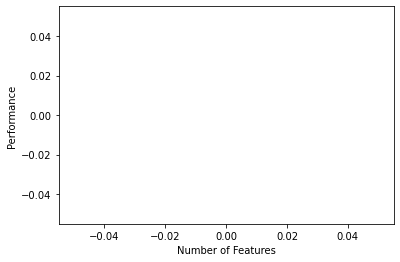

In [203]:
# Plot the results
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.9, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [ ]:
# Extract the feature names for the optimal number using the dictionary provided by the subsets_ method
columns = list(sfs.subsets_[21]['feature_idx'])

In [ ]:
X_train_sfs = X_train_rf[:, columns]
X_test_sfs = X_test_rf[:, columns]

In [ ]:
X_train_sfs.shape

In [ ]:
lm_sfs.fit(X_train_sfs, y_train_rf)

In [ ]:
pred_lm_sfs = lm_sfs.predict(X_test_sfs)

In [207]:
print('Full Model')
print(classification_report(y_test_rf, pred_lm_full, target_names=['No Churn', 'Churn']))

print('Var Thresh Model')
print(classification_report(y_test_rf, pred_lm_vt, target_names=['No Churn', 'Churn']))

print('KBest Model')
print(classification_report(y_test_rf, pred_lm_kbest, target_names=['No Churn', 'Churn']))

print('SFS Model')
#print(classification_report(y_test_rf, pred_lm_sfs, target_names=['No Churn', 'Churn']))

Full Model
              precision    recall  f1-score   support

    No Churn       0.60      0.59      0.59     53616
       Churn       0.59      0.60      0.60     53616

    accuracy                           0.59    107232
   macro avg       0.59      0.59      0.59    107232
weighted avg       0.59      0.59      0.59    107232

Var Thresh Model
              precision    recall  f1-score   support

    No Churn       0.58      0.56      0.57     53616
       Churn       0.57      0.59      0.58     53616

    accuracy                           0.58    107232
   macro avg       0.58      0.58      0.58    107232
weighted avg       0.58      0.58      0.58    107232

KBest Model
              precision    recall  f1-score   support

    No Churn       0.60      0.55      0.58     53616
       Churn       0.58      0.63      0.60     53616

    accuracy                           0.59    107232
   macro avg       0.59      0.59      0.59    107232
weighted avg       0.59      0.59 

### Tuning the Model Hyperparameter

In [214]:
# Small C
model_1 = LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1)

# Default C
model_2 = LogisticRegression(C=1, solver='liblinear')

# Large C
model_3 = LogisticRegression(C=10, solver='liblinear')

In [215]:
model_1.fit(x_train_rf, y_train_rf)

[LibLinear]

LogisticRegression(C=0.05, penalty='l1', solver='liblinear', verbose=1)

In [216]:
model_2.fit(x_train_rf, y_train_rf)

LogisticRegression(C=1, solver='liblinear')

In [217]:
model_3.fit(x_train_rf, y_train_rf)

LogisticRegression(C=10, solver='liblinear')

In [218]:
pred_1 = model_1.predict(x_test_rf)
pred_2 = model_2.predict(x_test_rf)
pred_3 = model_3.predict(x_test_rf)

In [219]:
print('C = 0.05')
print(classification_report(y_test_rf, pred_1, target_names=['No Churn', 'Churn']))

print('C = 1')
print(classification_report(y_test_rf, pred_2, target_names=['No Churn', 'Churn']))

print('C = 10')
print(classification_report(y_test_rf, pred_3, target_names=['No Churn', 'Churn']))

C = 0.05
              precision    recall  f1-score   support

    No Churn       0.60      0.58      0.59     53616
       Churn       0.59      0.61      0.60     53616

    accuracy                           0.60    107232
   macro avg       0.60      0.60      0.60    107232
weighted avg       0.60      0.60      0.60    107232

C = 1
              precision    recall  f1-score   support

    No Churn       0.60      0.59      0.59     53616
       Churn       0.59      0.61      0.60     53616

    accuracy                           0.60    107232
   macro avg       0.60      0.60      0.60    107232
weighted avg       0.60      0.60      0.60    107232

C = 10
              precision    recall  f1-score   support

    No Churn       0.60      0.59      0.59     53616
       Churn       0.59      0.60      0.60     53616

    accuracy                           0.60    107232
   macro avg       0.60      0.60      0.60    107232
weighted avg       0.60      0.60      0.60    10723

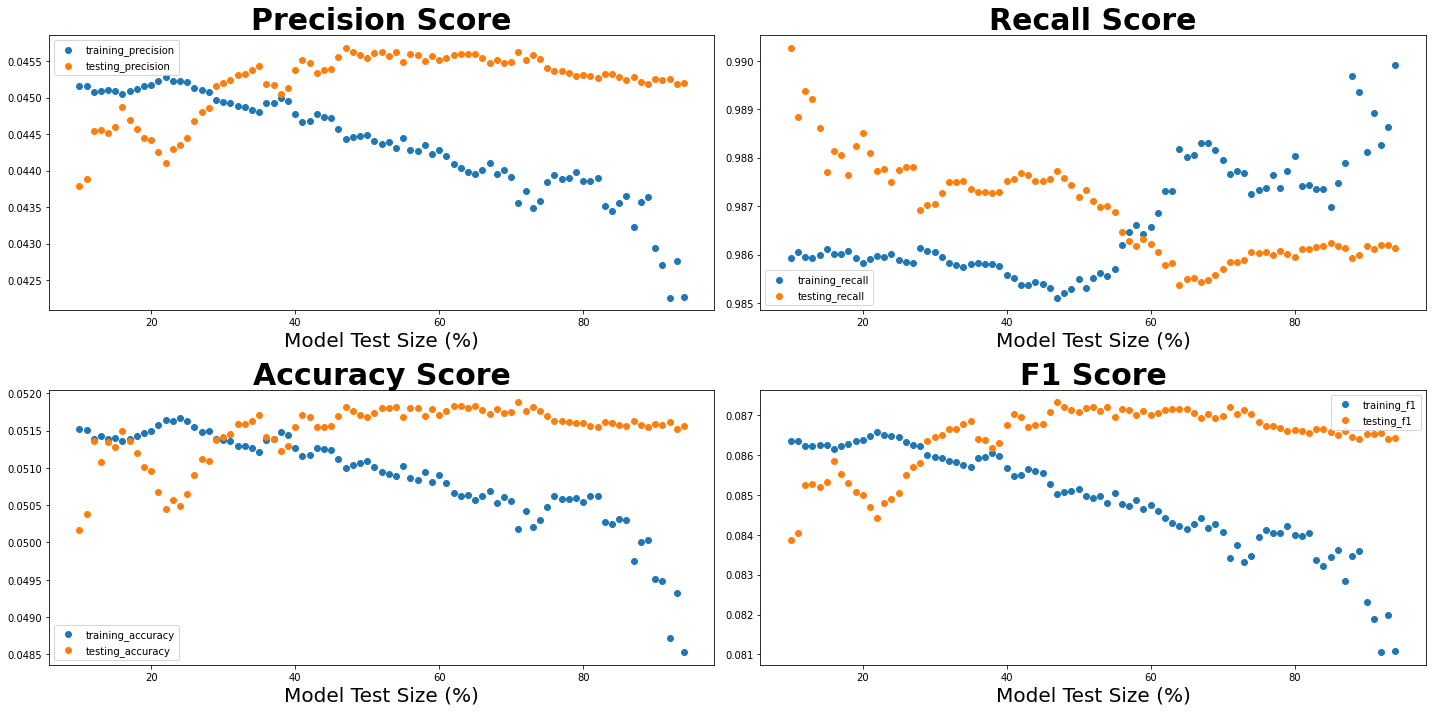

In [152]:
# Print residual scatter plot for 4 main logistic model metrics, iterating through the model and passing multiple 
# test-size objects to visualize effects of train/test size on model performance
print_metric_comparisons(X, y)

Training AUC: 0.6445944854355286
Test AUC: 0.6437320399041286


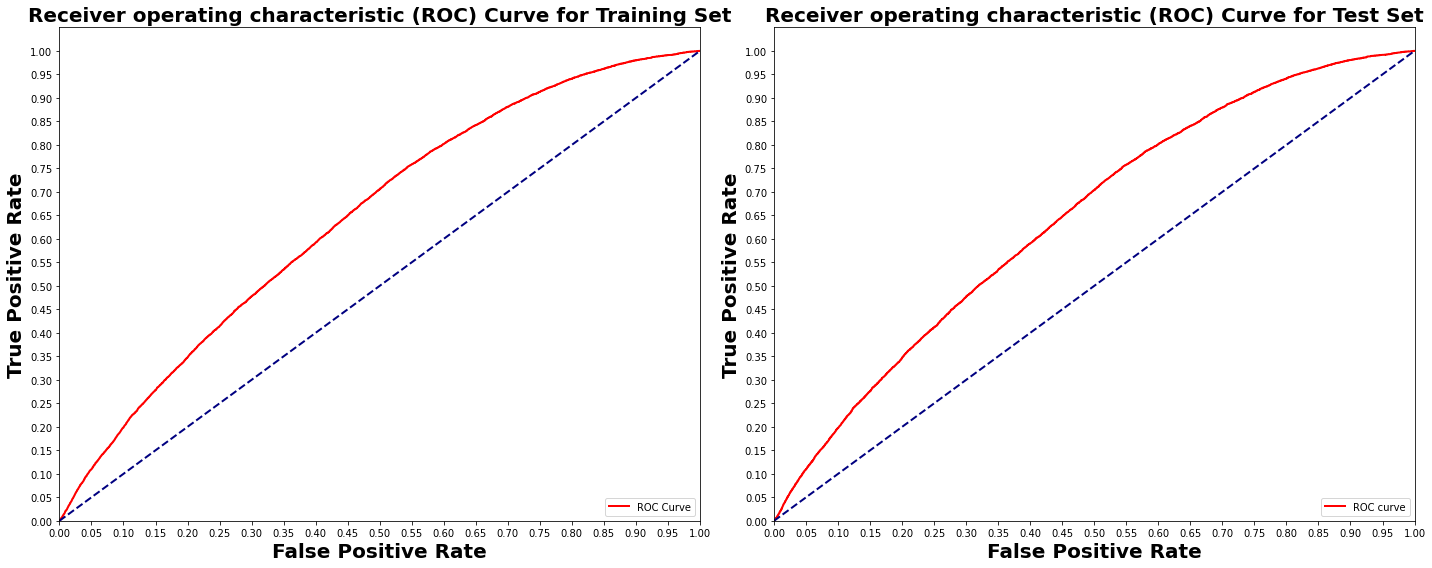

In [156]:
plot_auc(logreg, x_train_rf, x_test_rf, y_train_rf, y_test_rf)

### Neural Network and ML models

In [74]:
# Models
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

In [102]:
from sklearn.preprocessing import MinMaxScaler
features = X_under.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_under)
X_ml = pd.DataFrame(scaler.transform(X_under))
X_ml.columns = features
y_ml = y_under

In [103]:
def stratified_cv(X, y, clf_class, shuffle=True,  **kwargs):
    stratified_k_fold = StratifiedKFold().split(X,y)
    y_pred = y.copy()
    for ii, jj in stratified_k_fold: 
        Xtrain, Xtest = X.iloc[ii], X.iloc[jj]
        ytrain = y.iloc[ii]
        clf = clf_class(**kwargs)
        clf.fit(Xtrain,ytrain)
        y_pred.iloc[jj] = clf.predict(Xtest)
    return y_pred

In [105]:
X = X_ml
y  = y_ml 

####  Machine Learning Models

In [106]:
print('Gradient Boosting Classifier:  {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))

print('Support vector machine(SVM):   {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))

print('Random Forest Classifier:      {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

print('K Nearest Neighbor Classifier: {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))

print('Logistic Regression:           {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('XGBoost Classifier:           {:.2f}'.format(
    metrics.accuracy_score(y, stratified_cv(X, y, XGBClassifier))))

Gradient Boosting Classifier:  0.63
Support vector machine(SVM):   0.59
Random Forest Classifier:      0.63
K Nearest Neighbor Classifier: 0.56


/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression:           0.59
[09:32:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:32:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric

In [107]:
print('Gradient Boosting Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))

print('Support vector machine(SVM):\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))

print('Random Forest Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

print('K Nearest Neighbor Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier,n_neighbors=11))))

print('Logistic Regression:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
      
print('XGBoost Classifier:\n {}\n'.format(
    metrics.classification_report(y, stratified_cv(X, y, XGBClassifier))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.69      0.46      0.55     12722
           1       0.59      0.79      0.68     12722

    accuracy                           0.63     25444
   macro avg       0.64      0.63      0.62     25444
weighted avg       0.64      0.63      0.62     25444


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       0.60      0.54      0.57     12722
           1       0.58      0.63      0.60     12722

    accuracy                           0.59     25444
   macro avg       0.59      0.59      0.59     25444
weighted avg       0.59      0.59      0.59     25444


Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.64      0.57      0.60     12722
           1       0.61      0.68      0.64     12722

    accuracy                           0.62     25444
   macro avg       0.63      0.62     

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/nxums003/.virtualenv/nxums003/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Logistic Regression:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58     12722
           1       0.59      0.60      0.59     12722

    accuracy                           0.59     25444
   macro avg       0.59      0.59      0.59     25444
weighted avg       0.59      0.59      0.59     25444


[09:37:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:37:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was

#### Trying a glm model

In [184]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [240]:
# set GLM modeling parameters
# and initialize model training
glm_model = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True,
                                         remove_collinear_columns = True)
glm_model.train(predictors, response, training_frame= hf_under)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1702245397796_22473


GLM Model: summary


family   link regularization  number_of_predictors_total  \
0    binomial  logit           None                          84   

  number_of_active_predictors  number_of_iterations  training_frame  
0                          70                     4  py_14_sid_9e8d



ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23214082269006892
RMSE: 0.48180994457365545
LogLoss: 0.656655260282205
Null degrees of freedom: 25443
Residual degrees of freedom: 25373
Null deviance: 35272.873724339486
Residual deviance: 33415.872885240846
AIC: 33557.872885240846
AUC: 0.6509532689684312
AUCPR: 0.6216033955790455
Gini: 0.3019065379368624

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3630131953280679: 


0        1   Error                Rate
0      0  2889.0   9833.0  0.7729    (9833.0/12722.0)
1      1   892.0  11830.0  0.0701     (892.0/12722.0)
2  Total  3781.0  21663.0  0.4215   (10725.0/25444.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.363013      0.688091  295.0
1                        max f2   0.152638      0.834429  379.0
2                  max f0point5   0.440041      0.612095  242.0
3                  max accuracy   0.461645      0.608474  226.0
4                 max precision   0.775499      0.741379   33.0
5                    max recall   0.068664      1.000000  396.0
6               max specificity   0.992170      0.999686    0.0
7              max absolute_mcc   0.423968      0.234533  254.0
8    max min_per_class_accuracy   0.504105      0.600535  194.0
9   max mean_per_class_accuracy   0.461645      0.608474  226.0
10                      max tns   0.992170  12718.000000    0.0
11                      max fns   0.992170  12721.000000    0.0
12                      max fps   0.006475  12722.000000  399.0
13                      max tps   0.068664  12722.000000  396.0
14                      max tnr   0.992170      0.999686    0.0
15                      max fnr   0.992170      0.999921    0.0
16                      max fpr   0.006475      1.000000  399.0
17                      max tpr   0.068664      1.000000  396.0


Gains/Lift Table: Avg response rate: 50.00 %, avg score: 10.00 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010061         0.313807  1.093750   
1       2                  0.020005         0.238183  1.130435   
2       3                  0.030027         0.205387  1.043137   
3       4                  0.040009         0.193806  1.188976   
4       5                  0.050031         0.181892  0.878431   
5       6                  0.100024         0.134148  1.141509   
6       7                  0.150016         0.120394  0.885220   
7       8                  0.200008         0.107898  1.031447   
8       9                  0.299992         0.097888  1.139151   
9      10                  0.400016         0.092149  1.093910   
10     11                  0.500000         0.087517  1.042453   
11     12                  0.599984         0.083480  1.000000   
12     13                  0.700008         0.079235  0.962672   
13     14                  0.799992         0.074980  0.893082   
14     15                  0.899976         0.069796  0.911164   
15     16                  1.000000         0.052222  0.895088   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.093750       0.546875  0.486671                  0.546875   
1          1.111984       0.565217  0.271618                  0.555992   
2          1.089005       0.521569  0.217178                  0.544503   
3          1.113949       0.594488  0.198851                  0.556974   
4          1.066771       0.439216  0.188715                  0.533386   
5          1.104126       0.570755  0.150207                  0.552063   
6          1.031176       0.442610  0.126972                  0.515588   
7          1.031244       0.515723  0.113777                  0.515622   
8          1.067208       0.569575  0.102138                  0.533604   
9          1.073885       0.546955  0.094869                  0.536942   
10         1.067599       0.521226  0.089773                  0.533800   
11         1.056334       0.500000  0.085463                  0.528167   
12         1.042951       0.481336  0.081336                  0.521475   
13         1.024220       0.446541  0.077094                  0.512110   
14         1.011660       0.455582  0.072578                  0.505830   
15         1.000000       0.447544  0.065272                  0.500000   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.486671      0.011005                 0.011005   9.375000   
1           0.379778      0.011240                 0.022245  13.043478   
2           0.325507      0.010454                 0.032699   4.313725   
3           0.293906      0.011869                 0.044568  18.897638   
4           0.272834      0.008804                 0.053372 -12.156863   
5           0.211545      0.057066                 0.110439  14.150943   
6           0.183361      0.044254                 0.154693 -11.477987   
7           0.165969      0.051564                 0.206257   3.144654   
8           0.144695      0.113897                 0.320154  13.915094   
9           0.132236      0.109417                 0.429571   9.390963   
10          0.123745      0.104229                 0.533800   4.245283   
11          0.117365      0.099984                 0.633784   0.000000   
12          0.112217      0.096290                 0.730074  -3.732809   
13          0.107827      0.089294                 0.819368 -10.691824   
14          0.103911      0.091102                 0.910470  -8.883648   
15          0.100046      0.089530                 1.000000 -10.491159   

    cumulative_gain  kolmogorov_smirnov  
0          9.375000            0.001886  
1         11.198428            0.004480  
2          8.900524            0.005345  
3         11.394892            0.009118  
4          6.677141            0.006681  
5         10.412574            0.020830  
6          3.117632            0.009354  
7          3.124386        



Scoring History: 


timestamp    duration  iterations  negative_log_likelihood  \
0    2024-01-11 11:32:17   0.000 sec           0             17636.436862   
1    2024-01-11 11:32:17   0.010 sec           1             16718.445556   
2    2024-01-11 11:32:17   0.015 sec           2             16707.972975   
3    2024-01-11 11:32:17   0.025 sec           3             16707.936444   
4    2024-01-11 11:32:17   0.029 sec           4             16707.936443   

   objective training_rmse training_logloss training_r2 training_auc  \
0   0.693147                                                           
1   0.657068                                                           
2   0.656657                                                           
3   0.656655                                                           
4   0.656655       0.48181         0.656655   0.0714367     0.650953   

  training_pr_auc training_lift training_classification_error  
0                                                              
1                                                              
2                                                              
3                                                              
4        0.621603       1.09375                      0.421514


Variable Importances: 


variable  relative_importance  scaled_importance  \
0                         tenure             0.305645           1.000000   
1                    lr_increase             0.158770           0.519458   
2               segment_emerging             0.149289           0.488440   
3              tenure_group_<2yr             0.147983           0.484166   
4        tenure_group_2yr to 3yr             0.118264           0.386932   
5       lsm_-9999999999999999999             0.114981           0.376190   
6              one_yr_loss_ratio             0.109477           0.358185   
7                  ad_loss_of_si             0.090797           0.297066   
8                    count_th_lo             0.089568           0.293046   
9   three_yr_lr_band_a: 0 to 20%             0.085032           0.278204   
10                 new_premium_2             0.080064           0.261952   
11       tenure_group_3yr to 4yr             0.078636           0.257281   
12               peril_filter_AD             0.076149           0.249143   
13              count_ad_replace             0.075842           0.248139   
14              map_age_21 to 30             0.074721           0.244469   
15                 five_yr_all_0             0.069548           0.227546   
16        psr_2_increase_loading             0.068072           0.222718   
17              map_age_31 to 40             0.066370           0.217148   
18        most_used_prov_Eastern             0.057664           0.188663   
19       tenure_group_4yr to 5yr             0.055291           0.180899   

    percentage  
0     0.096585  
1     0.050172  
2     0.047176  
3     0.046763  
4     0.037372  
5     0.036335  
6     0.034595  
7     0.028692  
8     0.028304  
9     0.026870  
10    0.025301  
11    0.024850  
12    0.024064  
13    0.023967  
14    0.023612  
15    0.021978  
16    0.021511  
17    0.020973  
18    0.018222  
19    0.017472


See the whole table with table.as_data_frame()


In [190]:
predict = glm_model.predict(hf_under)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [246]:
perf = glm_model.model_performance(h20_x_test)
threshold = 0.775499
glm_model.model_performance(h20_x_test).confusion_matrix(thresholds=threshold)

Could not find exact threshold 0.775499; using closest threshold found 0.7763223524502982.

Confusion Matrix (Act/Pred) @ threshold = 0.7763223524502982: 


0      1   Error               Rate
0      0  66230.0  789.0  0.0118    (789.0/67019.0)
1      1   3097.0   84.0  0.9736    (3097.0/3181.0)
2  Total  69327.0  873.0  0.0554   (3886.0/70200.0)

In [260]:
perf = glm_model.model_performance(h20_x_test)
threshold = 0.7
glm_model.model_performance(h20_x_test).confusion_matrix(thresholds=threshold)

Could not find exact threshold 0.7; using closest threshold found 0.7010793343798454.

Confusion Matrix (Act/Pred) @ threshold = 0.7010793343798454: 


0       1   Error               Rate
0      0  64440.0  2579.0  0.0385   (2579.0/67019.0)
1      1   2912.0   269.0  0.9154    (2912.0/3181.0)
2  Total  67352.0  2848.0  0.0782   (5491.0/70200.0)

In [213]:
threshold = 0.876709
y_pred = (predict[:, 2] > threshold)
#confusion_matrix(y_test, y_pred)

In [194]:
glm_model.model_performance(h20_x_test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.23409475796334625
RMSE: 0.48383339897463284
LogLoss: 0.6605466749452783
Null degrees of freedom: 70199
Residual degrees of freedom: 70129
Null deviance: 97317.8641506317
Residual deviance: 92740.75316231708
AIC: 92882.75316231708
AUC: 0.6527732152174313
AUCPR: 0.07348469382383921
Gini: 0.3055464304348625

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5686998152954762: 


0        1   Error                Rate
0      0  53344.0  13675.0   0.204   (13675.0/67019.0)
1      1   2022.0   1159.0  0.6356     (2022.0/3181.0)
2  Total  55366.0  14834.0  0.2236   (15697.0/70200.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.568700      0.128671  131.0
1                        max f2   0.486539      0.236732  194.0
2                  max f0point5   0.657154      0.104382   75.0
3                  max accuracy   0.988669      0.954587    0.0
4                 max precision   0.876709      0.112360   10.0
5                    max recall   0.011731      1.000000  399.0
6               max specificity   0.988669      0.999881    0.0
7              max absolute_mcc   0.445408      0.094071  226.0
8    max min_per_class_accuracy   0.503367      0.600486  180.0
9   max mean_per_class_accuracy   0.445408      0.611070  226.0
10                      max tns   0.988669  67011.000000    0.0
11                      max fns   0.988669   3180.000000    0.0
12                      max fps   0.011731  67019.000000  399.0
13                      max tps   0.011731   3181.000000  399.0
14                      max tnr   0.988669      0.999881    0.0
15                      max fnr   0.988669      0.999686    0.0
16                      max fpr   0.011731      1.000000  399.0
17                      max tpr   0.011731      1.000000  399.0


Gains/Lift Table: Avg response rate:  4.53 %, avg score:  2.12 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.061098  1.477523   
1       2                      0.02         0.047345  1.257466   
2       3                      0.03         0.043279  1.320340   
3       4                      0.04         0.041543  1.005973   
4       5                      0.05         0.037817  0.691606   
5       6                      0.10         0.028269  1.207168   
6       7                      0.15         0.025862  0.641308   
7       8                      0.20         0.022832  1.144294   
8       9                      0.30         0.020740  1.235461   
9      10                      0.40         0.019517  1.213455   
10     11                      0.50         0.018542  1.009117   
11     12                      0.60         0.017665  1.112858   
12     13                      0.70         0.016858  0.880226   
13     14                      0.80         0.016015  0.785916   
14     15                      0.90         0.014950  0.807922   
15     16                      1.00         0.011285  0.883370   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          1.477523       0.066952  0.104486                  0.066952   
1          1.367494       0.056980  0.054061                  0.061966   
2          1.351776       0.059829  0.045232                  0.061254   
3          1.265325       0.045584  0.042302                  0.057336   
4          1.150582       0.031339  0.040102                  0.052137   
5          1.178875       0.054701  0.031136                  0.053419   
6          0.999686       0.029060  0.027057                  0.045299   
7          1.035838       0.051852  0.024165                  0.046937   
8          1.102379       0.055983  0.021637                  0.049953   
9          1.130148       0.054986  0.020099                  0.051211   
10         1.105942       0.045726  0.019017                  0.050114   
11         1.107094       0.050427  0.018097                  0.050166   
12         1.074685       0.039886  0.017265                  0.048698   
13         1.038588       0.035613  0.016448                  0.047062   
14         1.012959       0.036610  0.015518                  0.045901   
15         1.000000       0.040028  0.014017                  0.045313   

    cumulative_score  capture_rate  cumulative_capture_rate       gain  \
0           0.104486      0.014775                 0.014775  47.752279   
1           0.079273      0.012575                 0.027350  25.746621   
2           0.067926      0.013203                 0.040553  32.033952   
3           0.061520      0.010060                 0.050613   0.597296   
4           0.057237      0.006916                 0.057529 -30.839359   
5           0.044186      0.060358                 0.117887  20.716756   
6           0.038477      0.032065                 0.149953 -35.869224   
7           0.034899      0.057215                 0.207168  14.429425   
8           0.030478      0.123546                 0.330714  23.546055   
9           0.027883      0.121345                 0.452059  21.345489   
10          0.026110      0.100912                 0.552971   0.911663   
11          0.024775      0.111286                 0.664257  11.285759   
12          0.023702      0.088023                 0.752279 -11.977366   
13          0.022795      0.078592                 0.830871 -21.408362   
14          0.021986      0.080792                 0.911663 -19.207796   
15          0.021189      0.088337                 1.000000 -11.662999   

    cumulative_gain  kolmogorov_smirnov  
0         47.752279            0.005002  
1         36.749450            0.007699  
2         35.177617            0.011054  
3         26.532537            0.011117  
4         15.058158            0.007886  
5         17.887457            0.018736  
6         -0.031437           -0.000049  
7          3.583779        

In [ ]:
aml.train(x=predictors,
        y=response,
        training_frame=train,
        validation_frame=valid

In [263]:
# Build and train the model:
from h2o.estimators import H2OKMeansEstimator

In [275]:
# Split into train and test
train, valid = hf_over.split_frame(ratios=[.8], seed=123)

In [276]:
# Build and train the model:
iris_kmeans = H2OKMeansEstimator(k=2,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)
iris_kmeans.train(x=predictors,
                  training_frame=train,
                  validation_frame=valid)

# Eval performance:
perf = iris_kmeans.model_performance()
perf

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%

ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 3.999962323611667e+38
Total Sum of Square Error to Grand Mean: 1.311277283557276e+42
Between Cluster Sum of Square Error: 1.3108772873249147e+42

Centroid Statistics: 


centroid      size  within_cluster_sum_of_squares
0         1.0    4415.0                   5.033081e+24
1         2.0  424845.0                   3.999962e+38

In [278]:
iris_kmeans.model_performance(h20_x_test)


ModelMetricsClustering: kmeans
** Reported on test data. **

Total Within Cluster Sum of Square Error: 6.1769393185790775e+32
Total Sum of Square Error to Grand Mean: 1.5454887964192076e+41
Between Cluster Sum of Square Error: 1.5454887902422682e+41

Centroid Statistics: 


centroid     size  within_cluster_sum_of_squares
0         1.0    519.0                   5.916578e+23
1         2.0  69681.0                   6.176939e+32

In [280]:
preds = iris_kmeans.predict(h20_x_test)

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


In [ ]:
h20_x_test = h2o.H2OFrame(x_y_test)

In [297]:
ss = preds.cbind(h20_x_test)

In [301]:
ss['predict']

predict 
 
 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1

In [24]:
sc.stop()